In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import optuna
data = scipy.io.loadmat('data/assignmentImageDenoising_phantom.mat')

print("Keys in the loaded data:")
print(list(data.keys()))

Keys in the loaded data:
['__header__', '__version__', '__globals__', 'imageNoiseless', 'imageNoisy']


In [2]:

image_noiseless = data['imageNoiseless']
image_noisy = data['imageNoisy']


print(f"Noiseless image shape: {image_noiseless.shape}")
print(f"Noisy image shape: {image_noisy.shape}")
print(f"Image data type: {image_noiseless.dtype}")
print(f"Noiseless image range: [{np.min(image_noiseless):.3f}, {np.max(image_noiseless):.3f}]")
print(f"Noisy image range: [{np.min(image_noisy):.3f}, {np.max(image_noisy):.3f}]")

Noiseless image shape: (256, 256)
Noisy image shape: (256, 256)
Image data type: float64
Noiseless image range: [0.000, 1.000]
Noisy image range: [0.000, 1.198]


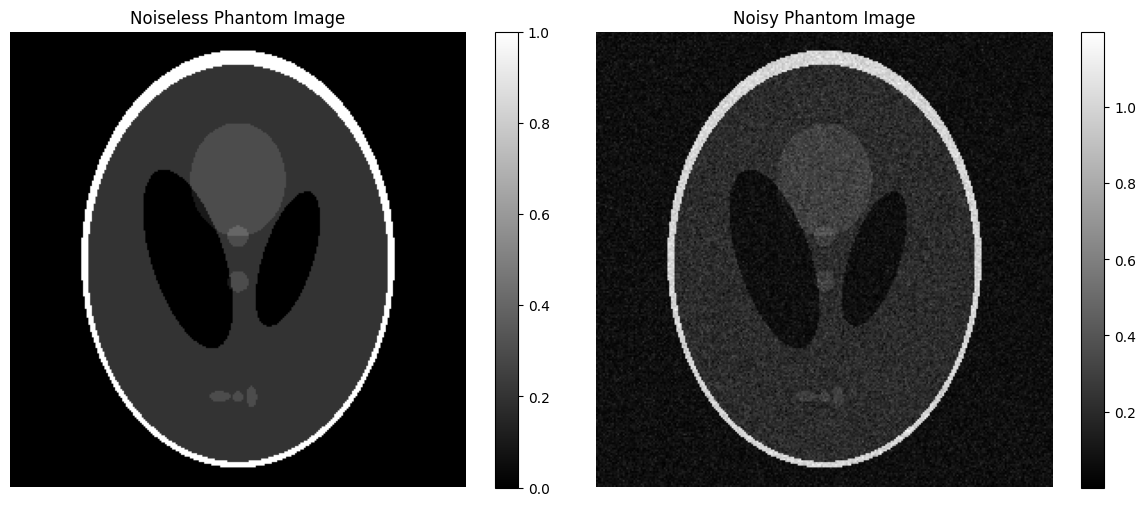

In [3]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_noiseless, cmap='gray')
plt.title('Noiseless Phantom Image')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_noisy, cmap='gray')
plt.title('Noisy Phantom Image')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

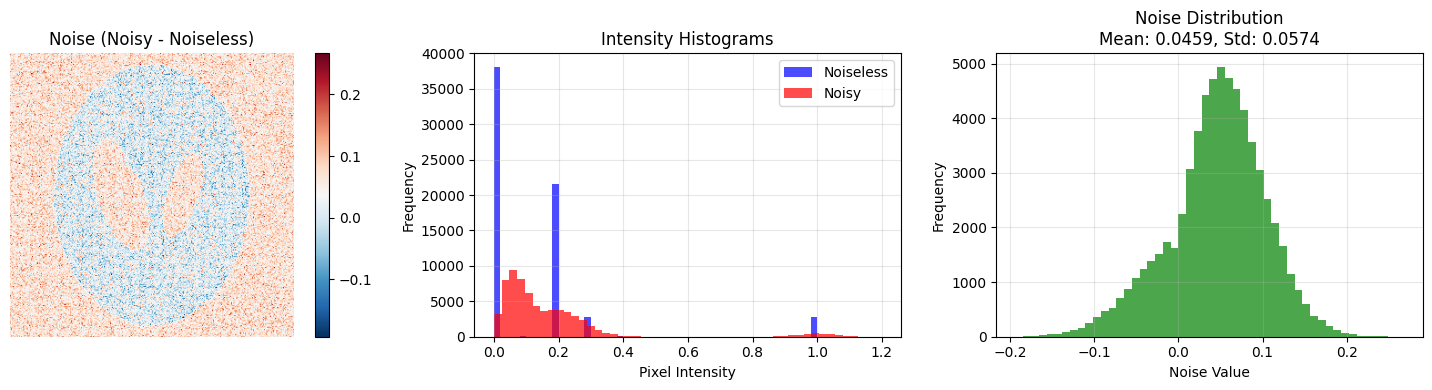

Summary Statistics:
Image size: (256, 256)
Noise standard deviation: 0.0574
Noise mean: 0.0459
Signal-to-Noise ratio (SNR): 11.40 dB


In [4]:
noise = image_noisy - image_noiseless
noise_std = np.std(noise)
noise_mean = np.mean(noise)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(noise, cmap='RdBu_r')
plt.title('Noise (Noisy - Noiseless)')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
plt.hist(image_noiseless.flatten(), bins=50, alpha=0.7, label='Noiseless', color='blue')
plt.hist(image_noisy.flatten(), bins=50, alpha=0.7, label='Noisy', color='red')
plt.title('Intensity Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(noise.flatten(), bins=50, alpha=0.7, color='green')
plt.title(f'Noise Distribution\nMean: {noise_mean:.4f}, Std: {noise_std:.4f}')
plt.xlabel('Noise Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Summary Statistics:")
print(f"Image size: {image_noiseless.shape}")
print(f"Noise standard deviation: {noise_std:.4f}")
print(f"Noise mean: {noise_mean:.4f}")
print(f"Signal-to-Noise ratio (SNR): {20 * np.log10(np.std(image_noiseless) / noise_std):.2f} dB")

# Bayesian Denoising with MRF Priors


In [5]:
import numpy as np
from scipy.ndimage import shift
import time

def circshift(image, shift_vector):
    shifted = np.roll(image, shift_vector[0], axis=0)
    shifted = np.roll(shifted, shift_vector[1], axis=1)
    return shifted

def compute_rrmse(A, B):
    # RRMSE(A,B) = sqrt(sum((A-B)^2) / sum(A^2))
    numerator = np.sum((A - B) ** 2)
    denominator = np.sum(A ** 2)
    return np.sqrt(numerator / denominator)

def quadratic_prior(u):   
    # Quadratic potential function: g1(u) = |u|^2
    return u ** 2

def quadratic_prior_gradient(u):
   
    # Gradient of quadratic potential function: g1'(u) = 2u
  
    return 2 * u

def huber_prior(u, gamma):
    """
    Discontinuity-adaptive Huber potential function:
    g2(u) = 0.5|u|^2 if |u| <= gamma
    g2(u) = gamma|u| - 0.5*gamma^2 if |u| > gamma
    """
    abs_u = np.abs(u)
    return np.where(abs_u <= gamma, 
                    0.5 * u ** 2,
                    gamma * abs_u - 0.5 * gamma ** 2)

def huber_prior_gradient(u, gamma):
    """
    Gradient of Huber potential function:
    g2'(u) = u if |u| <= gamma
    g2'(u) = gamma*sign(u) if |u| > gamma
    """
    abs_u = np.abs(u)
    return np.where(abs_u <= gamma,
                    u,
                    gamma * np.sign(u))

def discontinuity_preserving_prior(u, gamma):
    """
    Discontinuity-preserving potential function:
    g3(u) = gamma * |u| - gamma**2 * log(1 + |u|/gamma)
    """
    abs_u = np.abs(u)
    return gamma * abs_u - gamma**2 * np.log(1 + abs_u / gamma)

def discontinuity_preserving_prior_gradient(u, gamma):
    """
    Gradient of discontinuity-preserving potential function:
    g3'(u) = u / (1 + |u|/gamma)
    """
    return u / (1 + np.abs(u) / gamma)

print("Prior functions and utility functions defined successfully!")

Prior functions and utility functions defined successfully!


In [6]:
def compute_neighbor_differences(x):
  
    left_neighbor = circshift(x, [0, -1]) 
    right_neighbor = circshift(x, [0, 1])  
    up_neighbor = circshift(x, [-1, 0])   
    down_neighbor = circshift(x, [1, 0])
    diff_left = x - left_neighbor
    diff_right = x - right_neighbor
    diff_up = x - up_neighbor
    diff_down = x - down_neighbor
    
    return [diff_left, diff_right, diff_up, diff_down]

def compute_mrf_energy(x, prior_func, gamma=None):

    # Compute MRF prior energy for an image
 
    differences = compute_neighbor_differences(x)
    energy = 0
    
    for diff in differences:
        if gamma is not None:
            energy += np.sum(prior_func(diff, gamma))
        else:
            energy += np.sum(prior_func(diff))
    
    return energy

def compute_mrf_gradient(x, prior_gradient_func, gamma=None):

    # Compute gradient of MRF prior energy
  
    differences = compute_neighbor_differences(x)
    gradient = np.zeros_like(x)
    for i, diff in enumerate(differences):
        if gamma is not None:
            grad_diff = prior_gradient_func(diff, gamma)
        else:
            grad_diff = prior_gradient_func(diff)
        gradient += grad_diff
        
        if i == 0:  
            gradient -= circshift(grad_diff, [0, 1])
        elif i == 1:  
            gradient -= circshift(grad_diff, [0, -1])
        elif i == 2:  
            gradient -= circshift(grad_diff, [1, 0])
        elif i == 3:  
            gradient -= circshift(grad_diff, [-1, 0])
    
    return gradient

print("MRF energy and gradient functions defined successfully!")

MRF energy and gradient functions defined successfully!


In [11]:
def bayesian_denoising(noisy_image, alpha, prior_type='quadratic', gamma=1.0, 
                      max_iterations=100, tolerance=1e-6, sigma=1.0):
    
    x = noisy_image.copy()
    objective_values = []
    
    if prior_type == 'quadratic':
        prior_func = quadratic_prior
        prior_grad_func = quadratic_prior_gradient
        use_gamma = False
    elif prior_type == 'huber':
        prior_func = huber_prior
        prior_grad_func = huber_prior_gradient
        use_gamma = True
    elif prior_type == 'discontinuity_preserving':
        prior_func = discontinuity_preserving_prior
        prior_grad_func = discontinuity_preserving_prior_gradient
        use_gamma = True
    else:
        raise ValueError("prior_type must be 'quadratic', 'huber', or 'discontinuity_preserving'")
    
    step_size = 0.1
    temperature = 1.0
    cooling_rate = 0.975

    for iteration in range(max_iterations):
        likelihood_gradient = (1 / sigma**2) * (noisy_image - x)
        
        if use_gamma:
            prior_gradient = compute_mrf_gradient(x, prior_grad_func, gamma)
        else:
            prior_gradient = compute_mrf_gradient(x, prior_grad_func)
        total_gradient = (1 - alpha) * likelihood_gradient - alpha * prior_gradient
        
        likelihood_energy = -0.5 / (sigma**2) * np.sum((x - noisy_image)**2)
        if use_gamma:
            prior_energy = -compute_mrf_energy(x, prior_func, gamma)
        else:
            prior_energy = -compute_mrf_energy(x, prior_func)
        
        current_objective = (1 - alpha) * likelihood_energy + alpha * prior_energy
        objective_values.append(current_objective)
        
        x_new, new_objective, accepted = simulated_annealing_step(x,total_gradient,current_objective,noisy_image,alpha,prior_func,gamma if use_gamma else None,sigma,step_size,temperature, iteration)
        x = x_new
        temperature *= cooling_rate
        if iteration > 0:
            if objective_values[-1] - objective_values[-2] < tolerance:
                print(f"Converged after {iteration + 1} iterations")
                break
            if objective_values[-1] < objective_values[-2]:
                print(f"Warning: Objective decreased at iteration {iteration + 1}")
        
        if (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}: Objective = {current_objective:.6f}, Step size = {step_size:.6f}")
    
    return x, objective_values

def simulated_annealing_step(x,gradient,current_obj,noisy_image,alpha,prior_func,gamma,sigma,base_step,temperature, iteration):
 
   #  One simulated annealing update step
    step = base_step / (iteration+1)
    x_trial = x + step * gradient

    likelihood_energy = -0.5 / (sigma**2) * np.sum((x_trial - noisy_image)**2)

    if gamma is not None:
        prior_energy = -compute_mrf_energy(x_trial, prior_func, gamma)
    else:
        prior_energy = -compute_mrf_energy(x_trial, prior_func)

    trial_objective = (1 - alpha) * likelihood_energy + alpha * prior_energy

    delta_obj = trial_objective - current_obj

    if delta_obj >= 0:
        accept = True
    else:
        accept_prob = np.exp(delta_obj / temperature)
        accept = np.random.rand() < accept_prob
    if accept:
        return x_trial, trial_objective, True
    else:
        return x, current_obj, False

print("Bayesian denoising algorithm implemented successfully!")

Bayesian denoising algorithm implemented successfully!


## Testing the Denoising Algorithm

Now let's test our Bayesian denoising algorithm with different MRF priors and find optimal parameters.

In [12]:
def objective_quadratic(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='quadratic',
        max_iterations=100,
        tolerance=1e-6
    )

    rrmse = compute_rrmse(image_noiseless, denoised)
    return rrmse


study_quad = optuna.create_study(direction="minimize")
study_quad.optimize(objective_quadratic, n_trials=50)

best_alpha_quad = study_quad.best_params["alpha"]
best_rrmse_quad = study_quad.best_value

print(f"Best alpha (Quadratic): {best_alpha_quad}")
print(f"Best RRMSE (Quadratic): {best_rrmse_quad:.6f}")


[I 2026-02-07 00:04:12,427] A new study created in memory with name: no-name-a9442ee3-afcb-4a26-b167-260eb468c165


Iteration 10: Objective = -40.372616, Step size = 0.100000
Iteration 20: Objective = -39.866197, Step size = 0.100000
Iteration 30: Objective = -39.613420, Step size = 0.100000
Iteration 40: Objective = -39.450191, Step size = 0.100000
Iteration 50: Objective = -39.331854, Step size = 0.100000
Iteration 60: Objective = -39.240140, Step size = 0.100000
Iteration 70: Objective = -39.165890, Step size = 0.100000


[I 2026-02-07 00:04:13,097] Trial 0 finished with value: 0.2910764223024907 and parameters: {'alpha': 0.012035804982029054}. Best is trial 0 with value: 0.2910764223024907.


Iteration 80: Objective = -39.103898, Step size = 0.100000
Iteration 90: Objective = -39.050941, Step size = 0.100000
Iteration 100: Objective = -39.004890, Step size = 0.100000
Iteration 10: Objective = -289.295609, Step size = 0.100000
Iteration 20: Objective = -272.012120, Step size = 0.100000
Iteration 30: Objective = -265.003301, Step size = 0.100000
Iteration 40: Objective = -260.952611, Step size = 0.100000
Iteration 50: Objective = -258.225914, Step size = 0.100000
Iteration 60: Objective = -256.225567, Step size = 0.100000


[I 2026-02-07 00:04:13,596] Trial 1 finished with value: 0.31440074535444107 and parameters: {'alpha': 0.2301094994771746}. Best is trial 0 with value: 0.2910764223024907.


Iteration 70: Objective = -254.674484, Step size = 0.100000
Iteration 80: Objective = -253.424317, Step size = 0.100000
Iteration 90: Objective = -252.387505, Step size = 0.100000
Iteration 100: Objective = -251.508571, Step size = 0.100000
Iteration 10: Objective = -46.918396, Step size = 0.100000
Iteration 20: Objective = -46.234831, Step size = 0.100000
Iteration 30: Objective = -45.895232, Step size = 0.100000
Iteration 40: Objective = -45.676563, Step size = 0.100000
Iteration 50: Objective = -45.518362, Step size = 0.100000
Iteration 60: Objective = -45.395952, Step size = 0.100000


[I 2026-02-07 00:04:14,090] Trial 2 finished with value: 0.2900066926652962 and parameters: {'alpha': 0.014179759669735089}. Best is trial 2 with value: 0.2900066926652962.


Iteration 70: Objective = -45.296985, Step size = 0.100000
Iteration 80: Objective = -45.214450, Step size = 0.100000
Iteration 90: Objective = -45.144014, Step size = 0.100000
Iteration 100: Objective = -45.082818, Step size = 0.100000
Iteration 10: Objective = -244.375523, Step size = 0.100000
Iteration 20: Objective = -229.477374, Step size = 0.100000
Iteration 30: Objective = -223.343639, Step size = 0.100000
Iteration 40: Objective = -219.790537, Step size = 0.100000
Iteration 50: Objective = -217.401084, Step size = 0.100000


[I 2026-02-07 00:04:14,556] Trial 3 finished with value: 0.29378000010553107 and parameters: {'alpha': 0.14398887183546902}. Best is trial 2 with value: 0.2900066926652962.


Iteration 60: Objective = -215.651823, Step size = 0.100000
Iteration 70: Objective = -214.298857, Step size = 0.100000
Iteration 80: Objective = -213.211274, Step size = 0.100000
Iteration 90: Objective = -212.311707, Step size = 0.100000
Iteration 100: Objective = -211.551113, Step size = 0.100000
Iteration 10: Objective = -342.515149, Step size = 0.100000
Iteration 20: Objective = -317.172088, Step size = 0.100000
Iteration 30: Objective = -306.105511, Step size = 0.100000
Iteration 40: Objective = -299.435083, Step size = 0.100000
Iteration 50: Objective = -294.813498, Step size = 0.100000


[I 2026-02-07 00:04:15,007] Trial 4 finished with value: 0.37605292728979445 and parameters: {'alpha': 0.5352904628528712}. Best is trial 2 with value: 0.2900066926652962.


Iteration 60: Objective = -291.348655, Step size = 0.100000
Iteration 70: Objective = -288.615255, Step size = 0.100000
Iteration 80: Objective = -286.380588, Step size = 0.100000
Iteration 90: Objective = -284.504833, Step size = 0.100000
Iteration 100: Objective = -282.898059, Step size = 0.100000
Iteration 10: Objective = -216.432750, Step size = 0.100000
Iteration 20: Objective = -203.773617, Step size = 0.100000
Iteration 30: Objective = -198.412156, Step size = 0.100000
Iteration 40: Objective = -195.263282, Step size = 0.100000
Iteration 50: Objective = -193.127460, Step size = 0.100000
Iteration 60: Objective = -191.554575, Step size = 0.100000
Iteration 70: Objective = -190.332684, Step size = 0.100000
Iteration 80: Objective = -189.347145, Step size = 0.100000
Iteration 90: Objective = -188.529790, Step size = 0.100000


[I 2026-02-07 00:04:15,489] Trial 5 finished with value: 0.28657694371908976 and parameters: {'alpha': 0.11038830407468792}. Best is trial 5 with value: 0.28657694371908976.


Iteration 100: Objective = -187.837198, Step size = 0.100000
Iteration 10: Objective = -13.563205, Step size = 0.100000
Iteration 20: Objective = -13.505998, Step size = 0.100000
Iteration 30: Objective = -13.476915, Step size = 0.100000
Iteration 40: Objective = -13.457924, Step size = 0.100000
Iteration 50: Objective = -13.444043, Step size = 0.100000
Iteration 60: Objective = -13.433215, Step size = 0.100000
Iteration 70: Objective = -13.424403, Step size = 0.100000
Iteration 80: Objective = -13.417013, Step size = 0.100000
Iteration 90: Objective = -13.410674, Step size = 0.100000


[I 2026-02-07 00:04:15,948] Trial 6 finished with value: 0.2958964699389474 and parameters: {'alpha': 0.0038342650252980916}. Best is trial 5 with value: 0.28657694371908976.


Iteration 100: Objective = -13.405144, Step size = 0.100000
Iteration 10: Objective = -308.360568, Step size = 0.100000
Iteration 20: Objective = -290.151654, Step size = 0.100000
Iteration 30: Objective = -282.651623, Step size = 0.100000
Iteration 40: Objective = -278.270600, Step size = 0.100000
Iteration 50: Objective = -275.297908, Step size = 0.100000
Iteration 60: Objective = -273.103254, Step size = 0.100000
Iteration 70: Objective = -271.392616, Step size = 0.100000
Iteration 80: Objective = -270.007763, Step size = 0.100000
Iteration 90: Objective = -268.854876, Step size = 0.100000


[I 2026-02-07 00:04:16,404] Trial 7 finished with value: 0.3277141949002952 and parameters: {'alpha': 0.2880905405748489}. Best is trial 5 with value: 0.28657694371908976.


Iteration 100: Objective = -267.874279, Step size = 0.100000
Iteration 10: Objective = -16.006713, Step size = 0.100000
Iteration 20: Objective = -15.927038, Step size = 0.100000
Iteration 30: Objective = -15.886597, Step size = 0.100000
Iteration 40: Objective = -15.860215, Step size = 0.100000
Iteration 50: Objective = -15.840946, Step size = 0.100000
Iteration 60: Objective = -15.825924, Step size = 0.100000
Iteration 70: Objective = -15.813705, Step size = 0.100000
Iteration 80: Objective = -15.803460, Step size = 0.100000
Iteration 90: Objective = -15.794677, Step size = 0.100000


[I 2026-02-07 00:04:16,878] Trial 8 finished with value: 0.29542974634354047 and parameters: {'alpha': 0.004546180101885569}. Best is trial 5 with value: 0.28657694371908976.


Iteration 100: Objective = -15.787016, Step size = 0.100000
Iteration 10: Objective = -326.263958, Step size = 0.100000
Iteration 20: Objective = -306.368108, Step size = 0.100000
Iteration 30: Objective = -297.960690, Step size = 0.100000
Iteration 40: Objective = -292.977958, Step size = 0.100000
Iteration 50: Objective = -289.563509, Step size = 0.100000
Iteration 60: Objective = -287.024166, Step size = 0.100000
Iteration 70: Objective = -285.033407, Step size = 0.100000
Iteration 80: Objective = -283.414170, Step size = 0.100000
Iteration 90: Objective = -282.060818, Step size = 0.100000


[I 2026-02-07 00:04:17,329] Trial 9 finished with value: 0.3445034028065901 and parameters: {'alpha': 0.367192284822403}. Best is trial 5 with value: 0.28657694371908976.


Iteration 100: Objective = -280.905806, Step size = 0.100000
Iteration 10: Objective = -0.574583, Step size = 0.100000
Iteration 20: Objective = -0.574480, Step size = 0.100000
Iteration 30: Objective = -0.574427, Step size = 0.100000
Iteration 40: Objective = -0.574393, Step size = 0.100000
Iteration 50: Objective = -0.574367, Step size = 0.100000
Iteration 60: Objective = -0.574348, Step size = 0.100000
Iteration 70: Objective = -0.574331, Step size = 0.100000
Iteration 80: Objective = -0.574318, Step size = 0.100000
Iteration 90: Objective = -0.574306, Step size = 0.100000


[I 2026-02-07 00:04:17,799] Trial 10 finished with value: 0.2984627796282775 and parameters: {'alpha': 0.00015854467357280478}. Best is trial 5 with value: 0.28657694371908976.


Converged after 98 iterations
Iteration 10: Objective = -92.483903, Step size = 0.100000
Iteration 20: Objective = -89.851598, Step size = 0.100000
Iteration 30: Objective = -88.589373, Step size = 0.100000
Iteration 40: Objective = -87.793809, Step size = 0.100000
Iteration 50: Objective = -87.227048, Step size = 0.100000
Iteration 60: Objective = -86.793779, Step size = 0.100000
Iteration 70: Objective = -86.446944, Step size = 0.100000
Iteration 80: Objective = -86.160128, Step size = 0.100000
Iteration 90: Objective = -85.917136, Step size = 0.100000


[I 2026-02-07 00:04:18,259] Trial 11 finished with value: 0.28393949588156653 and parameters: {'alpha': 0.031023726656662153}. Best is trial 11 with value: 0.28393949588156653.


Iteration 100: Objective = -85.707385, Step size = 0.100000
Iteration 10: Objective = -128.002670, Step size = 0.100000
Iteration 20: Objective = -123.039426, Step size = 0.100000
Iteration 30: Objective = -120.733029, Step size = 0.100000
Iteration 40: Objective = -119.306157, Step size = 0.100000
Iteration 50: Objective = -118.303083, Step size = 0.100000
Iteration 60: Objective = -117.544154, Step size = 0.100000
Iteration 70: Objective = -116.941736, Step size = 0.100000
Iteration 80: Objective = -116.447102, Step size = 0.100000


[I 2026-02-07 00:04:18,754] Trial 12 finished with value: 0.2812500507764434 and parameters: {'alpha': 0.04722415635987432}. Best is trial 12 with value: 0.2812500507764434.


Iteration 90: Objective = -116.030622, Step size = 0.100000
Iteration 100: Objective = -115.673058, Step size = 0.100000
Iteration 10: Objective = -104.650970, Step size = 0.100000
Iteration 20: Objective = -101.295065, Step size = 0.100000
Iteration 30: Objective = -99.702434, Step size = 0.100000
Iteration 40: Objective = -98.704802, Step size = 0.100000
Iteration 50: Objective = -97.997229, Step size = 0.100000
Iteration 60: Objective = -97.458177, Step size = 0.100000
Iteration 70: Objective = -97.027881, Step size = 0.100000
Iteration 80: Objective = -96.672895, Step size = 0.100000


[I 2026-02-07 00:04:19,202] Trial 13 finished with value: 0.2827895633259067 and parameters: {'alpha': 0.0362110290033425}. Best is trial 12 with value: 0.2812500507764434.


Iteration 90: Objective = -96.372771, Step size = 0.100000
Iteration 100: Objective = -96.114176, Step size = 0.100000
Iteration 10: Objective = -3.222287, Step size = 0.100000
Iteration 20: Objective = -3.219058, Step size = 0.100000
Iteration 30: Objective = -3.217406, Step size = 0.100000
Iteration 40: Objective = -3.216323, Step size = 0.100000
Iteration 50: Objective = -3.215528, Step size = 0.100000
Iteration 60: Objective = -3.214907, Step size = 0.100000
Iteration 70: Objective = -3.214401, Step size = 0.100000
Iteration 80: Objective = -3.213976, Step size = 0.100000


[I 2026-02-07 00:04:19,660] Trial 14 finished with value: 0.29792804805678896 and parameters: {'alpha': 0.0008934614398271191}. Best is trial 12 with value: 0.2812500507764434.


Iteration 90: Objective = -3.213610, Step size = 0.100000
Iteration 100: Objective = -3.213291, Step size = 0.100000
Iteration 10: Objective = -125.530547, Step size = 0.100000
Iteration 20: Objective = -120.750253, Step size = 0.100000
Iteration 30: Objective = -118.523750, Step size = 0.100000
Iteration 40: Objective = -117.144439, Step size = 0.100000
Iteration 50: Objective = -116.173867, Step size = 0.100000
Iteration 60: Objective = -115.438982, Step size = 0.100000
Iteration 70: Objective = -114.855296, Step size = 0.100000
Iteration 80: Objective = -114.375798, Step size = 0.100000


[I 2026-02-07 00:04:20,130] Trial 15 finished with value: 0.2813680838772764 and parameters: {'alpha': 0.04598440679542949}. Best is trial 12 with value: 0.2812500507764434.


Iteration 90: Objective = -113.971884, Step size = 0.100000
Iteration 100: Objective = -113.624975, Step size = 0.100000
Iteration 10: Objective = -172.797008, Step size = 0.100000
Iteration 20: Objective = -164.099185, Step size = 0.100000
Iteration 30: Objective = -160.234740, Step size = 0.100000
Iteration 40: Objective = -157.905107, Step size = 0.100000
Iteration 50: Objective = -156.296905, Step size = 0.100000
Iteration 60: Objective = -155.096979, Step size = 0.100000
Iteration 70: Objective = -154.155175, Step size = 0.100000
Iteration 80: Objective = -153.389124, Step size = 0.100000


[I 2026-02-07 00:04:20,609] Trial 16 finished with value: 0.28131106303454734 and parameters: {'alpha': 0.07365555563662547}. Best is trial 12 with value: 0.2812500507764434.


Iteration 90: Objective = -152.749296, Step size = 0.100000
Iteration 100: Objective = -152.203839, Step size = 0.100000
Iteration 10: Objective = -167.045046, Step size = 0.100000
Iteration 20: Objective = -158.862145, Step size = 0.100000
Iteration 30: Objective = -155.204286, Step size = 0.100000
Iteration 40: Objective = -152.991571, Step size = 0.100000
Iteration 50: Objective = -151.460422, Step size = 0.100000
Iteration 60: Objective = -150.315911, Step size = 0.100000
Iteration 70: Objective = -149.416291, Step size = 0.100000
Iteration 80: Objective = -148.683667, Step size = 0.100000


[I 2026-02-07 00:04:21,084] Trial 17 finished with value: 0.281042693068273 and parameters: {'alpha': 0.0697628617571181}. Best is trial 17 with value: 0.281042693068273.


Iteration 90: Objective = -148.071128, Step size = 0.100000
Iteration 100: Objective = -147.548466, Step size = 0.100000
Iteration 10: Objective = -308.491297, Step size = 0.100000
Iteration 20: Objective = -268.174380, Step size = 0.100000
Iteration 30: Objective = -250.070268, Step size = 0.100000
Iteration 40: Objective = -238.971931, Step size = 0.100000
Iteration 50: Objective = -231.186771, Step size = 0.100000
Iteration 60: Objective = -225.292513, Step size = 0.100000
Iteration 70: Objective = -220.604341, Step size = 0.100000


[I 2026-02-07 00:04:21,599] Trial 18 finished with value: 0.4324374283565382 and parameters: {'alpha': 0.8898345374441395}. Best is trial 17 with value: 0.281042693068273.


Iteration 80: Objective = -216.744542, Step size = 0.100000
Iteration 90: Objective = -213.484635, Step size = 0.100000
Iteration 100: Objective = -210.676812, Step size = 0.100000
Iteration 10: Objective = -6.204537, Step size = 0.100000
Iteration 20: Objective = -6.192567, Step size = 0.100000
Iteration 30: Objective = -6.186452, Step size = 0.100000
Iteration 40: Objective = -6.182447, Step size = 0.100000
Iteration 50: Objective = -6.179514, Step size = 0.100000
Iteration 60: Objective = -6.177222, Step size = 0.100000
Iteration 70: Objective = -6.175354, Step size = 0.100000


[I 2026-02-07 00:04:22,083] Trial 19 finished with value: 0.2973329745757982 and parameters: {'alpha': 0.0017298952327601655}. Best is trial 17 with value: 0.281042693068273.


Iteration 80: Objective = -6.173786, Step size = 0.100000
Iteration 90: Objective = -6.172439, Step size = 0.100000
Iteration 100: Objective = -6.171263, Step size = 0.100000
Iteration 10: Objective = -66.546270, Step size = 0.100000
Iteration 20: Objective = -65.174800, Step size = 0.100000
Iteration 30: Objective = -64.503357, Step size = 0.100000
Iteration 40: Objective = -64.074834, Step size = 0.100000
Iteration 50: Objective = -63.766794, Step size = 0.100000
Iteration 60: Objective = -63.529645, Step size = 0.100000
Iteration 70: Objective = -63.338705, Step size = 0.100000


[I 2026-02-07 00:04:22,542] Trial 20 finished with value: 0.28708058134494263 and parameters: {'alpha': 0.02099228085146212}. Best is trial 17 with value: 0.281042693068273.


Iteration 80: Objective = -63.180030, Step size = 0.100000
Iteration 90: Objective = -63.045029, Step size = 0.100000
Iteration 100: Objective = -62.928057, Step size = 0.100000
Iteration 10: Objective = -176.662887, Step size = 0.100000
Iteration 20: Objective = -167.615369, Step size = 0.100000
Iteration 30: Objective = -163.612152, Step size = 0.100000
Iteration 40: Objective = -161.204482, Step size = 0.100000
Iteration 50: Objective = -159.545083, Step size = 0.100000
Iteration 60: Objective = -158.308467, Step size = 0.100000
Iteration 70: Objective = -157.338810, Step size = 0.100000
Iteration 80: Objective = -156.550741, Step size = 0.100000


[I 2026-02-07 00:04:23,020] Trial 21 finished with value: 0.2815406733977923 and parameters: {'alpha': 0.07637314724892293}. Best is trial 17 with value: 0.281042693068273.


Iteration 90: Objective = -155.892975, Step size = 0.100000
Iteration 100: Objective = -155.332559, Step size = 0.100000
Iteration 10: Objective = -181.276029, Step size = 0.100000
Iteration 20: Objective = -171.808282, Step size = 0.100000
Iteration 30: Objective = -167.639949, Step size = 0.100000
Iteration 40: Objective = -165.139962, Step size = 0.100000
Iteration 50: Objective = -163.420245, Step size = 0.100000
Iteration 60: Objective = -162.140534, Step size = 0.100000
Iteration 70: Objective = -161.138246, Step size = 0.100000
Iteration 80: Objective = -160.324436, Step size = 0.100000


[I 2026-02-07 00:04:23,499] Trial 22 finished with value: 0.28186865284387175 and parameters: {'alpha': 0.0797298667067489}. Best is trial 17 with value: 0.281042693068273.


Iteration 90: Objective = -159.645735, Step size = 0.100000
Iteration 100: Objective = -159.067888, Step size = 0.100000
Iteration 10: Objective = -21.400857, Step size = 0.100000
Iteration 20: Objective = -21.258440, Step size = 0.100000
Iteration 30: Objective = -21.186414, Step size = 0.100000
Iteration 40: Objective = -21.139530, Step size = 0.100000
Iteration 50: Objective = -21.105341, Step size = 0.100000
Iteration 60: Objective = -21.078723, Step size = 0.100000
Iteration 70: Objective = -21.057092, Step size = 0.100000
Iteration 80: Objective = -21.038973, Step size = 0.100000


[I 2026-02-07 00:04:23,947] Trial 23 finished with value: 0.29441814566677776 and parameters: {'alpha': 0.0061418367157467}. Best is trial 17 with value: 0.281042693068273.


Iteration 90: Objective = -21.023452, Step size = 0.100000
Iteration 100: Objective = -21.009922, Step size = 0.100000
Iteration 10: Objective = -150.994754, Step size = 0.100000
Iteration 20: Objective = -144.202412, Step size = 0.100000
Iteration 30: Objective = -141.115645, Step size = 0.100000
Iteration 40: Objective = -139.230650, Step size = 0.100000
Iteration 50: Objective = -137.917628, Step size = 0.100000
Iteration 60: Objective = -136.931194, Step size = 0.100000
Iteration 70: Objective = -136.152667, Step size = 0.100000
Iteration 80: Objective = -135.516503, Step size = 0.100000


[I 2026-02-07 00:04:24,419] Trial 24 finished with value: 0.2807249821830961 and parameters: {'alpha': 0.05975218611519265}. Best is trial 24 with value: 0.2807249821830961.


Iteration 90: Objective = -134.983066, Step size = 0.100000
Iteration 100: Objective = -134.526748, Step size = 0.100000
Iteration 10: Objective = -267.968027, Step size = 0.100000
Iteration 20: Objective = -251.635343, Step size = 0.100000
Iteration 30: Objective = -245.013969, Step size = 0.100000
Iteration 40: Objective = -241.199902, Step size = 0.100000
Iteration 50: Objective = -238.641556, Step size = 0.100000
Iteration 60: Objective = -236.770953, Step size = 0.100000
Iteration 70: Objective = -235.324894, Step size = 0.100000


[I 2026-02-07 00:04:24,912] Trial 25 finished with value: 0.30299564392600153 and parameters: {'alpha': 0.18265584860694584}. Best is trial 24 with value: 0.2807249821830961.


Iteration 80: Objective = -234.162620, Step size = 0.100000
Iteration 90: Objective = -233.201154, Step size = 0.100000
Iteration 100: Objective = -232.387998, Step size = 0.100000
Iteration 10: Objective = -77.980614, Step size = 0.100000
Iteration 20: Objective = -76.101740, Step size = 0.100000
Iteration 30: Objective = -75.190078, Step size = 0.100000
Iteration 40: Objective = -74.611377, Step size = 0.100000
Iteration 50: Objective = -74.197000, Step size = 0.100000
Iteration 60: Objective = -73.878956, Step size = 0.100000
Iteration 70: Objective = -73.623526, Step size = 0.100000


[I 2026-02-07 00:04:25,380] Trial 26 finished with value: 0.2855869942072603 and parameters: {'alpha': 0.025256457558177722}. Best is trial 24 with value: 0.2807249821830961.


Iteration 80: Objective = -73.411710, Step size = 0.100000
Iteration 90: Objective = -73.231827, Step size = 0.100000
Iteration 100: Objective = -73.076221, Step size = 0.100000
Iteration 10: Objective = -129.426984, Step size = 0.100000
Iteration 20: Objective = -124.357038, Step size = 0.100000
Iteration 30: Objective = -122.004199, Step size = 0.100000
Iteration 40: Objective = -120.549738, Step size = 0.100000
Iteration 50: Objective = -119.527837, Step size = 0.100000
Iteration 60: Objective = -118.754997, Step size = 0.100000
Iteration 70: Objective = -118.141751, Step size = 0.100000


[I 2026-02-07 00:04:25,846] Trial 27 finished with value: 0.2811871793233903 and parameters: {'alpha': 0.047947120840459885}. Best is trial 24 with value: 0.2807249821830961.


Iteration 80: Objective = -117.638375, Step size = 0.100000
Iteration 90: Objective = -117.214641, Step size = 0.100000
Iteration 100: Objective = -116.850931, Step size = 0.100000
Iteration 10: Objective = -47.911779, Step size = 0.100000
Iteration 20: Objective = -47.199032, Step size = 0.100000
Iteration 30: Objective = -46.845191, Step size = 0.100000
Iteration 40: Objective = -46.617451, Step size = 0.100000
Iteration 50: Objective = -46.452739, Step size = 0.100000
Iteration 60: Objective = -46.325324, Step size = 0.100000
Iteration 70: Objective = -46.222330, Step size = 0.100000


[I 2026-02-07 00:04:26,320] Trial 28 finished with value: 0.28984829421627145 and parameters: {'alpha': 0.01451043204910719}. Best is trial 24 with value: 0.2807249821830961.


Iteration 80: Objective = -46.136454, Step size = 0.100000
Iteration 90: Objective = -46.063175, Step size = 0.100000
Iteration 100: Objective = -45.999520, Step size = 0.100000
Iteration 10: Objective = -34.286805, Step size = 0.100000
Iteration 20: Objective = -33.921413, Step size = 0.100000
Iteration 30: Objective = -33.738245, Step size = 0.100000
Iteration 40: Objective = -33.619656, Step size = 0.100000
Iteration 50: Objective = -33.533519, Step size = 0.100000
Iteration 60: Objective = -33.466661, Step size = 0.100000
Iteration 70: Objective = -33.412468, Step size = 0.100000


[I 2026-02-07 00:04:26,791] Trial 29 finished with value: 0.2921103208023737 and parameters: {'alpha': 0.01009502118211866}. Best is trial 24 with value: 0.2807249821830961.


Iteration 80: Objective = -33.367174, Step size = 0.100000
Iteration 90: Objective = -33.328445, Step size = 0.100000
Iteration 100: Objective = -33.294741, Step size = 0.100000
Iteration 10: Objective = -0.390328, Step size = 0.100000
Iteration 20: Objective = -0.390280, Step size = 0.100000


[I 2026-02-07 00:04:27,032] Trial 30 finished with value: 0.29850749784529496 and parameters: {'alpha': 0.0001076668945773922}. Best is trial 24 with value: 0.2807249821830961.


Iteration 30: Objective = -0.390256, Step size = 0.100000
Iteration 40: Objective = -0.390240, Step size = 0.100000
Iteration 50: Objective = -0.390228, Step size = 0.100000
Converged after 52 iterations
Iteration 10: Objective = -135.702063, Step size = 0.100000
Iteration 20: Objective = -130.151065, Step size = 0.100000
Iteration 30: Objective = -127.590275, Step size = 0.100000
Iteration 40: Objective = -126.012777, Step size = 0.100000
Iteration 50: Objective = -124.907167, Step size = 0.100000
Iteration 60: Objective = -124.072615, Step size = 0.100000
Iteration 70: Objective = -123.411428, Step size = 0.100000


[I 2026-02-07 00:04:27,524] Trial 31 finished with value: 0.2809560397806849 and parameters: {'alpha': 0.051210845939774416}. Best is trial 24 with value: 0.2807249821830961.


Iteration 80: Objective = -122.869408, Step size = 0.100000
Iteration 90: Objective = -122.413656, Step size = 0.100000
Iteration 100: Objective = -122.022848, Step size = 0.100000
Iteration 10: Objective = -233.378165, Step size = 0.100000
Iteration 20: Objective = -219.304324, Step size = 0.100000
Iteration 30: Objective = -213.449358, Step size = 0.100000
Iteration 40: Objective = -210.041335, Step size = 0.100000
Iteration 50: Objective = -207.742854, Step size = 0.100000
Iteration 60: Objective = -206.056969, Step size = 0.100000


[I 2026-02-07 00:04:27,992] Trial 32 finished with value: 0.290515494760255 and parameters: {'alpha': 0.12948814466203576}. Best is trial 24 with value: 0.2807249821830961.


Iteration 70: Objective = -204.751247, Step size = 0.100000
Iteration 80: Objective = -203.700583, Step size = 0.100000
Iteration 90: Objective = -202.830883, Step size = 0.100000
Iteration 100: Objective = -202.095101, Step size = 0.100000
Iteration 10: Objective = -145.228903, Step size = 0.100000
Iteration 20: Objective = -138.915360, Step size = 0.100000
Iteration 30: Objective = -136.029660, Step size = 0.100000
Iteration 40: Objective = -134.261582, Step size = 0.100000
Iteration 50: Objective = -133.027117, Step size = 0.100000
Iteration 60: Objective = -132.098032, Step size = 0.100000


[I 2026-02-07 00:04:28,468] Trial 33 finished with value: 0.2807544621417246 and parameters: {'alpha': 0.05642771343229512}. Best is trial 24 with value: 0.2807249821830961.


Iteration 70: Objective = -131.363701, Step size = 0.100000
Iteration 80: Objective = -130.762921, Step size = 0.100000
Iteration 90: Objective = -130.258629, Step size = 0.100000
Iteration 100: Objective = -129.826848, Step size = 0.100000
Iteration 10: Objective = -291.344165, Step size = 0.100000
Iteration 20: Objective = -273.974898, Step size = 0.100000
Iteration 30: Objective = -266.924474, Step size = 0.100000
Iteration 40: Objective = -262.846416, Step size = 0.100000
Iteration 50: Objective = -260.099479, Step size = 0.100000
Iteration 60: Objective = -258.083175, Step size = 0.100000


[I 2026-02-07 00:04:28,966] Trial 34 finished with value: 0.3156742311535045 and parameters: {'alpha': 0.23550442512916883}. Best is trial 24 with value: 0.2807249821830961.


Iteration 70: Objective = -256.518987, Step size = 0.100000
Iteration 80: Objective = -255.257748, Step size = 0.100000
Iteration 90: Objective = -254.211380, Step size = 0.100000
Iteration 100: Objective = -253.324064, Step size = 0.100000
Iteration 10: Objective = -50.062205, Step size = 0.100000
Iteration 20: Objective = -49.284216, Step size = 0.100000
Iteration 30: Objective = -48.898591, Step size = 0.100000
Iteration 40: Objective = -48.650631, Step size = 0.100000
Iteration 50: Objective = -48.471418, Step size = 0.100000
Iteration 60: Objective = -48.332861, Step size = 0.100000
Iteration 70: Objective = -48.220911, Step size = 0.100000
Iteration 80: Objective = -48.127602, Step size = 0.100000


[I 2026-02-07 00:04:29,502] Trial 35 finished with value: 0.28950903399469535 and parameters: {'alpha': 0.015231173503795943}. Best is trial 24 with value: 0.2807249821830961.


Iteration 90: Objective = -48.048008, Step size = 0.100000
Iteration 100: Objective = -47.978886, Step size = 0.100000
Iteration 10: Objective = -336.532685, Step size = 0.100000
Iteration 20: Objective = -314.523620, Step size = 0.100000
Iteration 30: Objective = -305.054183, Step size = 0.100000
Iteration 40: Objective = -299.389234, Step size = 0.100000
Iteration 50: Objective = -295.483602, Step size = 0.100000
Iteration 60: Objective = -292.566131, Step size = 0.100000
Iteration 70: Objective = -290.271124, Step size = 0.100000


[I 2026-02-07 00:04:30,020] Trial 36 finished with value: 0.35877987122496086 and parameters: {'alpha': 0.4401792433487202}. Best is trial 24 with value: 0.2807249821830961.


Iteration 80: Objective = -288.399273, Step size = 0.100000
Iteration 90: Objective = -286.831195, Step size = 0.100000
Iteration 100: Objective = -285.490302, Step size = 0.100000
Iteration 10: Objective = -217.194273, Step size = 0.100000
Iteration 20: Objective = -204.468700, Step size = 0.100000
Iteration 30: Objective = -199.083578, Step size = 0.100000
Iteration 40: Objective = -195.922168, Step size = 0.100000
Iteration 50: Objective = -193.778442, Step size = 0.100000
Iteration 60: Objective = -192.200052, Step size = 0.100000
Iteration 70: Objective = -190.974076, Step size = 0.100000


[I 2026-02-07 00:04:30,500] Trial 37 finished with value: 0.2867279280161025 and parameters: {'alpha': 0.11117438782400009}. Best is trial 24 with value: 0.2807249821830961.


Iteration 80: Objective = -189.985362, Step size = 0.100000
Iteration 90: Objective = -189.165457, Step size = 0.100000
Iteration 100: Objective = -188.470764, Step size = 0.100000
Iteration 10: Objective = -312.217389, Step size = 0.100000
Iteration 20: Objective = -272.779417, Step size = 0.100000
Iteration 30: Objective = -255.096099, Step size = 0.100000
Iteration 40: Objective = -244.265730, Step size = 0.100000
Iteration 50: Objective = -236.673769, Step size = 0.100000
Iteration 60: Objective = -230.928957, Step size = 0.100000


[I 2026-02-07 00:04:31,002] Trial 38 finished with value: 0.4295888850207001 and parameters: {'alpha': 0.8705392082974981}. Best is trial 24 with value: 0.2807249821830961.


Iteration 70: Objective = -226.361763, Step size = 0.100000
Iteration 80: Objective = -222.603063, Step size = 0.100000
Iteration 90: Objective = -219.429653, Step size = 0.100000
Iteration 100: Objective = -216.697184, Step size = 0.100000
Iteration 10: Objective = -158.873693, Step size = 0.100000
Iteration 20: Objective = -151.408380, Step size = 0.100000
Iteration 30: Objective = -148.042835, Step size = 0.100000
Iteration 40: Objective = -145.997049, Step size = 0.100000
Iteration 50: Objective = -144.576619, Step size = 0.100000
Iteration 60: Objective = -143.512126, Step size = 0.100000


[I 2026-02-07 00:04:31,463] Trial 39 finished with value: 0.28080467446697494 and parameters: {'alpha': 0.06451907782216207}. Best is trial 24 with value: 0.2807249821830961.


Iteration 70: Objective = -142.673668, Step size = 0.100000
Iteration 80: Objective = -141.989672, Step size = 0.100000
Iteration 90: Objective = -141.416946, Step size = 0.100000
Iteration 100: Objective = -140.927628, Step size = 0.100000
Iteration 10: Objective = -268.204577, Step size = 0.100000
Iteration 20: Objective = -251.859909, Step size = 0.100000
Iteration 30: Objective = -245.234238, Step size = 0.100000
Iteration 40: Objective = -241.417745, Step size = 0.100000
Iteration 50: Objective = -238.857756, Step size = 0.100000


[I 2026-02-07 00:04:31,935] Trial 40 finished with value: 0.3031049924550915 and parameters: {'alpha': 0.18310749797296003}. Best is trial 24 with value: 0.2807249821830961.


Iteration 60: Objective = -236.985929, Step size = 0.100000
Iteration 70: Objective = -235.538903, Step size = 0.100000
Iteration 80: Objective = -234.375833, Step size = 0.100000
Iteration 90: Objective = -233.413694, Step size = 0.100000
Iteration 100: Objective = -232.599957, Step size = 0.100000
Iteration 10: Objective = -159.111585, Step size = 0.100000
Iteration 20: Objective = -151.625646, Step size = 0.100000
Iteration 30: Objective = -148.251627, Step size = 0.100000
Iteration 40: Objective = -146.200977, Step size = 0.100000
Iteration 50: Objective = -144.777310, Step size = 0.100000
Iteration 60: Objective = -143.710472, Step size = 0.100000


[I 2026-02-07 00:04:32,394] Trial 41 finished with value: 0.28080931796809194 and parameters: {'alpha': 0.06466727194064825}. Best is trial 24 with value: 0.2807249821830961.


Iteration 70: Objective = -142.870216, Step size = 0.100000
Iteration 80: Objective = -142.184789, Step size = 0.100000
Iteration 90: Objective = -141.610889, Step size = 0.100000
Iteration 100: Objective = -141.120586, Step size = 0.100000
Iteration 10: Objective = -68.855603, Step size = 0.100000
Iteration 20: Objective = -67.387912, Step size = 0.100000
Iteration 30: Objective = -66.670640, Step size = 0.100000
Iteration 40: Objective = -66.213362, Step size = 0.100000
Iteration 50: Objective = -65.884907, Step size = 0.100000
Iteration 60: Objective = -65.632194, Step size = 0.100000


[I 2026-02-07 00:04:32,859] Trial 42 finished with value: 0.286765807673126 and parameters: {'alpha': 0.02183482322684071}. Best is trial 24 with value: 0.2807249821830961.


Iteration 70: Objective = -65.428826, Step size = 0.100000
Iteration 80: Objective = -65.259895, Step size = 0.100000
Iteration 90: Objective = -65.116220, Step size = 0.100000
Iteration 100: Objective = -64.991773, Step size = 0.100000
Iteration 10: Objective = -25.631854, Step size = 0.100000
Iteration 20: Objective = -25.427577, Step size = 0.100000
Iteration 30: Objective = -25.324562, Step size = 0.100000
Iteration 40: Objective = -25.257623, Step size = 0.100000
Iteration 50: Objective = -25.208873, Step size = 0.100000
Iteration 60: Objective = -25.170955, Step size = 0.100000


[I 2026-02-07 00:04:33,362] Trial 43 finished with value: 0.29364314814825676 and parameters: {'alpha': 0.007417319871734025}. Best is trial 24 with value: 0.2807249821830961.


Iteration 70: Objective = -25.140167, Step size = 0.100000
Iteration 80: Objective = -25.114397, Step size = 0.100000
Iteration 90: Objective = -25.092334, Step size = 0.100000
Iteration 100: Objective = -25.073112, Step size = 0.100000
Iteration 10: Objective = -136.799563, Step size = 0.100000
Iteration 20: Objective = -131.162645, Step size = 0.100000
Iteration 30: Objective = -128.564959, Step size = 0.100000
Iteration 40: Objective = -126.965715, Step size = 0.100000
Iteration 50: Objective = -125.845354, Step size = 0.100000


[I 2026-02-07 00:04:33,845] Trial 44 finished with value: 0.28092346647643013 and parameters: {'alpha': 0.051795276534641}. Best is trial 24 with value: 0.2807249821830961.


Iteration 60: Objective = -124.999950, Step size = 0.100000
Iteration 70: Objective = -124.330349, Step size = 0.100000
Iteration 80: Objective = -123.781557, Step size = 0.100000
Iteration 90: Objective = -123.320202, Step size = 0.100000
Iteration 100: Objective = -122.924658, Step size = 0.100000
Iteration 10: Objective = -219.307452, Step size = 0.100000
Iteration 20: Objective = -206.398689, Step size = 0.100000
Iteration 30: Objective = -200.948582, Step size = 0.100000
Iteration 40: Objective = -197.752803, Step size = 0.100000
Iteration 50: Objective = -195.587430, Step size = 0.100000


[I 2026-02-07 00:04:34,365] Trial 45 finished with value: 0.28715914428370887 and parameters: {'alpha': 0.11338859859839123}. Best is trial 24 with value: 0.2807249821830961.


Iteration 60: Objective = -193.993980, Step size = 0.100000
Iteration 70: Objective = -192.756824, Step size = 0.100000
Iteration 80: Objective = -191.759428, Step size = 0.100000
Iteration 90: Objective = -190.932550, Step size = 0.100000
Iteration 100: Objective = -190.232109, Step size = 0.100000
Iteration 10: Objective = -95.852930, Step size = 0.100000
Iteration 20: Objective = -93.028460, Step size = 0.100000
Iteration 30: Objective = -91.677911, Step size = 0.100000
Iteration 40: Objective = -90.828116, Step size = 0.100000
Iteration 50: Objective = -90.223454, Step size = 0.100000
Iteration 60: Objective = -89.761648, Step size = 0.100000
Iteration 70: Objective = -89.392256, Step size = 0.100000
Iteration 80: Objective = -89.086985, Step size = 0.100000
Iteration 90: Objective = -88.828507, Step size = 0.100000


[I 2026-02-07 00:04:34,869] Trial 46 finished with value: 0.2835989993955927 and parameters: {'alpha': 0.03242632004362401}. Best is trial 24 with value: 0.2807249821830961.


Iteration 100: Objective = -88.605499, Step size = 0.100000
Iteration 10: Objective = -62.862514, Step size = 0.100000
Iteration 20: Objective = -61.637920, Step size = 0.100000
Iteration 30: Objective = -61.036693, Step size = 0.100000
Iteration 40: Objective = -60.652329, Step size = 0.100000
Iteration 50: Objective = -60.375692, Step size = 0.100000
Iteration 60: Objective = -60.162513, Step size = 0.100000
Iteration 70: Objective = -59.990737, Step size = 0.100000
Iteration 80: Objective = -59.847891, Step size = 0.100000
Iteration 90: Objective = -59.726286, Step size = 0.100000


[I 2026-02-07 00:04:35,356] Trial 47 finished with value: 0.28759599490910653 and parameters: {'alpha': 0.019666988752451216}. Best is trial 24 with value: 0.2807249821830961.


Iteration 100: Objective = -59.620866, Step size = 0.100000
Iteration 10: Objective = -300.910027, Step size = 0.100000
Iteration 20: Objective = -283.111108, Step size = 0.100000
Iteration 30: Objective = -275.836863, Step size = 0.100000
Iteration 40: Objective = -271.608647, Step size = 0.100000
Iteration 50: Objective = -268.749846, Step size = 0.100000
Iteration 60: Objective = -266.645092, Step size = 0.100000
Iteration 70: Objective = -265.008189, Step size = 0.100000
Iteration 80: Objective = -263.685496, Step size = 0.100000


[I 2026-02-07 00:04:35,875] Trial 48 finished with value: 0.32209639088996345 and parameters: {'alpha': 0.2631696486158002}. Best is trial 24 with value: 0.2807249821830961.


Iteration 90: Objective = -262.586111, Step size = 0.100000
Iteration 100: Objective = -261.652313, Step size = 0.100000
Iteration 10: Objective = -258.425814, Step size = 0.100000
Iteration 20: Objective = -242.615365, Step size = 0.100000
Iteration 30: Objective = -236.175241, Step size = 0.100000
Iteration 40: Objective = -232.460726, Step size = 0.100000
Iteration 50: Objective = -229.968327, Step size = 0.100000
Iteration 60: Objective = -228.146051, Step size = 0.100000
Iteration 70: Objective = -226.737693, Step size = 0.100000
Iteration 80: Objective = -225.606098, Step size = 0.100000


[I 2026-02-07 00:04:36,378] Trial 49 finished with value: 0.2988766915259243 and parameters: {'alpha': 0.16558369334021647}. Best is trial 24 with value: 0.2807249821830961.


Iteration 90: Objective = -224.670365, Step size = 0.100000
Iteration 100: Objective = -223.879288, Step size = 0.100000
Best alpha (Quadratic): 0.05975218611519265
Best RRMSE (Quadratic): 0.280725


In [13]:
def objective_huber(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='huber',
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-6
    )

    rrmse = compute_rrmse(image_noiseless, denoised)
    return rrmse


study_huber = optuna.create_study(direction="minimize")
study_huber.optimize(objective_huber, n_trials=200)

best_alpha_huber = study_huber.best_params["alpha"]
best_gamma_huber = study_huber.best_params["gamma"]
best_rrmse_huber = study_huber.best_value

print(f"Best Huber params: alpha={best_alpha_huber}, gamma={best_gamma_huber}")
print(f"Best RRMSE (Huber): {best_rrmse_huber:.6f}")


[I 2026-02-07 00:05:24,180] A new study created in memory with name: no-name-1d6ea679-3918-46c9-858e-60e6ee79ac34


Iteration 10: Objective = -8.979564, Step size = 0.100000
Iteration 20: Objective = -8.948647, Step size = 0.100000
Iteration 30: Objective = -8.932799, Step size = 0.100000
Iteration 40: Objective = -8.922397, Step size = 0.100000
Iteration 50: Objective = -8.914766, Step size = 0.100000
Iteration 60: Objective = -8.908797, Step size = 0.100000
Iteration 70: Objective = -8.903926, Step size = 0.100000
Iteration 80: Objective = -8.899834, Step size = 0.100000
Iteration 90: Objective = -8.896317, Step size = 0.100000


[I 2026-02-07 00:05:25,075] Trial 0 finished with value: 0.29557788688241626 and parameters: {'alpha': 0.02728464089464431, 'gamma': 0.02479000805790459}. Best is trial 0 with value: 0.29557788688241626.
[I 2026-02-07 00:05:25,093] Trial 1 finished with value: 0.2985765777330015 and parameters: {'alpha': 0.00027753355531557987, 'gamma': 0.005722852492217551}. Best is trial 0 with value: 0.29557788688241626.


Iteration 100: Objective = -8.893244, Step size = 0.100000
Converged after 2 iterations
Iteration 10: Objective = -263.844810, Step size = 0.100000
Iteration 20: Objective = -241.522431, Step size = 0.100000
Iteration 30: Objective = -232.262698, Step size = 0.100000
Iteration 40: Objective = -226.876607, Step size = 0.100000
Iteration 50: Objective = -223.244777, Step size = 0.100000
Iteration 60: Objective = -220.580312, Step size = 0.100000
Iteration 70: Objective = -218.515654, Step size = 0.100000
Iteration 80: Objective = -216.853287, Step size = 0.100000


[I 2026-02-07 00:05:25,944] Trial 2 finished with value: 0.2999995128562374 and parameters: {'alpha': 0.3508152721895155, 'gamma': 0.65491096157657}. Best is trial 0 with value: 0.29557788688241626.
[I 2026-02-07 00:05:25,963] Trial 3 finished with value: 0.2985782367837613 and parameters: {'alpha': 0.00011870214937785132, 'gamma': 0.004772253378232956}. Best is trial 0 with value: 0.29557788688241626.


Iteration 90: Objective = -215.476088, Step size = 0.100000
Iteration 100: Objective = -214.309792, Step size = 0.100000
Converged after 2 iterations
Iteration 10: Objective = -1.955026, Step size = 0.100000
Iteration 20: Objective = -1.953715, Step size = 0.100000
Iteration 30: Objective = -1.953043, Step size = 0.100000
Iteration 40: Objective = -1.952603, Step size = 0.100000
Iteration 50: Objective = -1.952280, Step size = 0.100000
Iteration 60: Objective = -1.952027, Step size = 0.100000
Iteration 70: Objective = -1.951822, Step size = 0.100000


[I 2026-02-07 00:05:26,825] Trial 4 finished with value: 0.2979417118947443 and parameters: {'alpha': 0.0016455963020901548, 'gamma': 0.2507827241918406}. Best is trial 0 with value: 0.29557788688241626.


Iteration 80: Objective = -1.951649, Step size = 0.100000
Iteration 90: Objective = -1.951500, Step size = 0.100000
Iteration 100: Objective = -1.951370, Step size = 0.100000
Iteration 10: Objective = -0.430935, Step size = 0.100000
Iteration 20: Objective = -0.430880, Step size = 0.100000
Iteration 30: Objective = -0.430852, Step size = 0.100000


[I 2026-02-07 00:05:27,317] Trial 5 finished with value: 0.29846667055460424 and parameters: {'alpha': 0.029285357637985218, 'gamma': 0.0009010643904561724}. Best is trial 0 with value: 0.29557788688241626.
[I 2026-02-07 00:05:27,337] Trial 6 finished with value: 0.298578616675142 and parameters: {'alpha': 0.0010362782693357356, 'gamma': 0.0003206838003273596}. Best is trial 0 with value: 0.29557788688241626.


Iteration 40: Objective = -0.430833, Step size = 0.100000
Iteration 50: Objective = -0.430819, Step size = 0.100000
Converged after 59 iterations
Converged after 2 iterations
Iteration 10: Objective = -1.066881, Step size = 0.100000
Iteration 20: Objective = -1.066471, Step size = 0.100000
Iteration 30: Objective = -1.066252, Step size = 0.100000
Iteration 40: Objective = -1.066105, Step size = 0.100000
Iteration 50: Objective = -1.065995, Step size = 0.100000
Iteration 60: Objective = -1.065908, Step size = 0.100000
Iteration 70: Objective = -1.065836, Step size = 0.100000
Iteration 80: Objective = -1.065775, Step size = 0.100000
Iteration 90: Objective = -1.065722, Step size = 0.100000


[I 2026-02-07 00:05:28,150] Trial 7 finished with value: 0.2982567648454275 and parameters: {'alpha': 0.3349948330131464, 'gamma': 0.00019416014328177807}. Best is trial 0 with value: 0.29557788688241626.


Iteration 100: Objective = -1.065675, Step size = 0.100000
Iteration 10: Objective = -70.951507, Step size = 0.100000
Iteration 20: Objective = -69.588678, Step size = 0.100000
Iteration 30: Objective = -68.911821, Step size = 0.100000
Iteration 40: Objective = -68.475978, Step size = 0.100000
Iteration 50: Objective = -68.160624, Step size = 0.100000
Iteration 60: Objective = -67.916588, Step size = 0.100000
Iteration 70: Objective = -67.719263, Step size = 0.100000
Iteration 80: Objective = -67.554681, Step size = 0.100000


[I 2026-02-07 00:05:28,915] Trial 8 finished with value: 0.28545039992151683 and parameters: {'alpha': 0.046061710149787945, 'gamma': 0.6706099084600127}. Best is trial 8 with value: 0.28545039992151683.
[I 2026-02-07 00:05:29,007] Trial 9 finished with value: 0.29855002555428384 and parameters: {'alpha': 0.00016028275531523487, 'gamma': 0.07421239908357051}. Best is trial 8 with value: 0.28545039992151683.


Iteration 90: Objective = -67.414203, Step size = 0.100000
Iteration 100: Objective = -67.292138, Step size = 0.100000
Iteration 10: Objective = -0.113445, Step size = 0.100000
Converged after 11 iterations
Iteration 10: Objective = -133.192493, Step size = 0.100000
Iteration 20: Objective = -127.577500, Step size = 0.100000
Iteration 30: Objective = -124.937028, Step size = 0.100000
Iteration 40: Objective = -123.294014, Step size = 0.100000
Iteration 50: Objective = -122.134652, Step size = 0.100000
Iteration 60: Objective = -121.255105, Step size = 0.100000
Iteration 70: Objective = -120.555533, Step size = 0.100000
Iteration 80: Objective = -119.980208, Step size = 0.100000
Iteration 90: Objective = -119.495139, Step size = 0.100000


[I 2026-02-07 00:05:29,772] Trial 10 finished with value: 0.2805232892385556 and parameters: {'alpha': 0.09929644327984838, 'gamma': 0.8050584361567632}. Best is trial 10 with value: 0.2805232892385556.


Iteration 100: Objective = -119.078209, Step size = 0.100000
Iteration 10: Objective = -135.080719, Step size = 0.100000
Iteration 20: Objective = -129.440100, Step size = 0.100000
Iteration 30: Objective = -126.761410, Step size = 0.100000
Iteration 40: Objective = -125.084994, Step size = 0.100000
Iteration 50: Objective = -123.897383, Step size = 0.100000
Iteration 60: Objective = -122.993703, Step size = 0.100000
Iteration 70: Objective = -122.273172, Step size = 0.100000
Iteration 80: Objective = -121.679347, Step size = 0.100000


[I 2026-02-07 00:05:30,595] Trial 11 finished with value: 0.2799387978821317 and parameters: {'alpha': 0.10077826467171933, 'gamma': 0.749353954053823}. Best is trial 11 with value: 0.2799387978821317.


Iteration 90: Objective = -121.177771, Step size = 0.100000
Iteration 100: Objective = -120.745976, Step size = 0.100000
Iteration 10: Objective = -73.616772, Step size = 0.100000
Iteration 20: Objective = -70.787574, Step size = 0.100000
Iteration 30: Objective = -69.452256, Step size = 0.100000
Iteration 40: Objective = -68.619289, Step size = 0.100000
Iteration 50: Objective = -68.030503, Step size = 0.100000
Iteration 60: Objective = -67.583237, Step size = 0.100000
Iteration 70: Objective = -67.227098, Step size = 0.100000


[I 2026-02-07 00:05:31,384] Trial 12 finished with value: 0.2690697367623996 and parameters: {'alpha': 0.12226858077250737, 'gamma': 0.09132637531758332}. Best is trial 12 with value: 0.2690697367623996.


Iteration 80: Objective = -66.933934, Step size = 0.100000
Iteration 90: Objective = -66.686566, Step size = 0.100000
Iteration 100: Objective = -66.473801, Step size = 0.100000
Iteration 10: Objective = -195.001660, Step size = 0.100000
Iteration 20: Objective = -186.487733, Step size = 0.100000
Iteration 30: Objective = -183.065426, Step size = 0.100000
Iteration 40: Objective = -181.061542, Step size = 0.100000
Iteration 50: Objective = -179.689527, Step size = 0.100000
Iteration 60: Objective = -178.665293, Step size = 0.100000
Iteration 70: Objective = -177.857555, Step size = 0.100000
Iteration 80: Objective = -177.195985, Step size = 0.100000
Iteration 90: Objective = -176.638956, Step size = 0.100000


[I 2026-02-07 00:05:32,201] Trial 13 finished with value: 0.24711594925843733 and parameters: {'alpha': 0.6817125211554669, 'gamma': 0.09682574012444446}. Best is trial 13 with value: 0.24711594925843733.


Iteration 100: Objective = -176.159982, Step size = 0.100000
Iteration 10: Objective = -165.924755, Step size = 0.100000
Iteration 20: Objective = -155.966357, Step size = 0.100000
Iteration 30: Objective = -152.324208, Step size = 0.100000
Iteration 40: Objective = -150.304064, Step size = 0.100000
Iteration 50: Objective = -148.970618, Step size = 0.100000
Iteration 60: Objective = -148.001709, Step size = 0.100000
Iteration 70: Objective = -147.253629, Step size = 0.100000
Iteration 80: Objective = -146.651396, Step size = 0.100000


[I 2026-02-07 00:05:33,019] Trial 14 finished with value: 0.24345731501607293 and parameters: {'alpha': 0.7397482879612569, 'gamma': 0.0688093802791863}. Best is trial 14 with value: 0.24345731501607293.


Iteration 90: Objective = -146.151564, Step size = 0.100000
Iteration 100: Objective = -145.727013, Step size = 0.100000
Iteration 10: Objective = -132.533405, Step size = 0.100000
Iteration 20: Objective = -114.904598, Step size = 0.100000
Iteration 30: Objective = -107.130290, Step size = 0.100000
Iteration 40: Objective = -102.501784, Step size = 0.100000
Iteration 50: Objective = -99.346479, Step size = 0.100000
Iteration 60: Objective = -97.018897, Step size = 0.100000
Iteration 70: Objective = -95.211420, Step size = 0.100000


[I 2026-02-07 00:05:33,867] Trial 15 finished with value: 0.2425016767364911 and parameters: {'alpha': 0.7888605948942888, 'gamma': 0.027793087983174584}. Best is trial 15 with value: 0.2425016767364911.


Iteration 80: Objective = -93.755505, Step size = 0.100000
Iteration 90: Objective = -92.550249, Step size = 0.100000
Iteration 100: Objective = -91.531327, Step size = 0.100000
Iteration 10: Objective = -120.973742, Step size = 0.100000
Iteration 20: Objective = -107.615010, Step size = 0.100000
Iteration 30: Objective = -101.076461, Step size = 0.100000
Iteration 40: Objective = -96.921395, Step size = 0.100000
Iteration 50: Objective = -93.950146, Step size = 0.100000
Iteration 60: Objective = -91.673818, Step size = 0.100000
Iteration 70: Objective = -89.849177, Step size = 0.100000
Iteration 80: Objective = -88.339065, Step size = 0.100000
Iteration 90: Objective = -87.059068, Step size = 0.100000


[I 2026-02-07 00:05:34,736] Trial 16 finished with value: 0.2497116087960843 and parameters: {'alpha': 0.7830792561050844, 'gamma': 0.018533757513881376}. Best is trial 15 with value: 0.2425016767364911.


Iteration 100: Objective = -85.953957, Step size = 0.100000
Iteration 10: Objective = -0.286988, Step size = 0.100000
Iteration 20: Objective = -0.286963, Step size = 0.100000


[I 2026-02-07 00:05:35,019] Trial 17 finished with value: 0.2985120365058707 and parameters: {'alpha': 0.008578212989917275, 'gamma': 0.0020672146242214167}. Best is trial 15 with value: 0.2425016767364911.


Iteration 30: Objective = -0.286951, Step size = 0.100000
Converged after 31 iterations
Iteration 10: Objective = -92.628953, Step size = 0.100000
Iteration 20: Objective = -87.443932, Step size = 0.100000
Iteration 30: Objective = -84.896760, Step size = 0.100000
Iteration 40: Objective = -83.269877, Step size = 0.100000
Iteration 50: Objective = -82.100373, Step size = 0.100000
Iteration 60: Objective = -81.200215, Step size = 0.100000
Iteration 70: Objective = -80.475664, Step size = 0.100000
Iteration 80: Objective = -79.873727, Step size = 0.100000


[I 2026-02-07 00:05:35,802] Trial 18 finished with value: 0.2632854050712174 and parameters: {'alpha': 0.3203184739767269, 'gamma': 0.030705101936054018}. Best is trial 15 with value: 0.2425016767364911.


Iteration 90: Objective = -79.361746, Step size = 0.100000
Iteration 100: Objective = -78.918266, Step size = 0.100000
Iteration 10: Objective = -1.244737, Step size = 0.100000
Iteration 20: Objective = -1.244238, Step size = 0.100000
Iteration 30: Objective = -1.243981, Step size = 0.100000
Iteration 40: Objective = -1.243813, Step size = 0.100000
Iteration 50: Objective = -1.243689, Step size = 0.100000
Iteration 60: Objective = -1.243593, Step size = 0.100000
Iteration 70: Objective = -1.243514, Step size = 0.100000


[I 2026-02-07 00:05:36,585] Trial 19 finished with value: 0.29820499958702634 and parameters: {'alpha': 0.008645322197676433, 'gamma': 0.009450621978064922}. Best is trial 15 with value: 0.2425016767364911.


Iteration 80: Objective = -1.243448, Step size = 0.100000
Iteration 90: Objective = -1.243391, Step size = 0.100000
Iteration 100: Objective = -1.243341, Step size = 0.100000
Iteration 10: Objective = -2.604967, Step size = 0.100000
Iteration 20: Objective = -2.602436, Step size = 0.100000
Iteration 30: Objective = -2.601140, Step size = 0.100000
Iteration 40: Objective = -2.600291, Step size = 0.100000
Iteration 50: Objective = -2.599669, Step size = 0.100000
Iteration 60: Objective = -2.599183, Step size = 0.100000
Iteration 70: Objective = -2.598786, Step size = 0.100000
Iteration 80: Objective = -2.598453, Step size = 0.100000
Iteration 90: Objective = -2.598167, Step size = 0.100000


[I 2026-02-07 00:05:37,402] Trial 20 finished with value: 0.29768010465423567 and parameters: {'alpha': 0.0023260393996487774, 'gamma': 0.21816799617179405}. Best is trial 15 with value: 0.2425016767364911.


Iteration 100: Objective = -2.597917, Step size = 0.100000
Iteration 10: Objective = -170.005330, Step size = 0.100000
Iteration 20: Objective = -160.041324, Step size = 0.100000
Iteration 30: Objective = -156.274838, Step size = 0.100000
Iteration 40: Objective = -154.110219, Step size = 0.100000
Iteration 50: Objective = -152.638566, Step size = 0.100000
Iteration 60: Objective = -151.542625, Step size = 0.100000
Iteration 70: Objective = -150.678724, Step size = 0.100000
Iteration 80: Objective = -149.970748, Step size = 0.100000


[I 2026-02-07 00:05:38,239] Trial 21 finished with value: 0.24448607735424743 and parameters: {'alpha': 0.9629593971949, 'gamma': 0.06182963759982844}. Best is trial 15 with value: 0.2425016767364911.


Iteration 90: Objective = -149.373912, Step size = 0.100000
Iteration 100: Objective = -148.859906, Step size = 0.100000
Iteration 10: Objective = -135.512243, Step size = 0.100000
Iteration 20: Objective = -116.204960, Step size = 0.100000
Iteration 30: Objective = -108.777310, Step size = 0.100000
Iteration 40: Objective = -104.720631, Step size = 0.100000
Iteration 50: Objective = -102.117960, Step size = 0.100000
Iteration 60: Objective = -100.286679, Step size = 0.100000
Iteration 70: Objective = -98.918019, Step size = 0.100000


[I 2026-02-07 00:05:39,421] Trial 22 finished with value: 0.2396187163359781 and parameters: {'alpha': 0.9456039631990275, 'gamma': 0.033468721123030586}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -97.850103, Step size = 0.100000
Iteration 90: Objective = -96.989641, Step size = 0.100000
Iteration 100: Objective = -96.278712, Step size = 0.100000
Iteration 10: Objective = -42.078656, Step size = 0.100000
Iteration 20: Objective = -41.319456, Step size = 0.100000
Iteration 30: Objective = -40.927615, Step size = 0.100000
Iteration 40: Objective = -40.669356, Step size = 0.100000
Iteration 50: Objective = -40.479314, Step size = 0.100000
Iteration 60: Objective = -40.330283, Step size = 0.100000
Iteration 70: Objective = -40.208453, Step size = 0.100000
Iteration 80: Objective = -40.105890, Step size = 0.100000


[I 2026-02-07 00:05:40,704] Trial 23 finished with value: 0.284607305710773 and parameters: {'alpha': 0.21262637997526113, 'gamma': 0.014929924517292588}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -40.017637, Step size = 0.100000
Iteration 100: Objective = -39.940402, Step size = 0.100000
Iteration 10: Objective = -137.374561, Step size = 0.100000
Iteration 20: Objective = -119.263189, Step size = 0.100000
Iteration 30: Objective = -112.497528, Step size = 0.100000
Iteration 40: Objective = -108.849371, Step size = 0.100000
Iteration 50: Objective = -106.530542, Step size = 0.100000
Iteration 60: Objective = -104.908698, Step size = 0.100000
Iteration 70: Objective = -103.700602, Step size = 0.100000


[I 2026-02-07 00:05:41,810] Trial 24 finished with value: 0.23981261892154726 and parameters: {'alpha': 0.9258964663172553, 'gamma': 0.036501977373472695}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -102.759379, Step size = 0.100000
Iteration 90: Objective = -102.001316, Step size = 0.100000
Iteration 100: Objective = -101.374719, Step size = 0.100000
Iteration 10: Objective = -148.711820, Step size = 0.100000
Iteration 20: Objective = -142.658032, Step size = 0.100000
Iteration 30: Objective = -140.053346, Step size = 0.100000
Iteration 40: Objective = -138.507557, Step size = 0.100000
Iteration 50: Objective = -137.450627, Step size = 0.100000
Iteration 60: Objective = -136.667093, Step size = 0.100000
Iteration 70: Objective = -136.054931, Step size = 0.100000
Iteration 80: Objective = -135.558695, Step size = 0.100000
Iteration 90: Objective = -135.145287, Step size = 0.100000


[I 2026-02-07 00:05:42,667] Trial 25 finished with value: 0.2576902202646383 and parameters: {'alpha': 0.21581380955269863, 'gamma': 0.19141174427338253}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -134.793549, Step size = 0.100000
Iteration 10: Objective = -122.129111, Step size = 0.100000
Iteration 20: Objective = -110.942448, Step size = 0.100000
Iteration 30: Objective = -105.818810, Step size = 0.100000
Iteration 40: Objective = -102.686014, Step size = 0.100000
Iteration 50: Objective = -100.504786, Step size = 0.100000
Iteration 60: Objective = -98.867857, Step size = 0.100000
Iteration 70: Objective = -97.577707, Step size = 0.100000
Iteration 80: Objective = -96.525181, Step size = 0.100000


[I 2026-02-07 00:05:43,550] Trial 26 finished with value: 0.24928316124281605 and parameters: {'alpha': 0.4895145281762027, 'gamma': 0.03513614700690074}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -95.644160, Step size = 0.100000
Iteration 100: Objective = -94.891845, Step size = 0.100000
Iteration 10: Objective = -5.278317, Step size = 0.100000
Iteration 20: Objective = -5.269213, Step size = 0.100000
Iteration 30: Objective = -5.264478, Step size = 0.100000
Iteration 40: Objective = -5.261344, Step size = 0.100000
Iteration 50: Objective = -5.259029, Step size = 0.100000
Iteration 60: Objective = -5.257209, Step size = 0.100000
Iteration 70: Objective = -5.255718, Step size = 0.100000


[I 2026-02-07 00:05:44,415] Trial 27 finished with value: 0.2970279308314356 and parameters: {'alpha': 0.13180731174246138, 'gamma': 0.0025057704339884602}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -5.254461, Step size = 0.100000
Iteration 90: Objective = -5.253377, Step size = 0.100000
Iteration 100: Objective = -5.252427, Step size = 0.100000
Iteration 10: Objective = -7.980327, Step size = 0.100000
Iteration 20: Objective = -7.958781, Step size = 0.100000
Iteration 30: Objective = -7.947689, Step size = 0.100000
Iteration 40: Objective = -7.940391, Step size = 0.100000
Iteration 50: Objective = -7.935027, Step size = 0.100000
Iteration 60: Objective = -7.930824, Step size = 0.100000
Iteration 70: Objective = -7.927391, Step size = 0.100000
Iteration 80: Objective = -7.924503, Step size = 0.100000
Iteration 90: Objective = -7.922019, Step size = 0.100000


[I 2026-02-07 00:05:45,255] Trial 28 finished with value: 0.29614280554626343 and parameters: {'alpha': 0.053883685674980954, 'gamma': 0.00988419422514449}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -7.919847, Step size = 0.100000
Iteration 10: Objective = -63.803885, Step size = 0.100000
Iteration 20: Objective = -61.711828, Step size = 0.100000
Iteration 30: Objective = -60.662128, Step size = 0.100000
Iteration 40: Objective = -59.982452, Step size = 0.100000
Iteration 50: Objective = -59.488816, Step size = 0.100000
Iteration 60: Objective = -59.105717, Step size = 0.100000
Iteration 70: Objective = -58.795230, Step size = 0.100000
Iteration 80: Objective = -58.535766, Step size = 0.100000


[I 2026-02-07 00:05:46,157] Trial 29 finished with value: 0.2750312690390781 and parameters: {'alpha': 0.18579173414986322, 'gamma': 0.032431267167364504}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -58.313939, Step size = 0.100000
Iteration 100: Objective = -58.120918, Step size = 0.100000
Iteration 10: Objective = -4.162429, Step size = 0.100000
Iteration 20: Objective = -4.156290, Step size = 0.100000
Iteration 30: Objective = -4.153141, Step size = 0.100000
Iteration 40: Objective = -4.151072, Step size = 0.100000
Iteration 50: Objective = -4.149554, Step size = 0.100000
Iteration 60: Objective = -4.148366, Step size = 0.100000
Iteration 70: Objective = -4.147397, Step size = 0.100000


[I 2026-02-07 00:05:46,994] Trial 30 finished with value: 0.2972512656008776 and parameters: {'alpha': 0.016476110394360068, 'gamma': 0.017822856359929053}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -4.146582, Step size = 0.100000
Iteration 90: Objective = -4.145881, Step size = 0.100000
Iteration 100: Objective = -4.145269, Step size = 0.100000
Iteration 10: Objective = -150.969257, Step size = 0.100000
Iteration 20: Objective = -138.378409, Step size = 0.100000
Iteration 30: Objective = -134.012851, Step size = 0.100000
Iteration 40: Objective = -131.663459, Step size = 0.100000
Iteration 50: Objective = -130.137908, Step size = 0.100000
Iteration 60: Objective = -129.039689, Step size = 0.100000
Iteration 70: Objective = -128.196533, Step size = 0.100000
Iteration 80: Objective = -127.520259, Step size = 0.100000
Iteration 90: Objective = -126.960354, Step size = 0.100000


[I 2026-02-07 00:05:47,826] Trial 31 finished with value: 0.24181342942956563 and parameters: {'alpha': 0.9470315352342704, 'gamma': 0.04996828811788616}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -126.485537, Step size = 0.100000
Iteration 10: Objective = -148.467411, Step size = 0.100000
Iteration 20: Objective = -135.192682, Step size = 0.100000
Iteration 30: Objective = -130.601421, Step size = 0.100000
Iteration 40: Objective = -128.154905, Step size = 0.100000
Iteration 50: Objective = -126.582413, Step size = 0.100000
Iteration 60: Objective = -125.460047, Step size = 0.100000
Iteration 70: Objective = -124.604162, Step size = 0.100000
Iteration 80: Objective = -123.921383, Step size = 0.100000


[I 2026-02-07 00:05:48,608] Trial 32 finished with value: 0.24141151378215334 and parameters: {'alpha': 0.9343301099774751, 'gamma': 0.04824984654194694}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -123.358593, Step size = 0.100000
Iteration 100: Objective = -122.883140, Step size = 0.100000
Iteration 10: Objective = -213.270828, Step size = 0.100000
Iteration 20: Objective = -204.532873, Step size = 0.100000
Iteration 30: Objective = -200.852404, Step size = 0.100000
Iteration 40: Objective = -198.665469, Step size = 0.100000
Iteration 50: Objective = -197.160060, Step size = 0.100000
Iteration 60: Objective = -196.034665, Step size = 0.100000
Iteration 70: Objective = -195.147643, Step size = 0.100000


[I 2026-02-07 00:05:49,367] Trial 33 finished with value: 0.2527570227828707 and parameters: {'alpha': 0.4328261471411978, 'gamma': 0.1696489500592843}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -194.422272, Step size = 0.100000
Iteration 90: Objective = -193.812801, Step size = 0.100000
Iteration 100: Objective = -193.289975, Step size = 0.100000
Iteration 10: Objective = -131.402362, Step size = 0.100000
Iteration 20: Objective = -119.223748, Step size = 0.100000
Iteration 30: Objective = -114.066953, Step size = 0.100000
Iteration 40: Objective = -111.061833, Step size = 0.100000
Iteration 50: Objective = -109.040725, Step size = 0.100000
Iteration 60: Objective = -107.564976, Step size = 0.100000
Iteration 70: Objective = -106.428032, Step size = 0.100000
Iteration 80: Objective = -105.518199, Step size = 0.100000
Iteration 90: Objective = -104.769123, Step size = 0.100000


[I 2026-02-07 00:05:50,099] Trial 34 finished with value: 0.245297111282822 and parameters: {'alpha': 0.48984774938488684, 'gamma': 0.0480566159889308}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -104.138699, Step size = 0.100000
Iteration 10: Objective = -250.756688, Step size = 0.100000
Iteration 20: Objective = -237.158045, Step size = 0.100000
Iteration 30: Objective = -230.921398, Step size = 0.100000
Iteration 40: Objective = -227.053889, Step size = 0.100000
Iteration 50: Objective = -224.318697, Step size = 0.100000
Iteration 60: Objective = -222.234633, Step size = 0.100000
Iteration 70: Objective = -220.568316, Step size = 0.100000
Iteration 80: Objective = -219.190380, Step size = 0.100000


[I 2026-02-07 00:05:50,893] Trial 35 finished with value: 0.2710702000481373 and parameters: {'alpha': 0.29991714903294314, 'gamma': 0.38609970267442495}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -218.022212, Step size = 0.100000
Iteration 100: Objective = -217.012751, Step size = 0.100000
Iteration 10: Objective = -5.203819, Step size = 0.100000
Iteration 20: Objective = -5.195096, Step size = 0.100000
Iteration 30: Objective = -5.190597, Step size = 0.100000
Iteration 40: Objective = -5.187634, Step size = 0.100000
Iteration 50: Objective = -5.185453, Step size = 0.100000
Iteration 60: Objective = -5.183744, Step size = 0.100000
Iteration 70: Objective = -5.182347, Step size = 0.100000


[I 2026-02-07 00:05:51,697] Trial 36 finished with value: 0.2970405814905892 and parameters: {'alpha': 0.061844700982399185, 'gamma': 0.0053870738894713785}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -5.181171, Step size = 0.100000
Iteration 90: Objective = -5.180159, Step size = 0.100000
Iteration 100: Objective = -5.179274, Step size = 0.100000
Iteration 10: Objective = -181.408218, Step size = 0.100000
Iteration 20: Objective = -173.224905, Step size = 0.100000
Iteration 30: Objective = -169.996814, Step size = 0.100000
Iteration 40: Objective = -168.147429, Step size = 0.100000
Iteration 50: Objective = -166.905534, Step size = 0.100000
Iteration 60: Objective = -165.994123, Step size = 0.100000
Iteration 70: Objective = -165.286141, Step size = 0.100000
Iteration 80: Objective = -164.714032, Step size = 0.100000
Iteration 90: Objective = -164.238100, Step size = 0.100000


[I 2026-02-07 00:05:52,442] Trial 37 finished with value: 0.24719875922114062 and parameters: {'alpha': 0.4970026733431915, 'gamma': 0.1114647657090639}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -163.833282, Step size = 0.100000
Iteration 10: Objective = -365.589036, Step size = 0.100000
Iteration 20: Objective = -306.777931, Step size = 0.100000
Iteration 30: Objective = -278.745406, Step size = 0.100000
Iteration 40: Objective = -261.428959, Step size = 0.100000
Iteration 50: Objective = -249.203633, Step size = 0.100000
Iteration 60: Objective = -239.903213, Step size = 0.100000
Iteration 70: Objective = -232.488159, Step size = 0.100000
Iteration 80: Objective = -226.381002, Step size = 0.100000
Iteration 90: Objective = -221.227592, Step size = 0.100000


[I 2026-02-07 00:05:53,186] Trial 38 finished with value: 0.35243236561659874 and parameters: {'alpha': 0.9786726018075833, 'gamma': 0.3259831025340931}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -216.796356, Step size = 0.100000
Iteration 10: Objective = -3.518274, Step size = 0.100000
Iteration 20: Objective = -3.512550, Step size = 0.100000
Iteration 30: Objective = -3.509623, Step size = 0.100000
Iteration 40: Objective = -3.507706, Step size = 0.100000
Iteration 50: Objective = -3.506301, Step size = 0.100000
Iteration 60: Objective = -3.505203, Step size = 0.100000
Iteration 70: Objective = -3.504308, Step size = 0.100000
Iteration 80: Objective = -3.503557, Step size = 0.100000
Iteration 90: Objective = -3.502911, Step size = 0.100000


[I 2026-02-07 00:05:53,930] Trial 39 finished with value: 0.2971911176350431 and parameters: {'alpha': 0.003803913948901122, 'gamma': 0.13633974129017834}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -3.502348, Step size = 0.100000
Iteration 10: Objective = -19.919405, Step size = 0.100000
Iteration 20: Objective = -19.773521, Step size = 0.100000
Iteration 30: Objective = -19.697627, Step size = 0.100000
Iteration 40: Objective = -19.647362, Step size = 0.100000
Iteration 50: Objective = -19.610241, Step size = 0.100000
Iteration 60: Objective = -19.581050, Step size = 0.100000
Iteration 70: Objective = -19.557131, Step size = 0.100000


[I 2026-02-07 00:05:54,830] Trial 40 finished with value: 0.29240881061355556 and parameters: {'alpha': 0.18122261627171304, 'gamma': 0.007369650962768358}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -19.536955, Step size = 0.100000
Iteration 90: Objective = -19.519565, Step size = 0.100000
Iteration 100: Objective = -19.504322, Step size = 0.100000
Iteration 10: Objective = -141.669854, Step size = 0.100000
Iteration 20: Objective = -128.284320, Step size = 0.100000
Iteration 30: Objective = -123.090349, Step size = 0.100000
Iteration 40: Objective = -120.216796, Step size = 0.100000
Iteration 50: Objective = -118.352802, Step size = 0.100000
Iteration 60: Objective = -117.027696, Step size = 0.100000
Iteration 70: Objective = -116.028084, Step size = 0.100000
Iteration 80: Objective = -115.241467, Step size = 0.100000


[I 2026-02-07 00:05:55,813] Trial 41 finished with value: 0.24221481709577972 and parameters: {'alpha': 0.612595418280407, 'gamma': 0.051482022500464124}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -114.602926, Step size = 0.100000
Iteration 100: Objective = -114.072012, Step size = 0.100000
Iteration 10: Objective = -137.495205, Step size = 0.100000
Iteration 20: Objective = -123.628872, Step size = 0.100000
Iteration 30: Objective = -118.009765, Step size = 0.100000
Iteration 40: Objective = -114.825540, Step size = 0.100000
Iteration 50: Objective = -112.727667, Step size = 0.100000
Iteration 60: Objective = -111.220183, Step size = 0.100000
Iteration 70: Objective = -110.073613, Step size = 0.100000


[I 2026-02-07 00:05:56,823] Trial 42 finished with value: 0.24272875199332847 and parameters: {'alpha': 0.5927101250785617, 'gamma': 0.04658717649310074}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -109.165835, Step size = 0.100000
Iteration 90: Objective = -108.425269, Step size = 0.100000
Iteration 100: Objective = -107.806942, Step size = 0.100000


[I 2026-02-07 00:05:56,894] Trial 43 finished with value: 0.2985563033040637 and parameters: {'alpha': 0.0005722342001611878, 'gamma': 0.014221137486127603}. Best is trial 22 with value: 0.2396187163359781.


Converged after 9 iterations
Iteration 10: Objective = -103.963232, Step size = 0.100000
Iteration 20: Objective = -97.154950, Step size = 0.100000
Iteration 30: Objective = -93.977714, Step size = 0.100000
Iteration 40: Objective = -92.010478, Step size = 0.100000
Iteration 50: Objective = -90.627761, Step size = 0.100000
Iteration 60: Objective = -89.582138, Step size = 0.100000
Iteration 70: Objective = -88.752690, Step size = 0.100000


[I 2026-02-07 00:05:57,763] Trial 44 finished with value: 0.25701559684567915 and parameters: {'alpha': 0.2952766167627086, 'gamma': 0.046737009241782666}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -88.072115, Step size = 0.100000
Iteration 90: Objective = -87.499453, Step size = 0.100000
Iteration 100: Objective = -87.008126, Step size = 0.100000
Iteration 10: Objective = -130.102483, Step size = 0.100000
Iteration 20: Objective = -109.830962, Step size = 0.100000
Iteration 30: Objective = -100.624293, Step size = 0.100000
Iteration 40: Objective = -95.047777, Step size = 0.100000
Iteration 50: Objective = -91.200825, Step size = 0.100000
Iteration 60: Objective = -88.338153, Step size = 0.100000
Iteration 70: Objective = -86.099763, Step size = 0.100000
Iteration 80: Objective = -84.286868, Step size = 0.100000
Iteration 90: Objective = -82.779409, Step size = 0.100000


[I 2026-02-07 00:05:58,762] Trial 45 finished with value: 0.24200227414947126 and parameters: {'alpha': 0.972117527325825, 'gamma': 0.021240209483776393}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -81.499982, Step size = 0.100000
Iteration 10: Objective = -131.306052, Step size = 0.100000
Iteration 20: Objective = -110.886427, Step size = 0.100000
Iteration 30: Objective = -101.817102, Step size = 0.100000
Iteration 40: Objective = -96.402085, Step size = 0.100000
Iteration 50: Objective = -92.705833, Step size = 0.100000
Iteration 60: Objective = -89.978630, Step size = 0.100000
Iteration 70: Objective = -87.860716, Step size = 0.100000
Iteration 80: Objective = -86.154962, Step size = 0.100000


[I 2026-02-07 00:05:59,735] Trial 46 finished with value: 0.24133404011644483 and parameters: {'alpha': 0.9508898523389268, 'gamma': 0.02321804030412233}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -84.743391, Step size = 0.100000
Iteration 100: Objective = -83.550639, Step size = 0.100000
Iteration 10: Objective = -21.029010, Step size = 0.100000
Iteration 20: Objective = -20.857176, Step size = 0.100000
Iteration 30: Objective = -20.766471, Step size = 0.100000
Iteration 40: Objective = -20.705855, Step size = 0.100000
Iteration 50: Objective = -20.660797, Step size = 0.100000
Iteration 60: Objective = -20.625182, Step size = 0.100000
Iteration 70: Objective = -20.595874, Step size = 0.100000
Iteration 80: Objective = -20.571063, Step size = 0.100000


[I 2026-02-07 00:06:00,842] Trial 47 finished with value: 0.29201263989550375 and parameters: {'alpha': 0.3098531002241664, 'gamma': 0.004456754713203404}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -20.549609, Step size = 0.100000
Iteration 100: Objective = -20.530751, Step size = 0.100000
Iteration 10: Objective = -15.099198, Step size = 0.100000
Iteration 20: Objective = -15.016822, Step size = 0.100000
Iteration 30: Objective = -14.974403, Step size = 0.100000
Iteration 40: Objective = -14.946484, Step size = 0.100000
Iteration 50: Objective = -14.925960, Step size = 0.100000
Iteration 60: Objective = -14.909878, Step size = 0.100000
Iteration 70: Objective = -14.896740, Step size = 0.100000
Iteration 80: Objective = -14.885687, Step size = 0.100000


[I 2026-02-07 00:06:01,818] Trial 48 finished with value: 0.2938258916297129 and parameters: {'alpha': 0.08051806223405283, 'gamma': 0.013031098691197951}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -14.876180, Step size = 0.100000
Iteration 100: Objective = -14.867864, Step size = 0.100000
Iteration 10: Objective = -26.741158, Step size = 0.100000
Iteration 20: Objective = -26.382130, Step size = 0.100000
Iteration 30: Objective = -26.201810, Step size = 0.100000
Iteration 40: Objective = -26.084940, Step size = 0.100000
Iteration 50: Objective = -25.999990, Step size = 0.100000
Iteration 60: Objective = -25.934016, Step size = 0.100000
Iteration 70: Objective = -25.880515, Step size = 0.100000


[I 2026-02-07 00:06:02,686] Trial 49 finished with value: 0.28781119740661465 and parameters: {'alpha': 0.038541195645488247, 'gamma': 0.08367448047085824}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -25.835782, Step size = 0.100000
Iteration 90: Objective = -25.797522, Step size = 0.100000
Iteration 100: Objective = -25.764215, Step size = 0.100000
Iteration 10: Objective = -87.965010, Step size = 0.100000
Iteration 20: Objective = -83.418652, Step size = 0.100000
Iteration 30: Objective = -81.129894, Step size = 0.100000
Iteration 40: Objective = -79.645298, Step size = 0.100000
Iteration 50: Objective = -78.565835, Step size = 0.100000
Iteration 60: Objective = -77.727440, Step size = 0.100000
Iteration 70: Objective = -77.047571, Step size = 0.100000
Iteration 80: Objective = -76.479192, Step size = 0.100000
Iteration 90: Objective = -75.993116, Step size = 0.100000


[I 2026-02-07 00:06:03,525] Trial 50 finished with value: 0.266153936416132 and parameters: {'alpha': 0.37670230135009275, 'gamma': 0.022304245670131867}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -75.570052, Step size = 0.100000
Iteration 10: Objective = -131.741690, Step size = 0.100000
Iteration 20: Objective = -110.446698, Step size = 0.100000
Iteration 30: Objective = -101.240577, Step size = 0.100000
Iteration 40: Objective = -95.840921, Step size = 0.100000
Iteration 50: Objective = -92.202507, Step size = 0.100000
Iteration 60: Objective = -89.544949, Step size = 0.100000
Iteration 70: Objective = -87.499073, Step size = 0.100000
Iteration 80: Objective = -85.863869, Step size = 0.100000


[I 2026-02-07 00:06:04,324] Trial 51 finished with value: 0.24040534679044892 and parameters: {'alpha': 0.9815143141340552, 'gamma': 0.024397299768267797}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -84.520367, Step size = 0.100000
Iteration 100: Objective = -83.392550, Step size = 0.100000
Iteration 10: Objective = -134.456337, Step size = 0.100000
Iteration 20: Objective = -118.770209, Step size = 0.100000
Iteration 30: Objective = -112.112044, Step size = 0.100000
Iteration 40: Objective = -108.234828, Step size = 0.100000
Iteration 50: Objective = -105.630846, Step size = 0.100000
Iteration 60: Objective = -103.731864, Step size = 0.100000
Iteration 70: Objective = -102.270839, Step size = 0.100000


[I 2026-02-07 00:06:05,128] Trial 52 finished with value: 0.24263550166132092 and parameters: {'alpha': 0.6688921877200339, 'gamma': 0.036063594347639685}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -101.103634, Step size = 0.100000
Iteration 90: Objective = -100.144524, Step size = 0.100000
Iteration 100: Objective = -99.338886, Step size = 0.100000
Iteration 10: Objective = -1.085175, Step size = 0.100000
Iteration 20: Objective = -1.084655, Step size = 0.100000
Iteration 30: Objective = -1.084368, Step size = 0.100000
Iteration 40: Objective = -1.084171, Step size = 0.100000
Iteration 50: Objective = -1.084021, Step size = 0.100000
Iteration 60: Objective = -1.083900, Step size = 0.100000
Iteration 70: Objective = -1.083800, Step size = 0.100000
Iteration 80: Objective = -1.083714, Step size = 0.100000
Iteration 90: Objective = -1.083639, Step size = 0.100000


[I 2026-02-07 00:06:05,949] Trial 53 finished with value: 0.29822651611631973 and parameters: {'alpha': 0.6465196068801846, 'gamma': 0.00010227421902121324}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -1.083572, Step size = 0.100000
Iteration 10: Objective = -132.468075, Step size = 0.100000
Iteration 20: Objective = -111.178471, Step size = 0.100000
Iteration 30: Objective = -102.252438, Step size = 0.100000
Iteration 40: Objective = -97.112628, Step size = 0.100000
Iteration 50: Objective = -93.696315, Step size = 0.100000
Iteration 60: Objective = -91.229629, Step size = 0.100000
Iteration 70: Objective = -89.349342, Step size = 0.100000
Iteration 80: Objective = -87.859311, Step size = 0.100000
Iteration 90: Objective = -86.643776, Step size = 0.100000


[I 2026-02-07 00:06:07,012] Trial 54 finished with value: 0.2398998720002214 and parameters: {'alpha': 0.9791398963513297, 'gamma': 0.026456921109622267}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -85.629481, Step size = 0.100000
Iteration 10: Objective = -100.351683, Step size = 0.100000
Iteration 20: Objective = -93.832114, Step size = 0.100000
Iteration 30: Objective = -90.604789, Step size = 0.100000
Iteration 40: Objective = -88.534664, Step size = 0.100000
Iteration 50: Objective = -87.042115, Step size = 0.100000
Iteration 60: Objective = -85.890765, Step size = 0.100000
Iteration 70: Objective = -84.962425, Step size = 0.100000


[I 2026-02-07 00:06:08,054] Trial 55 finished with value: 0.26048008254699523 and parameters: {'alpha': 0.4282664652826996, 'gamma': 0.024524027923854212}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -84.190100, Step size = 0.100000
Iteration 90: Objective = -83.532416, Step size = 0.100000
Iteration 100: Objective = -82.962127, Step size = 0.100000
Iteration 10: Objective = -16.402244, Step size = 0.100000
Iteration 20: Objective = -16.306262, Step size = 0.100000
Iteration 30: Objective = -16.256496, Step size = 0.100000
Iteration 40: Objective = -16.223602, Step size = 0.100000
Iteration 50: Objective = -16.199347, Step size = 0.100000
Iteration 60: Objective = -16.180296, Step size = 0.100000
Iteration 70: Objective = -16.164701, Step size = 0.100000
Iteration 80: Objective = -16.151558, Step size = 0.100000


[I 2026-02-07 00:06:09,109] Trial 56 finished with value: 0.29353575874942933 and parameters: {'alpha': 0.14098907219962684, 'gamma': 0.007765898455917084}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -16.140238, Step size = 0.100000
Iteration 100: Objective = -16.130322, Step size = 0.100000
Iteration 10: Objective = -103.755929, Step size = 0.100000
Iteration 20: Objective = -97.622937, Step size = 0.100000
Iteration 30: Objective = -94.860654, Step size = 0.100000
Iteration 40: Objective = -93.186653, Step size = 0.100000
Iteration 50: Objective = -92.028208, Step size = 0.100000
Iteration 60: Objective = -91.162666, Step size = 0.100000
Iteration 70: Objective = -90.482783, Step size = 0.100000
Iteration 80: Objective = -89.929550, Step size = 0.100000
Iteration 90: Objective = -89.467403, Step size = 0.100000


[I 2026-02-07 00:06:09,996] Trial 57 finished with value: 0.2569484022875629 and parameters: {'alpha': 0.23249373101970577, 'gamma': 0.07113388990739054}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -89.073432, Step size = 0.100000
Iteration 10: Objective = -91.519144, Step size = 0.100000
Iteration 20: Objective = -85.946795, Step size = 0.100000
Iteration 30: Objective = -83.044949, Step size = 0.100000
Iteration 40: Objective = -81.123748, Step size = 0.100000
Iteration 50: Objective = -79.705879, Step size = 0.100000
Iteration 60: Objective = -78.591629, Step size = 0.100000
Iteration 70: Objective = -77.679255, Step size = 0.100000
Iteration 80: Objective = -76.910153, Step size = 0.100000


[I 2026-02-07 00:06:10,857] Trial 58 finished with value: 0.26476643052861404 and parameters: {'alpha': 0.6441407917814386, 'gamma': 0.012709634877841136}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -76.247615, Step size = 0.100000
Iteration 100: Objective = -75.667208, Step size = 0.100000
Iteration 10: Objective = -28.245610, Step size = 0.100000
Iteration 20: Objective = -27.901486, Step size = 0.100000
Iteration 30: Objective = -27.717538, Step size = 0.100000
Iteration 40: Objective = -27.593654, Step size = 0.100000
Iteration 50: Objective = -27.501045, Step size = 0.100000
Iteration 60: Objective = -27.427513, Step size = 0.100000
Iteration 70: Objective = -27.366780, Step size = 0.100000
Iteration 80: Objective = -27.315199, Step size = 0.100000
Iteration 90: Objective = -27.270473, Step size = 0.100000


[I 2026-02-07 00:06:11,745] Trial 59 finished with value: 0.2894708033978157 and parameters: {'alpha': 0.4452557617584367, 'gamma': 0.004231762618616686}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -27.231063, Step size = 0.100000
Iteration 10: Objective = -279.381303, Step size = 0.100000
Iteration 20: Objective = -265.775512, Step size = 0.100000
Iteration 30: Objective = -259.010618, Step size = 0.100000
Iteration 40: Objective = -254.555939, Step size = 0.100000
Iteration 50: Objective = -251.255263, Step size = 0.100000
Iteration 60: Objective = -248.643266, Step size = 0.100000
Iteration 70: Objective = -246.487346, Step size = 0.100000
Iteration 80: Objective = -244.654977, Step size = 0.100000


[I 2026-02-07 00:06:12,704] Trial 60 finished with value: 0.26506431610416026 and parameters: {'alpha': 0.9868753002703777, 'gamma': 0.12723160926615798}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -243.063671, Step size = 0.100000
Iteration 100: Objective = -241.658682, Step size = 0.100000
Iteration 10: Objective = -137.080789, Step size = 0.100000
Iteration 20: Objective = -119.778323, Step size = 0.100000
Iteration 30: Objective = -112.797570, Step size = 0.100000
Iteration 40: Objective = -108.863154, Step size = 0.100000
Iteration 50: Objective = -106.287119, Step size = 0.100000
Iteration 60: Objective = -104.445899, Step size = 0.100000
Iteration 70: Objective = -103.051860, Step size = 0.100000


[I 2026-02-07 00:06:13,514] Trial 61 finished with value: 0.2407617550452985 and parameters: {'alpha': 0.7784544583743261, 'gamma': 0.036272013286030115}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -101.952121, Step size = 0.100000
Iteration 90: Objective = -101.057875, Step size = 0.100000
Iteration 100: Objective = -100.313613, Step size = 0.100000
Iteration 10: Objective = -132.041196, Step size = 0.100000
Iteration 20: Objective = -115.317166, Step size = 0.100000
Iteration 30: Objective = -107.902646, Step size = 0.100000
Iteration 40: Objective = -103.470849, Step size = 0.100000
Iteration 50: Objective = -100.440568, Step size = 0.100000
Iteration 60: Objective = -98.199854, Step size = 0.100000


[I 2026-02-07 00:06:14,270] Trial 62 finished with value: 0.2431886454760167 and parameters: {'alpha': 0.7439008575944643, 'gamma': 0.02868326553461107}. Best is trial 22 with value: 0.2396187163359781.


Iteration 70: Objective = -96.455773, Step size = 0.100000
Iteration 80: Objective = -95.048469, Step size = 0.100000
Iteration 90: Objective = -93.881686, Step size = 0.100000
Iteration 100: Objective = -92.893731, Step size = 0.100000
Iteration 10: Objective = -56.348436, Step size = 0.100000
Iteration 20: Objective = -54.851104, Step size = 0.100000
Iteration 30: Objective = -54.082271, Step size = 0.100000
Iteration 40: Objective = -53.577238, Step size = 0.100000
Iteration 50: Objective = -53.206535, Step size = 0.100000
Iteration 60: Objective = -52.916419, Step size = 0.100000
Iteration 70: Objective = -52.679649, Step size = 0.100000
Iteration 80: Objective = -52.480608, Step size = 0.100000
Iteration 90: Objective = -52.309556, Step size = 0.100000


[I 2026-02-07 00:06:15,175] Trial 63 finished with value: 0.279189638006788 and parameters: {'alpha': 0.2531986215471305, 'gamma': 0.017999281382187527}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -52.160025, Step size = 0.100000
Iteration 10: Objective = -5.492851, Step size = 0.100000
Iteration 20: Objective = -5.480273, Step size = 0.100000
Iteration 30: Objective = -5.473421, Step size = 0.100000
Iteration 40: Objective = -5.468752, Step size = 0.100000
Iteration 50: Objective = -5.465232, Step size = 0.100000
Iteration 60: Objective = -5.462418, Step size = 0.100000
Iteration 70: Objective = -5.460081, Step size = 0.100000
Iteration 80: Objective = -5.458087, Step size = 0.100000


[I 2026-02-07 00:06:16,258] Trial 64 finished with value: 0.29683166892598123 and parameters: {'alpha': 0.5344141124881275, 'gamma': 0.0006343999516888879}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -5.456351, Step size = 0.100000
Iteration 100: Objective = -5.454815, Step size = 0.100000
Iteration 10: Objective = -109.919292, Step size = 0.100000
Iteration 20: Objective = -101.876005, Step size = 0.100000
Iteration 30: Objective = -98.115451, Step size = 0.100000
Iteration 40: Objective = -95.784828, Step size = 0.100000
Iteration 50: Objective = -94.145706, Step size = 0.100000
Iteration 60: Objective = -92.905590, Step size = 0.100000
Iteration 70: Objective = -91.921499, Step size = 0.100000
Iteration 80: Objective = -91.113813, Step size = 0.100000
Iteration 90: Objective = -90.434071, Step size = 0.100000


[I 2026-02-07 00:06:17,393] Trial 65 finished with value: 0.25480352213438967 and parameters: {'alpha': 0.36119617342637467, 'gamma': 0.039637817176086436}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -89.850778, Step size = 0.100000
Iteration 10: Objective = -159.187662, Step size = 0.100000
Iteration 20: Objective = -148.184610, Step size = 0.100000
Iteration 30: Objective = -144.261426, Step size = 0.100000
Iteration 40: Objective = -142.119294, Step size = 0.100000
Iteration 50: Objective = -140.718316, Step size = 0.100000
Iteration 60: Objective = -139.706855, Step size = 0.100000
Iteration 70: Objective = -138.929581, Step size = 0.100000


[I 2026-02-07 00:06:18,420] Trial 66 finished with value: 0.2425956889323883 and parameters: {'alpha': 0.8059062985547947, 'gamma': 0.060134829852463705}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -138.305987, Step size = 0.100000
Iteration 90: Objective = -137.789797, Step size = 0.100000
Iteration 100: Objective = -137.352226, Step size = 0.100000
Iteration 10: Objective = -187.593719, Step size = 0.100000
Iteration 20: Objective = -178.781403, Step size = 0.100000
Iteration 30: Objective = -175.301489, Step size = 0.100000
Iteration 40: Objective = -173.274994, Step size = 0.100000
Iteration 50: Objective = -171.890622, Step size = 0.100000
Iteration 60: Objective = -170.857940, Step size = 0.100000
Iteration 70: Objective = -170.043629, Step size = 0.100000
Iteration 80: Objective = -169.376547, Step size = 0.100000
Iteration 90: Objective = -168.814667, Step size = 0.100000


[I 2026-02-07 00:06:19,321] Trial 67 finished with value: 0.24608706399873487 and parameters: {'alpha': 0.7671625708625692, 'gamma': 0.08326380601380703}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -168.331301, Step size = 0.100000
Iteration 10: Objective = -5.521601, Step size = 0.100000
Iteration 20: Objective = -5.509976, Step size = 0.100000
Iteration 30: Objective = -5.504016, Step size = 0.100000
Iteration 40: Objective = -5.500105, Step size = 0.100000
Iteration 50: Objective = -5.497235, Step size = 0.100000
Iteration 60: Objective = -5.494990, Step size = 0.100000
Iteration 70: Objective = -5.493158, Step size = 0.100000
Iteration 80: Objective = -5.491618, Step size = 0.100000


[I 2026-02-07 00:06:20,141] Trial 68 finished with value: 0.2967290290936051 and parameters: {'alpha': 0.016054770123074515, 'gamma': 0.025932859076598345}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -5.490296, Step size = 0.100000
Iteration 100: Objective = -5.489140, Step size = 0.100000
Iteration 10: Objective = -56.838635, Step size = 0.100000
Iteration 20: Objective = -55.264689, Step size = 0.100000
Iteration 30: Objective = -54.440133, Step size = 0.100000
Iteration 40: Objective = -53.891673, Step size = 0.100000
Iteration 50: Objective = -53.485381, Step size = 0.100000
Iteration 60: Objective = -53.165079, Step size = 0.100000
Iteration 70: Objective = -52.902081, Step size = 0.100000


[I 2026-02-07 00:06:20,907] Trial 69 finished with value: 0.2793226300260044 and parameters: {'alpha': 0.407735715168479, 'gamma': 0.010593716389271726}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -52.679841, Step size = 0.100000
Iteration 90: Objective = -52.487983, Step size = 0.100000
Iteration 100: Objective = -52.319592, Step size = 0.100000
Iteration 10: Objective = -128.845889, Step size = 0.100000
Iteration 20: Objective = -115.734790, Step size = 0.100000
Iteration 30: Objective = -109.932949, Step size = 0.100000
Iteration 40: Objective = -106.463805, Step size = 0.100000
Iteration 50: Objective = -104.088196, Step size = 0.100000
Iteration 60: Objective = -102.328758, Step size = 0.100000
Iteration 70: Objective = -100.957329, Step size = 0.100000


[I 2026-02-07 00:06:21,677] Trial 70 finished with value: 0.24586246701118136 and parameters: {'alpha': 0.5497862319136283, 'gamma': 0.03706171886800624}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -99.849045, Step size = 0.100000
Iteration 90: Objective = -98.928814, Step size = 0.100000
Iteration 100: Objective = -98.148560, Step size = 0.100000
Iteration 10: Objective = -125.719420, Step size = 0.100000
Iteration 20: Objective = -107.854944, Step size = 0.100000
Iteration 30: Objective = -99.260509, Step size = 0.100000
Iteration 40: Objective = -93.866073, Step size = 0.100000
Iteration 50: Objective = -90.044002, Step size = 0.100000
Iteration 60: Objective = -87.138713, Step size = 0.100000
Iteration 70: Objective = -84.825788, Step size = 0.100000
Iteration 80: Objective = -82.922959, Step size = 0.100000


[I 2026-02-07 00:06:23,031] Trial 71 finished with value: 0.24525629882567251 and parameters: {'alpha': 0.9772999253639186, 'gamma': 0.017216497563648236}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -81.318805, Step size = 0.100000
Iteration 100: Objective = -79.940537, Step size = 0.100000
Iteration 10: Objective = -155.943095, Step size = 0.100000
Iteration 20: Objective = -144.485479, Step size = 0.100000
Iteration 30: Objective = -140.405565, Step size = 0.100000
Iteration 40: Objective = -138.200579, Step size = 0.100000
Iteration 50: Objective = -136.773860, Step size = 0.100000
Iteration 60: Objective = -135.752662, Step size = 0.100000
Iteration 70: Objective = -134.973512, Step size = 0.100000
Iteration 80: Objective = -134.352451, Step size = 0.100000
Iteration 90: Objective = -133.841299, Step size = 0.100000


[I 2026-02-07 00:06:23,941] Trial 72 finished with value: 0.2422508640484611 and parameters: {'alpha': 0.7642652757462001, 'gamma': 0.05922274094289553}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -133.410276, Step size = 0.100000
Iteration 10: Objective = -120.233365, Step size = 0.100000
Iteration 20: Objective = -108.889063, Step size = 0.100000
Iteration 30: Objective = -103.525087, Step size = 0.100000
Iteration 40: Objective = -100.183211, Step size = 0.100000
Iteration 50: Objective = -97.824671, Step size = 0.100000
Iteration 60: Objective = -96.035726, Step size = 0.100000
Iteration 70: Objective = -94.613326, Step size = 0.100000


[I 2026-02-07 00:06:24,880] Trial 73 finished with value: 0.2505450652329608 and parameters: {'alpha': 0.5623476092542311, 'gamma': 0.027238280940708424}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -93.443980, Step size = 0.100000
Iteration 90: Objective = -92.458596, Step size = 0.100000
Iteration 100: Objective = -91.612158, Step size = 0.100000
Iteration 10: Objective = -2.454877, Step size = 0.100000
Iteration 20: Objective = -2.452341, Step size = 0.100000
Iteration 30: Objective = -2.451041, Step size = 0.100000
Iteration 40: Objective = -2.450188, Step size = 0.100000
Iteration 50: Objective = -2.449563, Step size = 0.100000
Iteration 60: Objective = -2.449073, Step size = 0.100000
Iteration 70: Objective = -2.448674, Step size = 0.100000
Iteration 80: Objective = -2.448339, Step size = 0.100000
Iteration 90: Objective = -2.448050, Step size = 0.100000


[I 2026-02-07 00:06:25,672] Trial 74 finished with value: 0.2976929016886073 and parameters: {'alpha': 0.004941872732903789, 'gamma': 0.0419981111766141}. Best is trial 22 with value: 0.2396187163359781.
[I 2026-02-07 00:06:25,740] Trial 75 finished with value: 0.29855694310256414 and parameters: {'alpha': 0.0001085741537519832, 'gamma': 0.10963414978428676}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -2.447798, Step size = 0.100000
Converged after 8 iterations
Iteration 10: Objective = -127.188660, Step size = 0.100000
Iteration 20: Objective = -111.565941, Step size = 0.100000
Iteration 30: Objective = -104.237695, Step size = 0.100000
Iteration 40: Objective = -99.700534, Step size = 0.100000
Iteration 50: Objective = -96.515514, Step size = 0.100000
Iteration 60: Objective = -94.110969, Step size = 0.100000
Iteration 70: Objective = -92.206726, Step size = 0.100000
Iteration 80: Objective = -90.647030, Step size = 0.100000


[I 2026-02-07 00:06:26,481] Trial 76 finished with value: 0.24599036361386875 and parameters: {'alpha': 0.7796389160450546, 'gamma': 0.022369211660475157}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -89.337147, Step size = 0.100000
Iteration 100: Objective = -88.215496, Step size = 0.100000
Iteration 10: Objective = -173.844087, Step size = 0.100000
Iteration 20: Objective = -164.101893, Step size = 0.100000
Iteration 30: Objective = -160.349156, Step size = 0.100000
Iteration 40: Objective = -158.170000, Step size = 0.100000
Iteration 50: Objective = -156.677985, Step size = 0.100000
Iteration 60: Objective = -155.561293, Step size = 0.100000
Iteration 70: Objective = -154.677531, Step size = 0.100000
Iteration 80: Objective = -153.950903, Step size = 0.100000


[I 2026-02-07 00:06:27,230] Trial 77 finished with value: 0.24504683479457876 and parameters: {'alpha': 0.9694596463162158, 'gamma': 0.06386067436311044}. Best is trial 22 with value: 0.2396187163359781.
[I 2026-02-07 00:06:27,306] Trial 78 finished with value: 0.2985579511851117 and parameters: {'alpha': 0.0002503405184252088, 'gamma': 0.03227097129671489}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -153.336645, Step size = 0.100000
Iteration 100: Objective = -152.806371, Step size = 0.100000
Converged after 8 iterations
Iteration 10: Objective = -110.057650, Step size = 0.100000
Iteration 20: Objective = -105.740779, Step size = 0.100000
Iteration 30: Objective = -103.827553, Step size = 0.100000
Iteration 40: Objective = -102.676059, Step size = 0.100000
Iteration 50: Objective = -101.882034, Step size = 0.100000
Iteration 60: Objective = -101.290061, Step size = 0.100000
Iteration 70: Objective = -100.825715, Step size = 0.100000
Iteration 80: Objective = -100.448207, Step size = 0.100000


[I 2026-02-07 00:06:28,599] Trial 79 finished with value: 0.2623528637904482 and parameters: {'alpha': 0.15657899261048264, 'gamma': 0.16099635901746925}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -100.133021, Step size = 0.100000
Iteration 100: Objective = -99.864405, Step size = 0.100000
Iteration 10: Objective = -99.705221, Step size = 0.100000
Iteration 20: Objective = -93.622917, Step size = 0.100000
Iteration 30: Objective = -90.779968, Step size = 0.100000
Iteration 40: Objective = -89.018024, Step size = 0.100000
Iteration 50: Objective = -87.778678, Step size = 0.100000
Iteration 60: Objective = -86.840865, Step size = 0.100000
Iteration 70: Objective = -86.096531, Step size = 0.100000


[I 2026-02-07 00:06:29,798] Trial 80 finished with value: 0.2586421653675056 and parameters: {'alpha': 0.2616381654676681, 'gamma': 0.0508723895681556}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -85.485500, Step size = 0.100000
Iteration 90: Objective = -84.971165, Step size = 0.100000
Iteration 100: Objective = -84.529730, Step size = 0.100000
Iteration 10: Objective = -126.602349, Step size = 0.100000
Iteration 20: Objective = -110.474012, Step size = 0.100000
Iteration 30: Objective = -102.829433, Step size = 0.100000
Iteration 40: Objective = -98.068530, Step size = 0.100000
Iteration 50: Objective = -94.712868, Step size = 0.100000
Iteration 60: Objective = -92.171776, Step size = 0.100000
Iteration 70: Objective = -90.154576, Step size = 0.100000
Iteration 80: Objective = -88.498875, Step size = 0.100000


[I 2026-02-07 00:06:31,048] Trial 81 finished with value: 0.24598678621227554 and parameters: {'alpha': 0.8353590805790246, 'gamma': 0.020406625019541956}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -87.105676, Step size = 0.100000
Iteration 100: Objective = -85.910621, Step size = 0.100000
Iteration 10: Objective = -86.705745, Step size = 0.100000
Iteration 20: Objective = -82.168575, Step size = 0.100000
Iteration 30: Objective = -79.833123, Step size = 0.100000
Iteration 40: Objective = -78.297558, Step size = 0.100000
Iteration 50: Objective = -77.169876, Step size = 0.100000
Iteration 60: Objective = -76.287061, Step size = 0.100000
Iteration 70: Objective = -75.566433, Step size = 0.100000
Iteration 80: Objective = -74.960545, Step size = 0.100000


[I 2026-02-07 00:06:32,093] Trial 82 finished with value: 0.26710454350410934 and parameters: {'alpha': 0.5022148851509705, 'gamma': 0.015379662137874279}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -74.439793, Step size = 0.100000
Iteration 100: Objective = -73.984524, Step size = 0.100000
Iteration 10: Objective = -109.341328, Step size = 0.100000
Iteration 20: Objective = -97.950481, Step size = 0.100000
Iteration 30: Objective = -91.991502, Step size = 0.100000
Iteration 40: Objective = -88.042796, Step size = 0.100000
Iteration 50: Objective = -85.131129, Step size = 0.100000
Iteration 60: Objective = -82.846837, Step size = 0.100000
Iteration 70: Objective = -80.980365, Step size = 0.100000
Iteration 80: Objective = -79.410659, Step size = 0.100000


[I 2026-02-07 00:06:33,119] Trial 83 finished with value: 0.25445735205726927 and parameters: {'alpha': 0.9974061764904893, 'gamma': 0.011220398278669589}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -78.061519, Step size = 0.100000
Iteration 100: Objective = -76.882293, Step size = 0.100000
Iteration 10: Objective = -82.293333, Step size = 0.100000
Iteration 20: Objective = -78.475762, Step size = 0.100000
Iteration 30: Objective = -76.543054, Step size = 0.100000
Iteration 40: Objective = -75.284757, Step size = 0.100000
Iteration 50: Objective = -74.367159, Step size = 0.100000
Iteration 60: Objective = -73.652780, Step size = 0.100000
Iteration 70: Objective = -73.072319, Step size = 0.100000
Iteration 80: Objective = -72.586212, Step size = 0.100000


[I 2026-02-07 00:06:34,271] Trial 84 finished with value: 0.2686549551407272 and parameters: {'alpha': 0.35726454095616406, 'gamma': 0.021187164569997655}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -72.169851, Step size = 0.100000
Iteration 100: Objective = -71.806950, Step size = 0.100000
Iteration 10: Objective = -63.545934, Step size = 0.100000
Iteration 20: Objective = -61.301460, Step size = 0.100000
Iteration 30: Objective = -60.103076, Step size = 0.100000
Iteration 40: Objective = -59.296634, Step size = 0.100000
Iteration 50: Objective = -58.694164, Step size = 0.100000
Iteration 60: Objective = -58.216003, Step size = 0.100000
Iteration 70: Objective = -57.821209, Step size = 0.100000
Iteration 80: Objective = -57.486034, Step size = 0.100000
Iteration 90: Objective = -57.195500, Step size = 0.100000


[I 2026-02-07 00:06:35,900] Trial 85 finished with value: 0.27637584767487583 and parameters: {'alpha': 0.6100949113785263, 'gamma': 0.007943665475205438}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -56.939588, Step size = 0.100000
Iteration 10: Objective = -134.052487, Step size = 0.100000
Iteration 20: Objective = -117.285195, Step size = 0.100000
Iteration 30: Objective = -110.092066, Step size = 0.100000
Iteration 40: Objective = -105.878359, Step size = 0.100000
Iteration 50: Objective = -103.038420, Step size = 0.100000
Iteration 60: Objective = -100.961841, Step size = 0.100000
Iteration 70: Objective = -99.360348, Step size = 0.100000
Iteration 80: Objective = -98.077997, Step size = 0.100000
Iteration 90: Objective = -97.022218, Step size = 0.100000


[I 2026-02-07 00:06:37,058] Trial 86 finished with value: 0.2422619705390351 and parameters: {'alpha': 0.7279699788137276, 'gamma': 0.03240511460552883}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -96.134042, Step size = 0.100000
Iteration 10: Objective = -123.397637, Step size = 0.100000
Iteration 20: Objective = -112.497625, Step size = 0.100000
Iteration 30: Objective = -107.627845, Step size = 0.100000
Iteration 40: Objective = -104.695775, Step size = 0.100000
Iteration 50: Objective = -102.677521, Step size = 0.100000
Iteration 60: Objective = -101.176257, Step size = 0.100000
Iteration 70: Objective = -100.001623, Step size = 0.100000
Iteration 80: Objective = -99.049107, Step size = 0.100000
Iteration 90: Objective = -98.255872, Step size = 0.100000


[I 2026-02-07 00:06:38,190] Trial 87 finished with value: 0.2485647711890177 and parameters: {'alpha': 0.445648753851003, 'gamma': 0.0423480296366008}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -97.581562, Step size = 0.100000
Iteration 10: Objective = -0.676794, Step size = 0.100000
Iteration 20: Objective = -0.676573, Step size = 0.100000
Iteration 30: Objective = -0.676460, Step size = 0.100000
Iteration 40: Objective = -0.676386, Step size = 0.100000
Iteration 50: Objective = -0.676331, Step size = 0.100000
Iteration 60: Objective = -0.676288, Step size = 0.100000
Iteration 70: Objective = -0.676254, Step size = 0.100000
Iteration 80: Objective = -0.676224, Step size = 0.100000
Iteration 90: Objective = -0.676199, Step size = 0.100000


[I 2026-02-07 00:06:39,264] Trial 88 finished with value: 0.298307068105367 and parameters: {'alpha': 0.0008609102639510814, 'gamma': 0.09188594545355269}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -0.676177, Step size = 0.100000
Iteration 10: Objective = -120.570327, Step size = 0.100000
Iteration 20: Objective = -109.086034, Step size = 0.100000
Iteration 30: Objective = -103.656771, Step size = 0.100000
Iteration 40: Objective = -100.274699, Step size = 0.100000
Iteration 50: Objective = -97.888082, Step size = 0.100000
Iteration 60: Objective = -96.078045, Step size = 0.100000
Iteration 70: Objective = -94.639001, Step size = 0.100000
Iteration 80: Objective = -93.456082, Step size = 0.100000


[I 2026-02-07 00:06:40,465] Trial 89 finished with value: 0.2503689295560763 and parameters: {'alpha': 0.5696636271646226, 'gamma': 0.02701565355853565}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -92.459358, Step size = 0.100000
Iteration 100: Objective = -91.603236, Step size = 0.100000
Iteration 10: Objective = -193.419263, Step size = 0.100000
Iteration 20: Objective = -184.047965, Step size = 0.100000
Iteration 30: Objective = -180.134386, Step size = 0.100000
Iteration 40: Objective = -177.761050, Step size = 0.100000
Iteration 50: Objective = -176.088920, Step size = 0.100000
Iteration 60: Objective = -174.810933, Step size = 0.100000
Iteration 70: Objective = -173.782971, Step size = 0.100000
Iteration 80: Objective = -172.926708, Step size = 0.100000
Iteration 90: Objective = -172.195089, Step size = 0.100000


[I 2026-02-07 00:06:41,479] Trial 90 finished with value: 0.24805428800093476 and parameters: {'alpha': 0.9991680548793407, 'gamma': 0.07373084160554026}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -171.557764, Step size = 0.100000
Iteration 10: Objective = -146.162556, Step size = 0.100000
Iteration 20: Objective = -132.959698, Step size = 0.100000
Iteration 30: Objective = -128.066000, Step size = 0.100000
Iteration 40: Objective = -125.417284, Step size = 0.100000
Iteration 50: Objective = -123.722429, Step size = 0.100000
Iteration 60: Objective = -122.527197, Step size = 0.100000
Iteration 70: Objective = -121.629374, Step size = 0.100000
Iteration 80: Objective = -120.924421, Step size = 0.100000


[I 2026-02-07 00:06:42,495] Trial 91 finished with value: 0.24165221866093395 and parameters: {'alpha': 0.6832611144661843, 'gamma': 0.05307394166068686}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -120.352366, Step size = 0.100000
Iteration 100: Objective = -119.876315, Step size = 0.100000
Iteration 10: Objective = -146.366951, Step size = 0.100000
Iteration 20: Objective = -133.005722, Step size = 0.100000
Iteration 30: Objective = -128.085065, Step size = 0.100000
Iteration 40: Objective = -125.430836, Step size = 0.100000
Iteration 50: Objective = -123.735527, Step size = 0.100000
Iteration 60: Objective = -122.540880, Step size = 0.100000
Iteration 70: Objective = -121.643872, Step size = 0.100000
Iteration 80: Objective = -120.939529, Step size = 0.100000
Iteration 90: Objective = -120.367909, Step size = 0.100000


[I 2026-02-07 00:06:43,645] Trial 92 finished with value: 0.24150101346764263 and parameters: {'alpha': 0.7053989482440249, 'gamma': 0.052227557674188164}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -119.892092, Step size = 0.100000
Iteration 10: Objective = -119.017126, Step size = 0.100000
Iteration 20: Objective = -109.968234, Step size = 0.100000
Iteration 30: Objective = -105.977556, Step size = 0.100000
Iteration 40: Objective = -103.590968, Step size = 0.100000
Iteration 50: Objective = -101.955737, Step size = 0.100000
Iteration 60: Objective = -100.743783, Step size = 0.100000
Iteration 70: Objective = -99.798127, Step size = 0.100000
Iteration 80: Objective = -99.033008, Step size = 0.100000
Iteration 90: Objective = -98.397031, Step size = 0.100000


[I 2026-02-07 00:06:44,710] Trial 93 finished with value: 0.2505874512430628 and parameters: {'alpha': 0.3497336224962509, 'gamma': 0.054939841086773904}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -97.857253, Step size = 0.100000
Iteration 10: Objective = -135.866752, Step size = 0.100000
Iteration 20: Objective = -120.798075, Step size = 0.100000
Iteration 30: Objective = -114.546676, Step size = 0.100000
Iteration 40: Objective = -110.952719, Step size = 0.100000
Iteration 50: Objective = -108.562634, Step size = 0.100000
Iteration 60: Objective = -106.834049, Step size = 0.100000
Iteration 70: Objective = -105.512998, Step size = 0.100000
Iteration 80: Objective = -104.462984, Step size = 0.100000
Iteration 90: Objective = -103.603519, Step size = 0.100000
Iteration 100: Objective = -102.883983, Step size = 0.100000


[I 2026-02-07 00:06:45,754] Trial 94 finished with value: 0.24246955843246656 and parameters: {'alpha': 0.6410803606115888, 'gamma': 0.040193778623692895}. Best is trial 22 with value: 0.2396187163359781.


Iteration 10: Objective = -176.485943, Step size = 0.100000
Iteration 20: Objective = -167.221810, Step size = 0.100000
Iteration 30: Objective = -163.699493, Step size = 0.100000
Iteration 40: Objective = -161.689623, Step size = 0.100000
Iteration 50: Objective = -160.334527, Step size = 0.100000
Iteration 60: Objective = -159.333263, Step size = 0.100000
Iteration 70: Objective = -158.549674, Step size = 0.100000
Iteration 80: Objective = -157.911693, Step size = 0.100000
Iteration 90: Objective = -157.377066, Step size = 0.100000


[I 2026-02-07 00:06:46,867] Trial 95 finished with value: 0.24469993103132048 and parameters: {'alpha': 0.7878065683057621, 'gamma': 0.07387381373111325}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -156.919125, Step size = 0.100000
Iteration 10: Objective = -118.086409, Step size = 0.100000
Iteration 20: Objective = -107.925661, Step size = 0.100000
Iteration 30: Objective = -103.196941, Step size = 0.100000
Iteration 40: Objective = -100.276087, Step size = 0.100000
Iteration 50: Objective = -98.227198, Step size = 0.100000
Iteration 60: Objective = -96.680486, Step size = 0.100000
Iteration 70: Objective = -95.455446, Step size = 0.100000


[I 2026-02-07 00:06:47,909] Trial 96 finished with value: 0.25133887371973207 and parameters: {'alpha': 0.4635620406394975, 'gamma': 0.033813446722287234}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -94.451629, Step size = 0.100000
Iteration 90: Objective = -93.608021, Step size = 0.100000
Iteration 100: Objective = -92.885032, Step size = 0.100000
Iteration 10: Objective = -107.517662, Step size = 0.100000
Iteration 20: Objective = -100.182845, Step size = 0.100000
Iteration 30: Objective = -96.801056, Step size = 0.100000
Iteration 40: Objective = -94.723051, Step size = 0.100000
Iteration 50: Objective = -93.270424, Step size = 0.100000
Iteration 60: Objective = -92.176631, Step size = 0.100000
Iteration 70: Objective = -91.312123, Step size = 0.100000
Iteration 80: Objective = -90.605039, Step size = 0.100000


[I 2026-02-07 00:06:49,000] Trial 97 finished with value: 0.255391003416867 and parameters: {'alpha': 0.30477791394220893, 'gamma': 0.04910002749072448}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -90.011761, Step size = 0.100000
Iteration 100: Objective = -89.504042, Step size = 0.100000
Iteration 10: Objective = -188.776170, Step size = 0.100000
Iteration 20: Objective = -180.241594, Step size = 0.100000
Iteration 30: Objective = -176.870067, Step size = 0.100000
Iteration 40: Objective = -174.917784, Step size = 0.100000
Iteration 50: Objective = -173.591822, Step size = 0.100000
Iteration 60: Objective = -172.608091, Step size = 0.100000
Iteration 70: Objective = -171.836279, Step size = 0.100000
Iteration 80: Objective = -171.206888, Step size = 0.100000
Iteration 90: Objective = -170.678928, Step size = 0.100000


[I 2026-02-07 00:06:50,062] Trial 98 finished with value: 0.24638456754591054 and parameters: {'alpha': 0.6633658010931589, 'gamma': 0.09369402134367186}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -170.226415, Step size = 0.100000
Iteration 10: Objective = -118.958312, Step size = 0.100000
Iteration 20: Objective = -105.858775, Step size = 0.100000
Iteration 30: Objective = -99.346024, Step size = 0.100000
Iteration 40: Objective = -95.169157, Step size = 0.100000
Iteration 50: Objective = -92.161121, Step size = 0.100000
Iteration 60: Objective = -89.844653, Step size = 0.100000
Iteration 70: Objective = -87.980294, Step size = 0.100000


[I 2026-02-07 00:06:51,184] Trial 99 finished with value: 0.25058375374827496 and parameters: {'alpha': 0.8301815929524112, 'gamma': 0.016565227984769833}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -86.431991, Step size = 0.100000
Iteration 90: Objective = -85.115649, Step size = 0.100000
Iteration 100: Objective = -83.976092, Step size = 0.100000
Iteration 10: Objective = -183.177148, Step size = 0.100000
Iteration 20: Objective = -174.985030, Step size = 0.100000
Iteration 30: Objective = -171.746763, Step size = 0.100000
Iteration 40: Objective = -169.888104, Step size = 0.100000
Iteration 50: Objective = -168.638041, Step size = 0.100000
Iteration 60: Objective = -167.719443, Step size = 0.100000
Iteration 70: Objective = -167.005059, Step size = 0.100000
Iteration 80: Objective = -166.427171, Step size = 0.100000
Iteration 90: Objective = -165.945976, Step size = 0.100000


[I 2026-02-07 00:06:52,259] Trial 100 finished with value: 0.24724411510038038 and parameters: {'alpha': 0.5057386162121094, 'gamma': 0.11166265486734203}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -165.536331, Step size = 0.100000
Iteration 10: Objective = -130.444498, Step size = 0.100000
Iteration 20: Objective = -112.635153, Step size = 0.100000
Iteration 30: Objective = -104.525880, Step size = 0.100000
Iteration 40: Objective = -99.599180, Step size = 0.100000
Iteration 50: Objective = -96.190164, Step size = 0.100000
Iteration 60: Objective = -93.646583, Step size = 0.100000
Iteration 70: Objective = -91.652482, Step size = 0.100000
Iteration 80: Objective = -90.033592, Step size = 0.100000
Iteration 90: Objective = -88.684584, Step size = 0.100000


[I 2026-02-07 00:06:53,385] Trial 101 finished with value: 0.24338922723894893 and parameters: {'alpha': 0.8387940489824252, 'gamma': 0.02370612180535034}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -87.537355, Step size = 0.100000
Iteration 10: Objective = -129.786571, Step size = 0.100000
Iteration 20: Objective = -114.921786, Step size = 0.100000
Iteration 30: Objective = -108.231626, Step size = 0.100000
Iteration 40: Objective = -104.190103, Step size = 0.100000
Iteration 50: Objective = -101.403289, Step size = 0.100000
Iteration 60: Objective = -99.329413, Step size = 0.100000
Iteration 70: Objective = -97.706519, Step size = 0.100000
Iteration 80: Objective = -96.390506, Step size = 0.100000


[I 2026-02-07 00:06:54,510] Trial 102 finished with value: 0.24499655563897263 and parameters: {'alpha': 0.6597688982126287, 'gamma': 0.029955729445375296}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -95.294672, Step size = 0.100000
Iteration 100: Objective = -94.363237, Step size = 0.100000
Iteration 10: Objective = -87.740021, Step size = 0.100000
Iteration 20: Objective = -83.198220, Step size = 0.100000
Iteration 30: Objective = -80.898320, Step size = 0.100000
Iteration 40: Objective = -79.400819, Step size = 0.100000
Iteration 50: Objective = -78.308841, Step size = 0.100000
Iteration 60: Objective = -77.458814, Step size = 0.100000
Iteration 70: Objective = -76.768205, Step size = 0.100000


[I 2026-02-07 00:06:55,616] Trial 103 finished with value: 0.26643617927858193 and parameters: {'alpha': 0.4076525597009047, 'gamma': 0.020114302462196944}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -76.189907, Step size = 0.100000
Iteration 90: Objective = -75.694639, Step size = 0.100000
Iteration 100: Objective = -75.263021, Step size = 0.100000
Iteration 10: Objective = -82.461972, Step size = 0.100000
Iteration 20: Objective = -78.369915, Step size = 0.100000
Iteration 30: Objective = -76.236128, Step size = 0.100000
Iteration 40: Objective = -74.821860, Step size = 0.100000
Iteration 50: Objective = -73.777186, Step size = 0.100000
Iteration 60: Objective = -72.955636, Step size = 0.100000
Iteration 70: Objective = -72.282505, Step size = 0.100000
Iteration 80: Objective = -71.714749, Step size = 0.100000
Iteration 90: Objective = -71.225408, Step size = 0.100000


[I 2026-02-07 00:06:56,709] Trial 104 finished with value: 0.2688864797516943 and parameters: {'alpha': 0.5574725075035736, 'gamma': 0.012622395373183165}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -70.796557, Step size = 0.100000
Iteration 10: Objective = -158.901333, Step size = 0.100000
Iteration 20: Objective = -147.777379, Step size = 0.100000
Iteration 30: Objective = -143.822204, Step size = 0.100000
Iteration 40: Objective = -141.647015, Step size = 0.100000
Iteration 50: Objective = -140.214190, Step size = 0.100000
Iteration 60: Objective = -139.172865, Step size = 0.100000
Iteration 70: Objective = -138.367676, Step size = 0.100000
Iteration 80: Objective = -137.718132, Step size = 0.100000
Iteration 90: Objective = -137.177776, Step size = 0.100000


[I 2026-02-07 00:06:57,803] Trial 105 finished with value: 0.2426825137497893 and parameters: {'alpha': 0.8881347722922982, 'gamma': 0.05703403576716946}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -136.717677, Step size = 0.100000
Iteration 10: Objective = -136.903644, Step size = 0.100000
Iteration 20: Objective = -120.588327, Step size = 0.100000
Iteration 30: Objective = -113.921496, Step size = 0.100000
Iteration 40: Objective = -110.128466, Step size = 0.100000
Iteration 50: Objective = -107.627504, Step size = 0.100000
Iteration 60: Objective = -105.830638, Step size = 0.100000
Iteration 70: Objective = -104.464353, Step size = 0.100000
Iteration 80: Objective = -103.383107, Step size = 0.100000
Iteration 90: Objective = -102.501390, Step size = 0.100000


[I 2026-02-07 00:06:58,907] Trial 106 finished with value: 0.2414403086630101 and parameters: {'alpha': 0.7152103945326863, 'gamma': 0.03795843281176068}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -101.765469, Step size = 0.100000
Iteration 10: Objective = -139.663208, Step size = 0.100000
Iteration 20: Objective = -124.678195, Step size = 0.100000
Iteration 30: Objective = -118.777794, Step size = 0.100000
Iteration 40: Objective = -115.492738, Step size = 0.100000
Iteration 50: Objective = -113.355545, Step size = 0.100000
Iteration 60: Objective = -111.834404, Step size = 0.100000
Iteration 70: Objective = -110.686175, Step size = 0.100000
Iteration 80: Objective = -109.782534, Step size = 0.100000


[I 2026-02-07 00:06:59,991] Trial 107 finished with value: 0.24151597972236882 and parameters: {'alpha': 0.6772453916772175, 'gamma': 0.0443659176952273}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -109.049096, Step size = 0.100000
Iteration 100: Objective = -108.439465, Step size = 0.100000
Iteration 10: Objective = -77.685994, Step size = 0.100000
Iteration 20: Objective = -74.311363, Step size = 0.100000
Iteration 30: Objective = -72.652062, Step size = 0.100000
Iteration 40: Objective = -71.591224, Step size = 0.100000
Iteration 50: Objective = -70.827848, Step size = 0.100000
Iteration 60: Objective = -70.239742, Step size = 0.100000
Iteration 70: Objective = -69.766014, Step size = 0.100000
Iteration 80: Objective = -69.372206, Step size = 0.100000


[I 2026-02-07 00:07:01,165] Trial 108 finished with value: 0.2687863349855923 and parameters: {'alpha': 0.21175497210509986, 'gamma': 0.0389586232202516}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -69.037067, Step size = 0.100000
Iteration 100: Objective = -68.746632, Step size = 0.100000
Iteration 10: Objective = -141.413989, Step size = 0.100000
Iteration 20: Objective = -126.457606, Step size = 0.100000
Iteration 30: Objective = -120.727047, Step size = 0.100000
Iteration 40: Objective = -117.583900, Step size = 0.100000
Iteration 50: Objective = -115.558981, Step size = 0.100000
Iteration 60: Objective = -114.127535, Step size = 0.100000
Iteration 70: Objective = -113.052500, Step size = 0.100000


[I 2026-02-07 00:07:02,246] Trial 109 finished with value: 0.24115855722514512 and parameters: {'alpha': 0.7114477530888725, 'gamma': 0.04547406707497947}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -112.209566, Step size = 0.100000
Iteration 90: Objective = -111.527325, Step size = 0.100000
Iteration 100: Objective = -110.961471, Step size = 0.100000
Iteration 10: Objective = -133.578608, Step size = 0.100000
Iteration 20: Objective = -123.664957, Step size = 0.100000
Iteration 30: Objective = -119.620671, Step size = 0.100000
Iteration 40: Objective = -117.310531, Step size = 0.100000
Iteration 50: Objective = -115.777476, Step size = 0.100000
Iteration 60: Objective = -114.668500, Step size = 0.100000
Iteration 70: Objective = -113.819910, Step size = 0.100000
Iteration 80: Objective = -113.144417, Step size = 0.100000
Iteration 90: Objective = -112.590641, Step size = 0.100000


[I 2026-02-07 00:07:03,292] Trial 110 finished with value: 0.24664533667047625 and parameters: {'alpha': 0.3984421971227585, 'gamma': 0.06829099175794622}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -112.126213, Step size = 0.100000
Iteration 10: Objective = -137.542546, Step size = 0.100000
Iteration 20: Objective = -122.649421, Step size = 0.100000
Iteration 30: Objective = -116.606299, Step size = 0.100000
Iteration 40: Objective = -113.181537, Step size = 0.100000
Iteration 50: Objective = -110.927296, Step size = 0.100000
Iteration 60: Objective = -109.308391, Step size = 0.100000
Iteration 70: Objective = -108.078004, Step size = 0.100000
Iteration 80: Objective = -107.104337, Step size = 0.100000
Iteration 90: Objective = -106.310443, Step size = 0.100000


[I 2026-02-07 00:07:04,343] Trial 111 finished with value: 0.24209102925387332 and parameters: {'alpha': 0.6448233680877613, 'gamma': 0.04277371820489095}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -105.648001, Step size = 0.100000
Iteration 10: Objective = -129.314473, Step size = 0.100000
Iteration 20: Objective = -114.202945, Step size = 0.100000
Iteration 30: Objective = -107.337124, Step size = 0.100000
Iteration 40: Objective = -103.166024, Step size = 0.100000
Iteration 50: Objective = -100.277641, Step size = 0.100000
Iteration 60: Objective = -98.120468, Step size = 0.100000
Iteration 70: Objective = -96.427827, Step size = 0.100000
Iteration 80: Objective = -95.052320, Step size = 0.100000
Iteration 90: Objective = -93.904932, Step size = 0.100000


[I 2026-02-07 00:07:05,503] Trial 112 finished with value: 0.24515554618812577 and parameters: {'alpha': 0.6865191990153677, 'gamma': 0.02799134090991845}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -92.928162, Step size = 0.100000
Iteration 10: Objective = -124.125989, Step size = 0.100000
Iteration 20: Objective = -112.458419, Step size = 0.100000
Iteration 30: Objective = -107.171620, Step size = 0.100000
Iteration 40: Objective = -103.960551, Step size = 0.100000
Iteration 50: Objective = -101.735849, Step size = 0.100000
Iteration 60: Objective = -100.073328, Step size = 0.100000
Iteration 70: Objective = -98.767808, Step size = 0.100000
Iteration 80: Objective = -97.705908, Step size = 0.100000
Iteration 90: Objective = -96.819193, Step size = 0.100000


[I 2026-02-07 00:07:06,673] Trial 113 finished with value: 0.24825952630720058 and parameters: {'alpha': 0.499399538554845, 'gamma': 0.03632683412441092}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -96.063614, Step size = 0.100000
Iteration 10: Objective = -146.069078, Step size = 0.100000
Iteration 20: Objective = -131.988578, Step size = 0.100000
Iteration 30: Objective = -126.942896, Step size = 0.100000
Iteration 40: Objective = -124.257682, Step size = 0.100000
Iteration 50: Objective = -122.551554, Step size = 0.100000
Iteration 60: Objective = -121.351677, Step size = 0.100000
Iteration 70: Objective = -120.450723, Step size = 0.100000
Iteration 80: Objective = -119.742480, Step size = 0.100000


[I 2026-02-07 00:07:07,708] Trial 114 finished with value: 0.24099630797410126 and parameters: {'alpha': 0.810541227785689, 'gamma': 0.04830213550761947}. Best is trial 22 with value: 0.2396187163359781.


Iteration 90: Objective = -119.166611, Step size = 0.100000
Iteration 100: Objective = -118.686170, Step size = 0.100000
Iteration 10: Objective = -129.885027, Step size = 0.100000
Iteration 20: Objective = -113.016896, Step size = 0.100000
Iteration 30: Objective = -105.299833, Step size = 0.100000
Iteration 40: Objective = -100.595701, Step size = 0.100000
Iteration 50: Objective = -97.331450, Step size = 0.100000
Iteration 60: Objective = -94.890171, Step size = 0.100000
Iteration 70: Objective = -92.972454, Step size = 0.100000
Iteration 80: Objective = -91.412630, Step size = 0.100000
Iteration 90: Objective = -90.110669, Step size = 0.100000


[I 2026-02-07 00:07:08,795] Trial 115 finished with value: 0.24414599655083644 and parameters: {'alpha': 0.7948016030620654, 'gamma': 0.024311105776489032}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -89.001899, Step size = 0.100000
Iteration 10: Objective = -135.735478, Step size = 0.100000
Iteration 20: Objective = -116.863247, Step size = 0.100000
Iteration 30: Objective = -109.245002, Step size = 0.100000
Iteration 40: Objective = -104.953754, Step size = 0.100000
Iteration 50: Objective = -102.148272, Step size = 0.100000
Iteration 60: Objective = -100.146392, Step size = 0.100000
Iteration 70: Objective = -98.633156, Step size = 0.100000


[I 2026-02-07 00:07:09,910] Trial 116 finished with value: 0.24016623522017969 and parameters: {'alpha': 0.864646656885252, 'gamma': 0.03272693497950456}. Best is trial 22 with value: 0.2396187163359781.


Iteration 80: Objective = -97.441022, Step size = 0.100000
Iteration 90: Objective = -96.472696, Step size = 0.100000
Iteration 100: Objective = -95.667551, Step size = 0.100000
Iteration 10: Objective = -136.044581, Step size = 0.100000
Iteration 20: Objective = -117.363779, Step size = 0.100000
Iteration 30: Objective = -109.861350, Step size = 0.100000
Iteration 40: Objective = -105.650020, Step size = 0.100000
Iteration 50: Objective = -102.902759, Step size = 0.100000
Iteration 60: Objective = -100.945318, Step size = 0.100000
Iteration 70: Objective = -99.466835, Step size = 0.100000
Iteration 80: Objective = -98.302980, Step size = 0.100000
Iteration 90: Objective = -97.358356, Step size = 0.100000


[I 2026-02-07 00:07:11,033] Trial 117 finished with value: 0.24016831327734828 and parameters: {'alpha': 0.8587085663998151, 'gamma': 0.033378660482090844}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -96.573563, Step size = 0.100000
Iteration 10: Objective = -124.375956, Step size = 0.100000
Iteration 20: Objective = -108.841964, Step size = 0.100000
Iteration 30: Objective = -101.331911, Step size = 0.100000
Iteration 40: Objective = -96.601391, Step size = 0.100000
Iteration 50: Objective = -93.238882, Step size = 0.100000
Iteration 60: Objective = -90.675513, Step size = 0.100000
Iteration 70: Objective = -88.629743, Step size = 0.100000
Iteration 80: Objective = -86.943006, Step size = 0.100000
Iteration 90: Objective = -85.518167, Step size = 0.100000


[I 2026-02-07 00:07:12,196] Trial 118 finished with value: 0.2471931570699527 and parameters: {'alpha': 0.8619281654437123, 'gamma': 0.01842061605934133}. Best is trial 22 with value: 0.2396187163359781.


Iteration 100: Objective = -84.291679, Step size = 0.100000
Iteration 10: Objective = -133.895459, Step size = 0.100000
Iteration 20: Objective = -113.565896, Step size = 0.100000
Iteration 30: Objective = -105.657712, Step size = 0.100000
Iteration 40: Objective = -101.317773, Step size = 0.100000
Iteration 50: Objective = -98.527678, Step size = 0.100000
Iteration 60: Objective = -96.560386, Step size = 0.100000
Iteration 70: Objective = -95.088237, Step size = 0.100000
Iteration 80: Objective = -93.938667, Step size = 0.100000


[I 2026-02-07 00:07:13,330] Trial 119 finished with value: 0.2394199940399849 and parameters: {'alpha': 0.9887618189880609, 'gamma': 0.031239792577646117}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -93.011943, Step size = 0.100000
Iteration 100: Objective = -92.246373, Step size = 0.100000
Iteration 10: Objective = -84.916033, Step size = 0.100000
Iteration 20: Objective = -80.616036, Step size = 0.100000
Iteration 30: Objective = -78.397463, Step size = 0.100000
Iteration 40: Objective = -76.936573, Step size = 0.100000
Iteration 50: Objective = -75.862590, Step size = 0.100000
Iteration 60: Objective = -75.021126, Step size = 0.100000
Iteration 70: Objective = -74.333770, Step size = 0.100000
Iteration 80: Objective = -73.755519, Step size = 0.100000


[I 2026-02-07 00:07:14,602] Trial 120 finished with value: 0.26788787960852833 and parameters: {'alpha': 0.5010929714860477, 'gamma': 0.01490461473978127}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -73.258264, Step size = 0.100000
Iteration 100: Objective = -72.823334, Step size = 0.100000
Iteration 10: Objective = -135.164860, Step size = 0.100000
Iteration 20: Objective = -116.354126, Step size = 0.100000
Iteration 30: Objective = -108.584398, Step size = 0.100000
Iteration 40: Objective = -104.141975, Step size = 0.100000
Iteration 50: Objective = -101.202582, Step size = 0.100000
Iteration 60: Objective = -99.087476, Step size = 0.100000
Iteration 70: Objective = -97.478839, Step size = 0.100000


[I 2026-02-07 00:07:15,666] Trial 121 finished with value: 0.2405223472110948 and parameters: {'alpha': 0.8453076149734317, 'gamma': 0.03149979580327012}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -96.205776, Step size = 0.100000
Iteration 90: Objective = -95.168070, Step size = 0.100000
Iteration 100: Objective = -94.302391, Step size = 0.100000
Iteration 10: Objective = -134.674625, Step size = 0.100000
Iteration 20: Objective = -114.764114, Step size = 0.100000
Iteration 30: Objective = -106.906011, Step size = 0.100000
Iteration 40: Objective = -102.552217, Step size = 0.100000
Iteration 50: Objective = -99.737307, Step size = 0.100000
Iteration 60: Objective = -97.744053, Step size = 0.100000
Iteration 70: Objective = -96.246052, Step size = 0.100000
Iteration 80: Objective = -95.072729, Step size = 0.100000
Iteration 90: Objective = -94.124670, Step size = 0.100000


[I 2026-02-07 00:07:16,711] Trial 122 finished with value: 0.23961791904019997 and parameters: {'alpha': 0.946614593101544, 'gamma': 0.03162071231919296}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -93.339698, Step size = 0.100000
Iteration 10: Objective = -132.575125, Step size = 0.100000
Iteration 20: Objective = -111.299869, Step size = 0.100000
Iteration 30: Objective = -102.434518, Step size = 0.100000
Iteration 40: Objective = -97.348880, Step size = 0.100000
Iteration 50: Objective = -93.978321, Step size = 0.100000
Iteration 60: Objective = -91.550797, Step size = 0.100000
Iteration 70: Objective = -89.703953, Step size = 0.100000
Iteration 80: Objective = -88.242793, Step size = 0.100000


[I 2026-02-07 00:07:17,749] Trial 123 finished with value: 0.23981757775796472 and parameters: {'alpha': 0.9801244167186439, 'gamma': 0.02684111943806138}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -87.052401, Step size = 0.100000
Iteration 100: Objective = -86.060039, Step size = 0.100000
Iteration 10: Objective = -134.823658, Step size = 0.100000
Iteration 20: Objective = -115.121648, Step size = 0.100000
Iteration 30: Objective = -107.549537, Step size = 0.100000
Iteration 40: Objective = -103.418536, Step size = 0.100000
Iteration 50: Objective = -100.770561, Step size = 0.100000
Iteration 60: Objective = -98.908872, Step size = 0.100000
Iteration 70: Objective = -97.518315, Step size = 0.100000
Iteration 80: Objective = -96.433929, Step size = 0.100000


[I 2026-02-07 00:07:18,883] Trial 124 finished with value: 0.23951387359136714 and parameters: {'alpha': 0.9696143279468259, 'gamma': 0.03268763886028533}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -95.560633, Step size = 0.100000
Iteration 100: Objective = -94.839364, Step size = 0.100000
Iteration 10: Objective = -133.435545, Step size = 0.100000
Iteration 20: Objective = -112.655773, Step size = 0.100000
Iteration 30: Objective = -104.251443, Step size = 0.100000
Iteration 40: Objective = -99.519541, Step size = 0.100000
Iteration 50: Objective = -96.429277, Step size = 0.100000
Iteration 60: Objective = -94.227857, Step size = 0.100000
Iteration 70: Objective = -92.566316, Step size = 0.100000
Iteration 80: Objective = -91.259258, Step size = 0.100000


[I 2026-02-07 00:07:20,111] Trial 125 finished with value: 0.2396020107802326 and parameters: {'alpha': 0.9703946831507545, 'gamma': 0.029139195436775744}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -90.198994, Step size = 0.100000
Iteration 100: Objective = -89.318514, Step size = 0.100000
Iteration 10: Objective = -124.591496, Step size = 0.100000
Iteration 20: Objective = -112.103560, Step size = 0.100000
Iteration 30: Objective = -106.350899, Step size = 0.100000
Iteration 40: Objective = -102.822424, Step size = 0.100000
Iteration 50: Objective = -100.360873, Step size = 0.100000
Iteration 60: Objective = -98.510712, Step size = 0.100000
Iteration 70: Objective = -97.050839, Step size = 0.100000
Iteration 80: Objective = -95.858544, Step size = 0.100000


[I 2026-02-07 00:07:21,332] Trial 126 finished with value: 0.24809527091788272 and parameters: {'alpha': 0.5682221563397076, 'gamma': 0.030541308661763755}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -94.859575, Step size = 0.100000
Iteration 100: Objective = -94.005904, Step size = 0.100000
Iteration 10: Objective = -132.374268, Step size = 0.100000
Iteration 20: Objective = -110.990017, Step size = 0.100000
Iteration 30: Objective = -102.032933, Step size = 0.100000
Iteration 40: Objective = -96.878664, Step size = 0.100000
Iteration 50: Objective = -93.454609, Step size = 0.100000
Iteration 60: Objective = -90.983603, Step size = 0.100000
Iteration 70: Objective = -89.100808, Step size = 0.100000
Iteration 80: Objective = -87.609290, Step size = 0.100000


[I 2026-02-07 00:07:22,650] Trial 127 finished with value: 0.23985747561737294 and parameters: {'alpha': 0.984739918543876, 'gamma': 0.026381270364270112}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -86.392910, Step size = 0.100000
Iteration 100: Objective = -85.378157, Step size = 0.100000
Iteration 10: Objective = -132.224690, Step size = 0.100000
Iteration 20: Objective = -111.547669, Step size = 0.100000
Iteration 30: Objective = -102.595879, Step size = 0.100000
Iteration 40: Objective = -97.338335, Step size = 0.100000
Iteration 50: Objective = -93.791575, Step size = 0.100000
Iteration 60: Objective = -91.198156, Step size = 0.100000
Iteration 70: Objective = -89.199659, Step size = 0.100000
Iteration 80: Objective = -87.600844, Step size = 0.100000


[I 2026-02-07 00:07:23,888] Trial 128 finished with value: 0.24065672815790845 and parameters: {'alpha': 0.9472429993909123, 'gamma': 0.02507772291065697}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -86.285930, Step size = 0.100000
Iteration 100: Objective = -85.181122, Step size = 0.100000
Iteration 10: Objective = -133.886619, Step size = 0.100000
Iteration 20: Objective = -113.473909, Step size = 0.100000
Iteration 30: Objective = -105.440722, Step size = 0.100000
Iteration 40: Objective = -101.000456, Step size = 0.100000
Iteration 50: Objective = -98.134766, Step size = 0.100000
Iteration 60: Objective = -96.108237, Step size = 0.100000
Iteration 70: Objective = -94.587199, Step size = 0.100000
Iteration 80: Objective = -93.397187, Step size = 0.100000


[I 2026-02-07 00:07:25,081] Trial 129 finished with value: 0.2394674264512213 and parameters: {'alpha': 0.9786679891763167, 'gamma': 0.03078358127467995}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -92.436407, Step size = 0.100000
Iteration 100: Objective = -91.641481, Step size = 0.100000
Iteration 10: Objective = -128.719061, Step size = 0.100000
Iteration 20: Objective = -109.023898, Step size = 0.100000
Iteration 30: Objective = -99.875369, Step size = 0.100000
Iteration 40: Objective = -94.256946, Step size = 0.100000
Iteration 50: Objective = -90.338871, Step size = 0.100000
Iteration 60: Objective = -87.398598, Step size = 0.100000
Iteration 70: Objective = -85.083232, Step size = 0.100000
Iteration 80: Objective = -83.196193, Step size = 0.100000
Iteration 90: Objective = -81.618463, Step size = 0.100000


[I 2026-02-07 00:07:26,285] Trial 130 finished with value: 0.24297300151210457 and parameters: {'alpha': 0.9833769124548476, 'gamma': 0.019504048720707885}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -80.273014, Step size = 0.100000
Iteration 10: Objective = -134.137778, Step size = 0.100000
Iteration 20: Objective = -115.030466, Step size = 0.100000
Iteration 30: Objective = -106.946402, Step size = 0.100000
Iteration 40: Objective = -102.258275, Step size = 0.100000
Iteration 50: Objective = -99.122712, Step size = 0.100000
Iteration 60: Objective = -96.845384, Step size = 0.100000
Iteration 70: Objective = -95.100109, Step size = 0.100000


[I 2026-02-07 00:07:27,357] Trial 131 finished with value: 0.24082621240812754 and parameters: {'alpha': 0.8552751373309254, 'gamma': 0.02922875162911147}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -93.710833, Step size = 0.100000
Iteration 90: Objective = -92.573063, Step size = 0.100000
Iteration 100: Objective = -91.620406, Step size = 0.100000
Iteration 10: Objective = -134.257686, Step size = 0.100000
Iteration 20: Objective = -114.187040, Step size = 0.100000
Iteration 30: Objective = -106.427878, Step size = 0.100000
Iteration 40: Objective = -102.183494, Step size = 0.100000
Iteration 50: Objective = -99.459185, Step size = 0.100000
Iteration 60: Objective = -97.541278, Step size = 0.100000
Iteration 70: Objective = -96.107647, Step size = 0.100000
Iteration 80: Objective = -94.988941, Step size = 0.100000


[I 2026-02-07 00:07:28,470] Trial 132 finished with value: 0.23945129256048478 and parameters: {'alpha': 0.9823853457952474, 'gamma': 0.031859012858695294}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -94.087763, Step size = 0.100000
Iteration 100: Objective = -93.343451, Step size = 0.100000
Iteration 10: Objective = -126.422794, Step size = 0.100000
Iteration 20: Objective = -107.874905, Step size = 0.100000
Iteration 30: Objective = -99.013322, Step size = 0.100000
Iteration 40: Objective = -93.474923, Step size = 0.100000
Iteration 50: Objective = -89.564006, Step size = 0.100000
Iteration 60: Objective = -86.599039, Step size = 0.100000
Iteration 70: Objective = -84.243652, Step size = 0.100000
Iteration 80: Objective = -82.309679, Step size = 0.100000


[I 2026-02-07 00:07:29,682] Trial 133 finished with value: 0.24457100190971984 and parameters: {'alpha': 0.9939162472508837, 'gamma': 0.017466260109851084}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -80.681995, Step size = 0.100000
Iteration 100: Objective = -79.285789, Step size = 0.100000
Iteration 10: Objective = -116.284555, Step size = 0.100000
Iteration 20: Objective = -105.838565, Step size = 0.100000
Iteration 30: Objective = -100.777810, Step size = 0.100000
Iteration 40: Objective = -97.577260, Step size = 0.100000
Iteration 50: Objective = -95.295510, Step size = 0.100000
Iteration 60: Objective = -93.550917, Step size = 0.100000
Iteration 70: Objective = -92.154558, Step size = 0.100000
Iteration 80: Objective = -91.000203, Step size = 0.100000


[I 2026-02-07 00:07:30,905] Trial 134 finished with value: 0.2527655285112952 and parameters: {'alpha': 0.5812151297746849, 'gamma': 0.02355357908253525}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -90.022680, Step size = 0.100000
Iteration 100: Objective = -89.179309, Step size = 0.100000
Iteration 10: Objective = -114.260756, Step size = 0.100000
Iteration 20: Objective = -101.300434, Step size = 0.100000
Iteration 30: Objective = -94.627019, Step size = 0.100000
Iteration 40: Objective = -90.255900, Step size = 0.100000
Iteration 50: Objective = -87.061872, Step size = 0.100000
Iteration 60: Objective = -84.573560, Step size = 0.100000
Iteration 70: Objective = -82.551605, Step size = 0.100000
Iteration 80: Objective = -80.859138, Step size = 0.100000


[I 2026-02-07 00:07:32,056] Trial 135 finished with value: 0.2519735866494212 and parameters: {'alpha': 0.9879583844382488, 'gamma': 0.01253952608644985}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -79.410638, Step size = 0.100000
Iteration 100: Objective = -78.149272, Step size = 0.100000
Iteration 10: Objective = -128.992537, Step size = 0.100000
Iteration 20: Objective = -115.343531, Step size = 0.100000
Iteration 30: Objective = -109.253096, Step size = 0.100000
Iteration 40: Objective = -105.591871, Step size = 0.100000
Iteration 50: Objective = -103.076415, Step size = 0.100000
Iteration 60: Objective = -101.208667, Step size = 0.100000
Iteration 70: Objective = -99.749575, Step size = 0.100000
Iteration 80: Objective = -98.568152, Step size = 0.100000
Iteration 90: Objective = -97.585688, Step size = 0.100000


[I 2026-02-07 00:07:33,177] Trial 136 finished with value: 0.2456843759499674 and parameters: {'alpha': 0.5851640100510077, 'gamma': 0.034104211091919495}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -96.751689, Step size = 0.100000
Iteration 10: Objective = -76.697656, Step size = 0.100000
Iteration 20: Objective = -73.450207, Step size = 0.100000
Iteration 30: Objective = -71.774024, Step size = 0.100000
Iteration 40: Objective = -70.669714, Step size = 0.100000
Iteration 50: Objective = -69.857484, Step size = 0.100000
Iteration 60: Objective = -69.220869, Step size = 0.100000
Iteration 70: Objective = -68.700685, Step size = 0.100000
Iteration 80: Objective = -68.262946, Step size = 0.100000
Iteration 90: Objective = -67.886435, Step size = 0.100000


[I 2026-02-07 00:07:34,366] Trial 137 finished with value: 0.27137192123197384 and parameters: {'alpha': 0.430333628666121, 'gamma': 0.015141238936442186}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -67.557057, Step size = 0.100000
Iteration 10: Objective = -132.098259, Step size = 0.100000
Iteration 20: Objective = -114.161265, Step size = 0.100000
Iteration 30: Objective = -106.193470, Step size = 0.100000
Iteration 40: Objective = -101.428208, Step size = 0.100000
Iteration 50: Objective = -98.169386, Step size = 0.100000
Iteration 60: Objective = -95.760308, Step size = 0.100000
Iteration 70: Objective = -93.885636, Step size = 0.100000


[I 2026-02-07 00:07:35,423] Trial 138 finished with value: 0.242539844731609 and parameters: {'alpha': 0.8125280658638644, 'gamma': 0.026482522962390096}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -92.373332, Step size = 0.100000
Iteration 90: Objective = -91.119797, Step size = 0.100000
Iteration 100: Objective = -90.058730, Step size = 0.100000
Iteration 10: Objective = -129.546747, Step size = 0.100000
Iteration 20: Objective = -109.106776, Step size = 0.100000
Iteration 30: Objective = -99.757342, Step size = 0.100000
Iteration 40: Objective = -94.069822, Step size = 0.100000
Iteration 50: Objective = -90.133950, Step size = 0.100000
Iteration 60: Objective = -87.198003, Step size = 0.100000
Iteration 70: Objective = -84.897397, Step size = 0.100000
Iteration 80: Objective = -83.030885, Step size = 0.100000
Iteration 90: Objective = -81.476562, Step size = 0.100000


[I 2026-02-07 00:07:36,450] Trial 139 finished with value: 0.2421294606953924 and parameters: {'alpha': 0.9938483117401584, 'gamma': 0.020379094000127863}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -80.155793, Step size = 0.100000
Iteration 10: Objective = -0.921272, Step size = 0.100000
Iteration 20: Objective = -0.920935, Step size = 0.100000
Iteration 30: Objective = -0.920761, Step size = 0.100000
Iteration 40: Objective = -0.920648, Step size = 0.100000
Iteration 50: Objective = -0.920564, Step size = 0.100000
Iteration 60: Objective = -0.920499, Step size = 0.100000
Iteration 70: Objective = -0.920446, Step size = 0.100000
Iteration 80: Objective = -0.920401, Step size = 0.100000
Iteration 90: Objective = -0.920363, Step size = 0.100000


[I 2026-02-07 00:07:37,616] Trial 140 finished with value: 0.29825861193071934 and parameters: {'alpha': 0.002145800231584488, 'gamma': 0.03409749232879614}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -0.920329, Step size = 0.100000
Iteration 10: Objective = -134.465793, Step size = 0.100000
Iteration 20: Objective = -116.913504, Step size = 0.100000
Iteration 30: Objective = -109.441917, Step size = 0.100000
Iteration 40: Objective = -105.088356, Step size = 0.100000
Iteration 50: Objective = -102.165333, Step size = 0.100000
Iteration 60: Objective = -100.034867, Step size = 0.100000
Iteration 70: Objective = -98.396560, Step size = 0.100000
Iteration 80: Objective = -97.088365, Step size = 0.100000


[I 2026-02-07 00:07:38,757] Trial 141 finished with value: 0.2416592934654719 and parameters: {'alpha': 0.7695797911768775, 'gamma': 0.03157721984570678}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -96.014052, Step size = 0.100000
Iteration 100: Objective = -95.112307, Step size = 0.100000
Iteration 10: Objective = -130.328504, Step size = 0.100000
Iteration 20: Objective = -112.844325, Step size = 0.100000
Iteration 30: Objective = -104.875242, Step size = 0.100000
Iteration 40: Objective = -100.029969, Step size = 0.100000
Iteration 50: Objective = -96.674972, Step size = 0.100000
Iteration 60: Objective = -94.170277, Step size = 0.100000
Iteration 70: Objective = -92.205656, Step size = 0.100000
Iteration 80: Objective = -90.609930, Step size = 0.100000
Iteration 90: Objective = -89.279654, Step size = 0.100000


[I 2026-02-07 00:07:39,819] Trial 142 finished with value: 0.24362057637149848 and parameters: {'alpha': 0.8224006343509255, 'gamma': 0.023994562026641127}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -88.147957, Step size = 0.100000
Iteration 10: Objective = -10.081179, Step size = 0.100000
Iteration 20: Objective = -10.040923, Step size = 0.100000
Iteration 30: Objective = -10.020303, Step size = 0.100000
Iteration 40: Objective = -10.006775, Step size = 0.100000
Iteration 50: Objective = -9.996854, Step size = 0.100000
Iteration 60: Objective = -9.989095, Step size = 0.100000
Iteration 70: Objective = -9.982766, Step size = 0.100000
Iteration 80: Objective = -9.977448, Step size = 0.100000
Iteration 90: Objective = -9.972880, Step size = 0.100000


[I 2026-02-07 00:07:40,935] Trial 143 finished with value: 0.2951372881766455 and parameters: {'alpha': 0.027487087997635808, 'gamma': 0.02851940236616043}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -9.968888, Step size = 0.100000
Iteration 10: Objective = -72.081025, Step size = 0.100000
Iteration 20: Objective = -69.025573, Step size = 0.100000
Iteration 30: Objective = -67.400447, Step size = 0.100000
Iteration 40: Objective = -66.309698, Step size = 0.100000
Iteration 50: Objective = -65.496587, Step size = 0.100000
Iteration 60: Objective = -64.852470, Step size = 0.100000
Iteration 70: Objective = -64.321506, Step size = 0.100000
Iteration 80: Objective = -63.871350, Step size = 0.100000
Iteration 90: Objective = -63.481640, Step size = 0.100000


[I 2026-02-07 00:07:42,111] Trial 144 finished with value: 0.27295712872497 and parameters: {'alpha': 0.6314546716421116, 'gamma': 0.009070966248513133}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -63.138733, Step size = 0.100000
Iteration 10: Objective = -126.884838, Step size = 0.100000
Iteration 20: Objective = -114.677893, Step size = 0.100000
Iteration 30: Objective = -109.253622, Step size = 0.100000
Iteration 40: Objective = -106.000471, Step size = 0.100000
Iteration 50: Objective = -103.767792, Step size = 0.100000
Iteration 60: Objective = -102.111067, Step size = 0.100000
Iteration 70: Objective = -100.817559, Step size = 0.100000
Iteration 80: Objective = -99.770652, Step size = 0.100000
Iteration 90: Objective = -98.900336, Step size = 0.100000


[I 2026-02-07 00:07:43,200] Trial 145 finished with value: 0.24689515166416506 and parameters: {'alpha': 0.5067479119151225, 'gamma': 0.03899300001754735}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -98.161582, Step size = 0.100000
Iteration 10: Objective = -160.891846, Step size = 0.100000
Iteration 20: Objective = -150.094375, Step size = 0.100000
Iteration 30: Objective = -146.228690, Step size = 0.100000
Iteration 40: Objective = -144.100304, Step size = 0.100000
Iteration 50: Objective = -142.699049, Step size = 0.100000
Iteration 60: Objective = -141.681649, Step size = 0.100000
Iteration 70: Objective = -140.895861, Step size = 0.100000


[I 2026-02-07 00:07:44,241] Trial 146 finished with value: 0.2428322771782387 and parameters: {'alpha': 0.8400460168694035, 'gamma': 0.06009288322174542}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -140.262701, Step size = 0.100000
Iteration 90: Objective = -139.736624, Step size = 0.100000
Iteration 100: Objective = -139.289225, Step size = 0.100000
Iteration 10: Objective = -6.223149, Step size = 0.100000
Iteration 20: Objective = -6.208948, Step size = 0.100000
Iteration 30: Objective = -6.201663, Step size = 0.100000
Iteration 40: Objective = -6.196880, Step size = 0.100000
Iteration 50: Objective = -6.193370, Step size = 0.100000
Iteration 60: Objective = -6.190623, Step size = 0.100000
Iteration 70: Objective = -6.188382, Step size = 0.100000
Iteration 80: Objective = -6.186498, Step size = 0.100000


[I 2026-02-07 00:07:45,301] Trial 147 finished with value: 0.29655356802185456 and parameters: {'alpha': 0.021777840365110983, 'gamma': 0.02071636094669299}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -6.184880, Step size = 0.100000
Iteration 100: Objective = -6.183465, Step size = 0.100000
Iteration 10: Objective = -274.179728, Step size = 0.100000
Iteration 20: Objective = -248.745523, Step size = 0.100000
Iteration 30: Objective = -237.721420, Step size = 0.100000
Iteration 40: Objective = -231.076470, Step size = 0.100000
Iteration 50: Objective = -226.463587, Step size = 0.100000
Iteration 60: Objective = -222.996482, Step size = 0.100000
Iteration 70: Objective = -220.253918, Step size = 0.100000


[I 2026-02-07 00:07:46,474] Trial 148 finished with value: 0.34891364879763986 and parameters: {'alpha': 0.6893271971261453, 'gamma': 0.9308460450147488}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -218.005733, Step size = 0.100000
Iteration 90: Objective = -216.113708, Step size = 0.100000
Iteration 100: Objective = -214.488940, Step size = 0.100000
Iteration 10: Objective = -126.084773, Step size = 0.100000
Iteration 20: Objective = -113.366452, Step size = 0.100000
Iteration 30: Objective = -107.587892, Step size = 0.100000
Iteration 40: Objective = -104.073686, Step size = 0.100000
Iteration 50: Objective = -101.637127, Step size = 0.100000
Iteration 60: Objective = -99.815065, Step size = 0.100000
Iteration 70: Objective = -98.383708, Step size = 0.100000
Iteration 80: Objective = -97.219232, Step size = 0.100000


[I 2026-02-07 00:07:47,650] Trial 149 finished with value: 0.2472658202766868 and parameters: {'alpha': 0.5579992971094676, 'gamma': 0.0329111566627131}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -96.246698, Step size = 0.100000
Iteration 100: Objective = -95.417887, Step size = 0.100000
Iteration 10: Objective = -120.500441, Step size = 0.100000
Iteration 20: Objective = -106.899339, Step size = 0.100000
Iteration 30: Objective = -100.193529, Step size = 0.100000
Iteration 40: Objective = -95.913867, Step size = 0.100000
Iteration 50: Objective = -92.844037, Step size = 0.100000
Iteration 60: Objective = -90.487118, Step size = 0.100000
Iteration 70: Objective = -88.594484, Step size = 0.100000
Iteration 80: Objective = -87.025784, Step size = 0.100000


[I 2026-02-07 00:07:48,841] Trial 150 finished with value: 0.2497443803254282 and parameters: {'alpha': 0.8250648840836511, 'gamma': 0.017317857561050802}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -85.694403, Step size = 0.100000
Iteration 100: Objective = -84.543560, Step size = 0.100000
Iteration 10: Objective = -132.569084, Step size = 0.100000
Iteration 20: Objective = -111.452175, Step size = 0.100000
Iteration 30: Objective = -102.554653, Step size = 0.100000
Iteration 40: Objective = -97.415272, Step size = 0.100000
Iteration 50: Objective = -93.990910, Step size = 0.100000
Iteration 60: Objective = -91.512861, Step size = 0.100000
Iteration 70: Objective = -89.620469, Step size = 0.100000
Iteration 80: Objective = -88.118753, Step size = 0.100000


[I 2026-02-07 00:07:50,079] Trial 151 finished with value: 0.24002728971713289 and parameters: {'alpha': 0.9684494014944462, 'gamma': 0.026394912203386738}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -86.892084, Step size = 0.100000
Iteration 100: Objective = -85.867404, Step size = 0.100000
Iteration 10: Objective = -130.768323, Step size = 0.100000
Iteration 20: Objective = -114.816775, Step size = 0.100000
Iteration 30: Objective = -107.649972, Step size = 0.100000
Iteration 40: Objective = -103.327606, Step size = 0.100000
Iteration 50: Objective = -100.351614, Step size = 0.100000
Iteration 60: Objective = -98.139669, Step size = 0.100000
Iteration 70: Objective = -96.410771, Step size = 0.100000
Iteration 80: Objective = -95.010266, Step size = 0.100000


[I 2026-02-07 00:07:51,192] Trial 152 finished with value: 0.2441329762557443 and parameters: {'alpha': 0.7164902177267103, 'gamma': 0.028220603473740512}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -93.845100, Step size = 0.100000
Iteration 100: Objective = -92.855697, Step size = 0.100000
Iteration 10: Objective = -140.049317, Step size = 0.100000
Iteration 20: Objective = -123.512961, Step size = 0.100000
Iteration 30: Objective = -117.578641, Step size = 0.100000
Iteration 40: Objective = -114.438160, Step size = 0.100000
Iteration 50: Objective = -112.457641, Step size = 0.100000
Iteration 60: Objective = -111.074973, Step size = 0.100000
Iteration 70: Objective = -110.043180, Step size = 0.100000


[I 2026-02-07 00:07:52,298] Trial 153 finished with value: 0.2401670134500625 and parameters: {'alpha': 0.9299406998466271, 'gamma': 0.0402477951444236}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -109.236498, Step size = 0.100000
Iteration 90: Objective = -108.583799, Step size = 0.100000
Iteration 100: Objective = -108.041370, Step size = 0.100000
Iteration 10: Objective = -140.117707, Step size = 0.100000
Iteration 20: Objective = -123.975044, Step size = 0.100000
Iteration 30: Objective = -118.329611, Step size = 0.100000
Iteration 40: Objective = -115.367240, Step size = 0.100000
Iteration 50: Objective = -113.499874, Step size = 0.100000
Iteration 60: Objective = -112.192299, Step size = 0.100000
Iteration 70: Objective = -111.212169, Step size = 0.100000
Iteration 80: Objective = -110.441798, Step size = 0.100000


[I 2026-02-07 00:07:53,465] Trial 154 finished with value: 0.24032270690691562 and parameters: {'alpha': 0.9846964916830245, 'gamma': 0.040487184380200866}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -109.814832, Step size = 0.100000
Iteration 100: Objective = -109.290946, Step size = 0.100000
Iteration 10: Objective = -142.061099, Step size = 0.100000
Iteration 20: Objective = -126.902953, Step size = 0.100000
Iteration 30: Objective = -121.683029, Step size = 0.100000
Iteration 40: Objective = -118.939884, Step size = 0.100000
Iteration 50: Objective = -117.199883, Step size = 0.100000
Iteration 60: Objective = -115.971984, Step size = 0.100000
Iteration 70: Objective = -115.044380, Step size = 0.100000
Iteration 80: Objective = -114.309870, Step size = 0.100000


[I 2026-02-07 00:07:54,761] Trial 155 finished with value: 0.2406992712647117 and parameters: {'alpha': 0.9981077502287758, 'gamma': 0.04237299589694392}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -113.708037, Step size = 0.100000
Iteration 100: Objective = -113.202012, Step size = 0.100000
Iteration 10: Objective = -134.563737, Step size = 0.100000
Iteration 20: Objective = -119.491514, Step size = 0.100000
Iteration 30: Objective = -113.128217, Step size = 0.100000
Iteration 40: Objective = -109.432536, Step size = 0.100000
Iteration 50: Objective = -106.954734, Step size = 0.100000
Iteration 60: Objective = -105.150515, Step size = 0.100000
Iteration 70: Objective = -103.764366, Step size = 0.100000
Iteration 80: Objective = -102.658036, Step size = 0.100000


[I 2026-02-07 00:07:55,914] Trial 156 finished with value: 0.24289510262312863 and parameters: {'alpha': 0.6367791868137037, 'gamma': 0.03830532907094714}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -101.749587, Step size = 0.100000
Iteration 100: Objective = -100.986928, Step size = 0.100000
Iteration 10: Objective = -153.318178, Step size = 0.100000
Iteration 20: Objective = -141.469760, Step size = 0.100000
Iteration 30: Objective = -137.227397, Step size = 0.100000
Iteration 40: Objective = -134.944421, Step size = 0.100000
Iteration 50: Objective = -133.476283, Step size = 0.100000
Iteration 60: Objective = -132.432496, Step size = 0.100000
Iteration 70: Objective = -131.640933, Step size = 0.100000
Iteration 80: Objective = -131.013134, Step size = 0.100000


[I 2026-02-07 00:07:57,095] Trial 157 finished with value: 0.24204748499545814 and parameters: {'alpha': 0.7331160868900544, 'gamma': 0.05826769658262304}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -130.498681, Step size = 0.100000
Iteration 100: Objective = -130.066529, Step size = 0.100000
Iteration 10: Objective = -144.311783, Step size = 0.100000
Iteration 20: Objective = -129.935919, Step size = 0.100000
Iteration 30: Objective = -124.997703, Step size = 0.100000
Iteration 40: Objective = -122.389359, Step size = 0.100000
Iteration 50: Objective = -120.724732, Step size = 0.100000
Iteration 60: Objective = -119.543377, Step size = 0.100000
Iteration 70: Objective = -118.646375, Step size = 0.100000


[I 2026-02-07 00:07:58,087] Trial 158 finished with value: 0.24099860898290115 and parameters: {'alpha': 0.9858857713703836, 'gamma': 0.0443527880366971}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -117.932983, Step size = 0.100000
Iteration 90: Objective = -117.346362, Step size = 0.100000
Iteration 100: Objective = -116.851698, Step size = 0.100000
Iteration 10: Objective = -1.887537, Step size = 0.100000
Iteration 20: Objective = -1.886224, Step size = 0.100000
Iteration 30: Objective = -1.885550, Step size = 0.100000
Iteration 40: Objective = -1.885108, Step size = 0.100000
Iteration 50: Objective = -1.884784, Step size = 0.100000
Iteration 60: Objective = -1.884530, Step size = 0.100000
Iteration 70: Objective = -1.884323, Step size = 0.100000


[I 2026-02-07 00:07:59,149] Trial 159 finished with value: 0.29795751391266784 and parameters: {'alpha': 0.005878436426785343, 'gamma': 0.023582244558581333}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -1.884149, Step size = 0.100000
Iteration 90: Objective = -1.883999, Step size = 0.100000
Iteration 100: Objective = -1.883869, Step size = 0.100000
Iteration 10: Objective = -141.844162, Step size = 0.100000
Iteration 20: Objective = -131.008324, Step size = 0.100000
Iteration 30: Objective = -126.769332, Step size = 0.100000
Iteration 40: Objective = -124.402893, Step size = 0.100000
Iteration 50: Objective = -122.856483, Step size = 0.100000
Iteration 60: Objective = -121.750910, Step size = 0.100000
Iteration 70: Objective = -120.912741, Step size = 0.100000
Iteration 80: Objective = -120.250349, Step size = 0.100000
Iteration 90: Objective = -119.710363, Step size = 0.100000


[I 2026-02-07 00:08:00,225] Trial 160 finished with value: 0.24439176497410212 and parameters: {'alpha': 0.4801637385385992, 'gamma': 0.06620251332727445}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -119.259528, Step size = 0.100000
Iteration 10: Objective = -131.322500, Step size = 0.100000
Iteration 20: Objective = -113.194663, Step size = 0.100000
Iteration 30: Objective = -105.043459, Step size = 0.100000
Iteration 40: Objective = -100.131118, Step size = 0.100000
Iteration 50: Objective = -96.752490, Step size = 0.100000
Iteration 60: Objective = -94.243903, Step size = 0.100000
Iteration 70: Objective = -92.285491, Step size = 0.100000
Iteration 80: Objective = -90.700904, Step size = 0.100000
Iteration 90: Objective = -89.384187, Step size = 0.100000


[I 2026-02-07 00:08:01,279] Trial 161 finished with value: 0.2428006024715679 and parameters: {'alpha': 0.837431683119139, 'gamma': 0.024800930503207884}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -88.267317, Step size = 0.100000
Iteration 10: Objective = -134.697382, Step size = 0.100000
Iteration 20: Objective = -115.173573, Step size = 0.100000
Iteration 30: Objective = -107.847641, Step size = 0.100000
Iteration 40: Objective = -103.896601, Step size = 0.100000
Iteration 50: Objective = -101.385447, Step size = 0.100000
Iteration 60: Objective = -99.630686, Step size = 0.100000
Iteration 70: Objective = -98.325371, Step size = 0.100000
Iteration 80: Objective = -97.309907, Step size = 0.100000
Iteration 90: Objective = -96.493077, Step size = 0.100000


[I 2026-02-07 00:08:02,422] Trial 162 finished with value: 0.2394773950267071 and parameters: {'alpha': 0.9979374502817697, 'gamma': 0.03334986503104596}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -95.818943, Step size = 0.100000
Iteration 10: Objective = -136.054656, Step size = 0.100000
Iteration 20: Objective = -119.615334, Step size = 0.100000
Iteration 30: Objective = -112.802912, Step size = 0.100000
Iteration 40: Objective = -108.892314, Step size = 0.100000
Iteration 50: Objective = -106.295306, Step size = 0.100000
Iteration 60: Objective = -104.420150, Step size = 0.100000
Iteration 70: Objective = -102.989274, Step size = 0.100000
Iteration 80: Objective = -101.853593, Step size = 0.100000


[I 2026-02-07 00:08:03,548] Trial 163 finished with value: 0.24165728602327213 and parameters: {'alpha': 0.7141445935026647, 'gamma': 0.03648921725874771}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -100.925314, Step size = 0.100000
Iteration 100: Objective = -100.149128, Step size = 0.100000
Iteration 10: Objective = -140.612555, Step size = 0.100000
Iteration 20: Objective = -126.794114, Step size = 0.100000
Iteration 30: Objective = -121.383106, Step size = 0.100000
Iteration 40: Objective = -118.375774, Step size = 0.100000
Iteration 50: Objective = -116.420629, Step size = 0.100000
Iteration 60: Objective = -115.028909, Step size = 0.100000
Iteration 70: Objective = -113.977702, Step size = 0.100000
Iteration 80: Objective = -113.150074, Step size = 0.100000


[I 2026-02-07 00:08:04,579] Trial 164 finished with value: 0.24209896531077046 and parameters: {'alpha': 0.6231247939638511, 'gamma': 0.04913859306962089}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -112.477966, Step size = 0.100000
Iteration 100: Objective = -111.918796, Step size = 0.100000
Iteration 10: Objective = -133.288784, Step size = 0.100000
Iteration 20: Objective = -112.408339, Step size = 0.100000
Iteration 30: Objective = -104.027702, Step size = 0.100000
Iteration 40: Objective = -99.334516, Step size = 0.100000
Iteration 50: Objective = -96.281463, Step size = 0.100000
Iteration 60: Objective = -94.112380, Step size = 0.100000
Iteration 70: Objective = -92.477928, Step size = 0.100000


[I 2026-02-07 00:08:05,566] Trial 165 finished with value: 0.23950210270152214 and parameters: {'alpha': 0.9832938149912139, 'gamma': 0.02929417081190641}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -91.194128, Step size = 0.100000
Iteration 90: Objective = -90.154389, Step size = 0.100000
Iteration 100: Objective = -89.292317, Step size = 0.100000
Iteration 10: Objective = -134.191294, Step size = 0.100000
Iteration 20: Objective = -115.471031, Step size = 0.100000
Iteration 30: Objective = -107.519527, Step size = 0.100000
Iteration 40: Objective = -102.895995, Step size = 0.100000
Iteration 50: Objective = -99.797295, Step size = 0.100000
Iteration 60: Objective = -97.542838, Step size = 0.100000
Iteration 70: Objective = -95.812190, Step size = 0.100000


[I 2026-02-07 00:08:06,653] Trial 166 finished with value: 0.24106693861547154 and parameters: {'alpha': 0.8337515543800919, 'gamma': 0.02958373867701983}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -94.432467, Step size = 0.100000
Iteration 90: Objective = -93.301114, Step size = 0.100000
Iteration 100: Objective = -92.352768, Step size = 0.100000
Iteration 10: Objective = -108.591937, Step size = 0.100000
Iteration 20: Objective = -100.066701, Step size = 0.100000
Iteration 30: Objective = -95.828687, Step size = 0.100000
Iteration 40: Objective = -93.105447, Step size = 0.100000
Iteration 50: Objective = -91.140410, Step size = 0.100000
Iteration 60: Objective = -89.623701, Step size = 0.100000
Iteration 70: Objective = -88.400251, Step size = 0.100000
Iteration 80: Objective = -87.381990, Step size = 0.100000
Iteration 90: Objective = -86.514573, Step size = 0.100000


[I 2026-02-07 00:08:07,740] Trial 167 finished with value: 0.25680455824067855 and parameters: {'alpha': 0.5647868007751738, 'gamma': 0.020532292839088084}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -85.762286, Step size = 0.100000
Iteration 10: Objective = -134.210987, Step size = 0.100000
Iteration 20: Objective = -117.091580, Step size = 0.100000
Iteration 30: Objective = -109.764941, Step size = 0.100000
Iteration 40: Objective = -105.480287, Step size = 0.100000
Iteration 50: Objective = -102.596153, Step size = 0.100000
Iteration 60: Objective = -100.489485, Step size = 0.100000
Iteration 70: Objective = -98.866320, Step size = 0.100000


[I 2026-02-07 00:08:08,848] Trial 168 finished with value: 0.24200966477917452 and parameters: {'alpha': 0.7466176124227633, 'gamma': 0.031923044251492796}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -97.567805, Step size = 0.100000
Iteration 90: Objective = -96.499609, Step size = 0.100000
Iteration 100: Objective = -95.601714, Step size = 0.100000
Iteration 10: Objective = -6.775574, Step size = 0.100000
Iteration 20: Objective = -6.749798, Step size = 0.100000
Iteration 30: Objective = -6.735000, Step size = 0.100000
Iteration 40: Objective = -6.724586, Step size = 0.100000
Iteration 50: Objective = -6.716546, Step size = 0.100000
Iteration 60: Objective = -6.709997, Step size = 0.100000
Iteration 70: Objective = -6.704474, Step size = 0.100000
Iteration 80: Objective = -6.699698, Step size = 0.100000
Iteration 90: Objective = -6.695492, Step size = 0.100000


[I 2026-02-07 00:08:09,911] Trial 169 finished with value: 0.2961745612209029 and parameters: {'alpha': 0.9946492356003205, 'gamma': 0.00042150997703158506}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -6.691734, Step size = 0.100000
Iteration 10: Objective = -132.520891, Step size = 0.100000
Iteration 20: Objective = -114.013530, Step size = 0.100000
Iteration 30: Objective = -105.860503, Step size = 0.100000
Iteration 40: Objective = -101.012163, Step size = 0.100000
Iteration 50: Objective = -97.710653, Step size = 0.100000
Iteration 60: Objective = -95.277765, Step size = 0.100000
Iteration 70: Objective = -93.390225, Step size = 0.100000
Iteration 80: Objective = -91.870971, Step size = 0.100000
Iteration 90: Objective = -90.614308, Step size = 0.100000


[I 2026-02-07 00:08:10,941] Trial 170 finished with value: 0.24200852246529844 and parameters: {'alpha': 0.8365659388348524, 'gamma': 0.026537586136019246}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -89.552827, Step size = 0.100000
Iteration 10: Objective = -294.178939, Step size = 0.100000
Iteration 20: Objective = -253.659489, Step size = 0.100000
Iteration 30: Objective = -236.493405, Step size = 0.100000
Iteration 40: Objective = -226.214144, Step size = 0.100000
Iteration 50: Objective = -219.095875, Step size = 0.100000
Iteration 60: Objective = -213.750448, Step size = 0.100000
Iteration 70: Objective = -209.522791, Step size = 0.100000


[I 2026-02-07 00:08:11,918] Trial 171 finished with value: 0.36260432827804145 and parameters: {'alpha': 0.8603991363144469, 'gamma': 0.535997261647918}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -206.056516, Step size = 0.100000
Iteration 90: Objective = -203.138193, Step size = 0.100000
Iteration 100: Objective = -200.630805, Step size = 0.100000
Iteration 10: Objective = -138.716891, Step size = 0.100000
Iteration 20: Objective = -121.973032, Step size = 0.100000
Iteration 30: Objective = -116.086628, Step size = 0.100000
Iteration 40: Objective = -112.998294, Step size = 0.100000
Iteration 50: Objective = -111.055748, Step size = 0.100000
Iteration 60: Objective = -109.698625, Step size = 0.100000
Iteration 70: Objective = -108.684121, Step size = 0.100000
Iteration 80: Objective = -107.888622, Step size = 0.100000


[I 2026-02-07 00:08:12,995] Trial 172 finished with value: 0.24014650887744446 and parameters: {'alpha': 0.9992185557031762, 'gamma': 0.0390708038885486}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -107.242655, Step size = 0.100000
Iteration 100: Objective = -106.703858, Step size = 0.100000
Iteration 10: Objective = -133.030694, Step size = 0.100000
Iteration 20: Objective = -117.701414, Step size = 0.100000
Iteration 30: Objective = -111.074748, Step size = 0.100000
Iteration 40: Objective = -107.171507, Step size = 0.100000
Iteration 50: Objective = -104.529418, Step size = 0.100000
Iteration 60: Objective = -102.590855, Step size = 0.100000
Iteration 70: Objective = -101.091227, Step size = 0.100000
Iteration 80: Objective = -99.886979, Step size = 0.100000
Iteration 90: Objective = -98.892811, Step size = 0.100000


[I 2026-02-07 00:08:14,145] Trial 173 finished with value: 0.2433571208344108 and parameters: {'alpha': 0.6530314059453456, 'gamma': 0.03476516094346144}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -98.054320, Step size = 0.100000
Iteration 10: Objective = -25.414904, Step size = 0.100000
Iteration 20: Objective = -25.027424, Step size = 0.100000
Iteration 30: Objective = -24.806584, Step size = 0.100000
Iteration 40: Objective = -24.651868, Step size = 0.100000
Iteration 50: Objective = -24.532845, Step size = 0.100000
Iteration 60: Objective = -24.436173, Step size = 0.100000
Iteration 70: Objective = -24.354818, Step size = 0.100000
Iteration 80: Objective = -24.284610, Step size = 0.100000
Iteration 90: Objective = -24.222878, Step size = 0.100000


[I 2026-02-07 00:08:15,234] Trial 174 finished with value: 0.2894085752601279 and parameters: {'alpha': 0.9986134039033763, 'gamma': 0.0016639512443411394}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -24.167806, Step size = 0.100000
Iteration 10: Objective = -141.144664, Step size = 0.100000
Iteration 20: Objective = -126.067329, Step size = 0.100000
Iteration 30: Objective = -120.275856, Step size = 0.100000
Iteration 40: Objective = -117.095229, Step size = 0.100000
Iteration 50: Objective = -115.044856, Step size = 0.100000
Iteration 60: Objective = -113.594741, Step size = 0.100000
Iteration 70: Objective = -112.505473, Step size = 0.100000


[I 2026-02-07 00:08:16,300] Trial 175 finished with value: 0.2411312603925997 and parameters: {'alpha': 0.7140194218265403, 'gamma': 0.04497458570171213}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -111.651308, Step size = 0.100000
Iteration 90: Objective = -110.959870, Step size = 0.100000
Iteration 100: Objective = -110.386308, Step size = 0.100000
Iteration 10: Objective = -133.098221, Step size = 0.100000
Iteration 20: Objective = -114.626499, Step size = 0.100000
Iteration 30: Objective = -106.575756, Step size = 0.100000
Iteration 40: Objective = -101.821118, Step size = 0.100000
Iteration 50: Objective = -98.598030, Step size = 0.100000
Iteration 60: Objective = -96.232140, Step size = 0.100000
Iteration 70: Objective = -94.401772, Step size = 0.100000
Iteration 80: Objective = -92.932512, Step size = 0.100000


[I 2026-02-07 00:08:17,437] Trial 176 finished with value: 0.24175228937254237 and parameters: {'alpha': 0.827310779706014, 'gamma': 0.027680727212245827}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -91.720116, Step size = 0.100000
Iteration 100: Objective = -90.697973, Step size = 0.100000
Iteration 10: Objective = -141.376965, Step size = 0.100000
Iteration 20: Objective = -128.509129, Step size = 0.100000
Iteration 30: Objective = -123.490643, Step size = 0.100000
Iteration 40: Objective = -120.704496, Step size = 0.100000
Iteration 50: Objective = -118.892450, Step size = 0.100000
Iteration 60: Objective = -117.601662, Step size = 0.100000
Iteration 70: Objective = -116.626258, Step size = 0.100000


[I 2026-02-07 00:08:18,444] Trial 177 finished with value: 0.24265498691442236 and parameters: {'alpha': 0.5800657456517964, 'gamma': 0.0537335827355628}. Best is trial 119 with value: 0.2394199940399849.


Iteration 80: Objective = -115.857660, Step size = 0.100000
Iteration 90: Objective = -115.233038, Step size = 0.100000
Iteration 100: Objective = -114.713204, Step size = 0.100000
Iteration 10: Objective = -129.890419, Step size = 0.100000
Iteration 20: Objective = -109.291531, Step size = 0.100000
Iteration 30: Objective = -99.930225, Step size = 0.100000
Iteration 40: Objective = -94.258962, Step size = 0.100000
Iteration 50: Objective = -90.346509, Step size = 0.100000
Iteration 60: Objective = -87.435167, Step size = 0.100000
Iteration 70: Objective = -85.158836, Step size = 0.100000
Iteration 80: Objective = -83.315344, Step size = 0.100000
Iteration 90: Objective = -81.782605, Step size = 0.100000


[I 2026-02-07 00:08:19,500] Trial 178 finished with value: 0.24186931959499697 and parameters: {'alpha': 0.9915272190938555, 'gamma': 0.020856984195118437}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -80.481836, Step size = 0.100000
Iteration 10: Objective = -135.764150, Step size = 0.100000
Iteration 20: Objective = -118.901237, Step size = 0.100000
Iteration 30: Objective = -111.884454, Step size = 0.100000
Iteration 40: Objective = -107.848497, Step size = 0.100000
Iteration 50: Objective = -105.163552, Step size = 0.100000
Iteration 60: Objective = -103.222361, Step size = 0.100000
Iteration 70: Objective = -101.739936, Step size = 0.100000
Iteration 80: Objective = -100.562790, Step size = 0.100000


[I 2026-02-07 00:08:20,639] Trial 179 finished with value: 0.2415221193766913 and parameters: {'alpha': 0.7353993975104056, 'gamma': 0.03510433097884918}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -99.600195, Step size = 0.100000
Iteration 100: Objective = -98.795063, Step size = 0.100000
Iteration 10: Objective = -116.460733, Step size = 0.100000
Iteration 20: Objective = -104.355796, Step size = 0.100000
Iteration 30: Objective = -98.281043, Step size = 0.100000
Iteration 40: Objective = -94.362848, Step size = 0.100000
Iteration 50: Objective = -91.529031, Step size = 0.100000
Iteration 60: Objective = -89.338444, Step size = 0.100000
Iteration 70: Objective = -87.570100, Step size = 0.100000
Iteration 80: Objective = -86.097865, Step size = 0.100000


[I 2026-02-07 00:08:21,781] Trial 180 finished with value: 0.2520531930563227 and parameters: {'alpha': 0.813075618549344, 'gamma': 0.015979456373511947}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -84.843605, Step size = 0.100000
Iteration 100: Objective = -83.755810, Step size = 0.100000
Iteration 10: Objective = -143.200690, Step size = 0.100000
Iteration 20: Objective = -128.442975, Step size = 0.100000
Iteration 30: Objective = -123.368009, Step size = 0.100000
Iteration 40: Objective = -120.694797, Step size = 0.100000
Iteration 50: Objective = -118.994254, Step size = 0.100000
Iteration 60: Objective = -117.790992, Step size = 0.100000
Iteration 70: Objective = -116.879796, Step size = 0.100000
Iteration 80: Objective = -116.156780, Step size = 0.100000
Iteration 90: Objective = -115.563304, Step size = 0.100000


[I 2026-02-07 00:08:22,885] Trial 181 finished with value: 0.24084566911833616 and parameters: {'alpha': 0.9904595885705075, 'gamma': 0.04339063456609871}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -115.063601, Step size = 0.100000
Iteration 10: Objective = -37.690131, Step size = 0.100000
Iteration 20: Objective = -37.022437, Step size = 0.100000
Iteration 30: Objective = -36.684488, Step size = 0.100000
Iteration 40: Objective = -36.464425, Step size = 0.100000
Iteration 50: Objective = -36.303919, Step size = 0.100000
Iteration 60: Objective = -36.178933, Step size = 0.100000
Iteration 70: Objective = -36.077351, Step size = 0.100000
Iteration 80: Objective = -35.992259, Step size = 0.100000
Iteration 90: Objective = -35.919357, Step size = 0.100000


[I 2026-02-07 00:08:24,012] Trial 182 finished with value: 0.2847071222797393 and parameters: {'alpha': 0.08846526895048736, 'gamma': 0.03876539321676537}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -35.855803, Step size = 0.100000
Iteration 10: Objective = -135.090424, Step size = 0.100000
Iteration 20: Objective = -116.125183, Step size = 0.100000
Iteration 30: Objective = -108.303026, Step size = 0.100000
Iteration 40: Objective = -103.835129, Step size = 0.100000
Iteration 50: Objective = -100.881523, Step size = 0.100000
Iteration 60: Objective = -98.757780, Step size = 0.100000
Iteration 70: Objective = -97.143472, Step size = 0.100000
Iteration 80: Objective = -95.866535, Step size = 0.100000
Iteration 90: Objective = -94.826117, Step size = 0.100000


[I 2026-02-07 00:08:25,323] Trial 183 finished with value: 0.2404403660517976 and parameters: {'alpha': 0.8546247110531578, 'gamma': 0.0312984797465243}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -93.958361, Step size = 0.100000
Iteration 10: Objective = -122.059570, Step size = 0.100000
Iteration 20: Objective = -109.512417, Step size = 0.100000
Iteration 30: Objective = -103.527600, Step size = 0.100000
Iteration 40: Objective = -99.782029, Step size = 0.100000
Iteration 50: Objective = -97.130673, Step size = 0.100000
Iteration 60: Objective = -95.115208, Step size = 0.100000
Iteration 70: Objective = -93.509918, Step size = 0.100000
Iteration 80: Objective = -92.188394, Step size = 0.100000


[I 2026-02-07 00:08:26,829] Trial 184 finished with value: 0.24953072563302828 and parameters: {'alpha': 0.652269543858246, 'gamma': 0.023608036972273577}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -91.073391, Step size = 0.100000
Iteration 100: Objective = -90.114576, Step size = 0.100000
Iteration 10: Objective = -136.273378, Step size = 0.100000
Iteration 20: Objective = -117.889067, Step size = 0.100000
Iteration 30: Objective = -111.179578, Step size = 0.100000
Iteration 40: Objective = -107.608780, Step size = 0.100000
Iteration 50: Objective = -105.357159, Step size = 0.100000
Iteration 60: Objective = -103.789237, Step size = 0.100000
Iteration 70: Objective = -102.623873, Step size = 0.100000
Iteration 80: Objective = -101.716581, Step size = 0.100000


[I 2026-02-07 00:08:28,076] Trial 185 finished with value: 0.23970070414352843 and parameters: {'alpha': 0.990080150984848, 'gamma': 0.035817681639787796}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -100.985298, Step size = 0.100000
Iteration 100: Objective = -100.380133, Step size = 0.100000
Iteration 10: Objective = -130.998622, Step size = 0.100000
Iteration 20: Objective = -114.563380, Step size = 0.100000
Iteration 30: Objective = -107.176591, Step size = 0.100000
Iteration 40: Objective = -102.721774, Step size = 0.100000
Iteration 50: Objective = -99.654977, Step size = 0.100000
Iteration 60: Objective = -97.375840, Step size = 0.100000
Iteration 70: Objective = -95.594815, Step size = 0.100000
Iteration 80: Objective = -94.152388, Step size = 0.100000


[I 2026-02-07 00:08:29,345] Trial 186 finished with value: 0.2438169342566901 and parameters: {'alpha': 0.7433984481272905, 'gamma': 0.02735850550489239}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -92.952582, Step size = 0.100000
Iteration 100: Objective = -91.933960, Step size = 0.100000
Iteration 10: Objective = -126.419136, Step size = 0.100000
Iteration 20: Objective = -113.562961, Step size = 0.100000
Iteration 30: Objective = -107.728291, Step size = 0.100000
Iteration 40: Objective = -104.182537, Step size = 0.100000
Iteration 50: Objective = -101.725500, Step size = 0.100000
Iteration 60: Objective = -99.889055, Step size = 0.100000
Iteration 70: Objective = -98.447015, Step size = 0.100000
Iteration 80: Objective = -97.274215, Step size = 0.100000


[I 2026-02-07 00:08:30,604] Trial 187 finished with value: 0.24708323695458628 and parameters: {'alpha': 0.5637042017216853, 'gamma': 0.03280605165414763}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -96.295012, Step size = 0.100000
Iteration 100: Objective = -95.460735, Step size = 0.100000
Iteration 10: Objective = -150.810528, Step size = 0.100000
Iteration 20: Objective = -138.333466, Step size = 0.100000
Iteration 30: Objective = -134.009495, Step size = 0.100000
Iteration 40: Objective = -131.665041, Step size = 0.100000
Iteration 50: Objective = -130.130839, Step size = 0.100000
Iteration 60: Objective = -129.019368, Step size = 0.100000
Iteration 70: Objective = -128.161649, Step size = 0.100000
Iteration 80: Objective = -127.470578, Step size = 0.100000


[I 2026-02-07 00:08:31,875] Trial 188 finished with value: 0.24203019501990547 and parameters: {'alpha': 0.997181100622551, 'gamma': 0.04909623807961773}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -126.896089, Step size = 0.100000
Iteration 100: Objective = -126.407073, Step size = 0.100000
Iteration 10: Objective = -124.506280, Step size = 0.100000
Iteration 20: Objective = -109.124886, Step size = 0.100000
Iteration 30: Objective = -101.706298, Step size = 0.100000
Iteration 40: Objective = -97.039444, Step size = 0.100000
Iteration 50: Objective = -93.725164, Step size = 0.100000
Iteration 60: Objective = -91.200337, Step size = 0.100000
Iteration 70: Objective = -89.186367, Step size = 0.100000
Iteration 80: Objective = -87.526618, Step size = 0.100000


[I 2026-02-07 00:08:33,240] Trial 189 finished with value: 0.24723369845212406 and parameters: {'alpha': 0.8454785635328945, 'gamma': 0.018851731587544433}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -86.125102, Step size = 0.100000
Iteration 100: Objective = -84.919074, Step size = 0.100000
Iteration 10: Objective = -13.658109, Step size = 0.100000
Iteration 20: Objective = -13.584092, Step size = 0.100000
Iteration 30: Objective = -13.546182, Step size = 0.100000
Iteration 40: Objective = -13.521314, Step size = 0.100000
Iteration 50: Objective = -13.503078, Step size = 0.100000
Iteration 60: Objective = -13.488816, Step size = 0.100000
Iteration 70: Objective = -13.477184, Step size = 0.100000
Iteration 80: Objective = -13.467410, Step size = 0.100000


[I 2026-02-07 00:08:34,538] Trial 190 finished with value: 0.2939423466485947 and parameters: {'alpha': 0.03953360306101605, 'gamma': 0.026714532683890624}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -13.459015, Step size = 0.100000
Iteration 100: Objective = -13.451678, Step size = 0.100000
Iteration 10: Objective = -138.406936, Step size = 0.100000
Iteration 20: Objective = -121.398845, Step size = 0.100000
Iteration 30: Objective = -115.371914, Step size = 0.100000
Iteration 40: Objective = -112.202855, Step size = 0.100000
Iteration 50: Objective = -110.210141, Step size = 0.100000
Iteration 60: Objective = -108.819940, Step size = 0.100000
Iteration 70: Objective = -107.782303, Step size = 0.100000
Iteration 80: Objective = -106.970448, Step size = 0.100000


[I 2026-02-07 00:08:35,717] Trial 191 finished with value: 0.24005737691541282 and parameters: {'alpha': 0.9900194364146898, 'gamma': 0.03863691112152713}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -106.312509, Step size = 0.100000
Iteration 100: Objective = -105.764859, Step size = 0.100000
Iteration 10: Objective = -136.741081, Step size = 0.100000
Iteration 20: Objective = -120.451512, Step size = 0.100000
Iteration 30: Objective = -113.776170, Step size = 0.100000
Iteration 40: Objective = -109.970911, Step size = 0.100000
Iteration 50: Objective = -107.458263, Step size = 0.100000
Iteration 60: Objective = -105.651185, Step size = 0.100000
Iteration 70: Objective = -104.276135, Step size = 0.100000
Iteration 80: Objective = -103.187234, Step size = 0.100000


[I 2026-02-07 00:08:37,013] Trial 192 finished with value: 0.24150870527377769 and parameters: {'alpha': 0.7119946641527223, 'gamma': 0.03780576757703467}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -102.298888, Step size = 0.100000
Iteration 100: Objective = -101.557123, Step size = 0.100000
Iteration 10: Objective = -133.467655, Step size = 0.100000
Iteration 20: Objective = -112.744194, Step size = 0.100000
Iteration 30: Objective = -104.516340, Step size = 0.100000
Iteration 40: Objective = -99.942647, Step size = 0.100000
Iteration 50: Objective = -96.981489, Step size = 0.100000
Iteration 60: Objective = -94.883559, Step size = 0.100000
Iteration 70: Objective = -93.306147, Step size = 0.100000
Iteration 80: Objective = -92.069879, Step size = 0.100000


[I 2026-02-07 00:08:38,277] Trial 193 finished with value: 0.2394526579206549 and parameters: {'alpha': 0.9859346762449601, 'gamma': 0.029957483064152527}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -91.070729, Step size = 0.100000
Iteration 100: Objective = -90.243395, Step size = 0.100000
Iteration 10: Objective = -129.882134, Step size = 0.100000
Iteration 20: Objective = -112.293739, Step size = 0.100000
Iteration 30: Objective = -104.227072, Step size = 0.100000
Iteration 40: Objective = -99.304219, Step size = 0.100000
Iteration 50: Objective = -95.885777, Step size = 0.100000
Iteration 60: Objective = -93.328215, Step size = 0.100000
Iteration 70: Objective = -91.318531, Step size = 0.100000
Iteration 80: Objective = -89.683575, Step size = 0.100000


[I 2026-02-07 00:08:39,541] Trial 194 finished with value: 0.2437693917487581 and parameters: {'alpha': 0.8394403238399636, 'gamma': 0.023081218859509808}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -88.318692, Step size = 0.100000
Iteration 100: Objective = -87.156205, Step size = 0.100000
Iteration 10: Objective = -137.809000, Step size = 0.100000
Iteration 20: Objective = -122.449515, Step size = 0.100000
Iteration 30: Objective = -116.242634, Step size = 0.100000
Iteration 40: Objective = -112.735786, Step size = 0.100000
Iteration 50: Objective = -110.432710, Step size = 0.100000
Iteration 60: Objective = -108.781783, Step size = 0.100000
Iteration 70: Objective = -107.528839, Step size = 0.100000
Iteration 80: Objective = -106.538488, Step size = 0.100000


[I 2026-02-07 00:08:40,778] Trial 195 finished with value: 0.24174042885685626 and parameters: {'alpha': 0.672516889981312, 'gamma': 0.041573788852071504}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -105.731872, Step size = 0.100000
Iteration 100: Objective = -105.059467, Step size = 0.100000
Iteration 10: Objective = -133.031910, Step size = 0.100000
Iteration 20: Objective = -111.989831, Step size = 0.100000
Iteration 30: Objective = -103.570743, Step size = 0.100000
Iteration 40: Objective = -98.867020, Step size = 0.100000
Iteration 50: Objective = -95.812221, Step size = 0.100000
Iteration 60: Objective = -93.644346, Step size = 0.100000
Iteration 70: Objective = -92.012203, Step size = 0.100000
Iteration 80: Objective = -90.731138, Step size = 0.100000


[I 2026-02-07 00:08:42,062] Trial 196 finished with value: 0.2394344831915622 and parameters: {'alpha': 0.9956871564916379, 'gamma': 0.029147791747671934}. Best is trial 119 with value: 0.2394199940399849.


Iteration 90: Objective = -89.694536, Step size = 0.100000
Iteration 100: Objective = -88.835585, Step size = 0.100000


[I 2026-02-07 00:08:42,257] Trial 197 finished with value: 0.29854304693306566 and parameters: {'alpha': 0.00041064327943668975, 'gamma': 0.028586747397793197}. Best is trial 119 with value: 0.2394199940399849.


Iteration 10: Objective = -0.154389, Step size = 0.100000
Converged after 14 iterations
Iteration 10: Objective = -130.499575, Step size = 0.100000
Iteration 20: Objective = -109.835081, Step size = 0.100000
Iteration 30: Objective = -100.543596, Step size = 0.100000
Iteration 40: Objective = -94.953639, Step size = 0.100000
Iteration 50: Objective = -91.116128, Step size = 0.100000
Iteration 60: Objective = -88.272429, Step size = 0.100000
Iteration 70: Objective = -86.056499, Step size = 0.100000
Iteration 80: Objective = -84.266841, Step size = 0.100000
Iteration 90: Objective = -82.782305, Step size = 0.100000


[I 2026-02-07 00:08:43,504] Trial 198 finished with value: 0.241545260514923 and parameters: {'alpha': 0.9791695146325269, 'gamma': 0.02181025860893346}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -81.525043, Step size = 0.100000
Iteration 10: Objective = -132.821537, Step size = 0.100000
Iteration 20: Objective = -115.833251, Step size = 0.100000
Iteration 30: Objective = -108.386028, Step size = 0.100000
Iteration 40: Objective = -103.968035, Step size = 0.100000
Iteration 50: Objective = -100.962290, Step size = 0.100000
Iteration 60: Objective = -98.748960, Step size = 0.100000
Iteration 70: Objective = -97.032411, Step size = 0.100000
Iteration 80: Objective = -95.651064, Step size = 0.100000
Iteration 90: Objective = -94.508608, Step size = 0.100000


[I 2026-02-07 00:08:44,752] Trial 199 finished with value: 0.24269778187132082 and parameters: {'alpha': 0.7492763135199265, 'gamma': 0.02958905464168188}. Best is trial 119 with value: 0.2394199940399849.


Iteration 100: Objective = -93.543519, Step size = 0.100000
Best Huber params: alpha=0.9887618189880609, gamma=0.031239792577646117
Best RRMSE (Huber): 0.239420


In [14]:
def objective_disc(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='discontinuity_preserving',
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-6
    )

    rrmse = compute_rrmse(image_noiseless, denoised)
    return rrmse


study_disc = optuna.create_study(direction="minimize")
study_disc.optimize(objective_disc, n_trials=200)

best_alpha_disc = study_disc.best_params["alpha"]
best_gamma_disc = study_disc.best_params["gamma"]
best_rrmse_disc = study_disc.best_value

print(f"Best Discontinuity params: alpha={best_alpha_disc}, gamma={best_gamma_disc}")
print(f"Best RRMSE (Disc): {best_rrmse_disc:.6f}")


[I 2026-02-07 00:08:44,769] A new study created in memory with name: no-name-e939366e-85a8-408b-955a-63b5f463b91b


Iteration 10: Objective = -0.344941, Step size = 0.100000
Iteration 20: Objective = -0.344904, Step size = 0.100000
Iteration 30: Objective = -0.344886, Step size = 0.100000


[I 2026-02-07 00:08:45,332] Trial 0 finished with value: 0.2984913537615121 and parameters: {'alpha': 0.021780873887613683, 'gamma': 0.0010229395408410784}. Best is trial 0 with value: 0.2984913537615121.


Iteration 40: Objective = -0.344873, Step size = 0.100000
Converged after 42 iterations
Iteration 10: Objective = -48.957459, Step size = 0.100000
Iteration 20: Objective = -47.477252, Step size = 0.100000
Iteration 30: Objective = -46.670557, Step size = 0.100000
Iteration 40: Objective = -46.120920, Step size = 0.100000
Iteration 50: Objective = -45.706606, Step size = 0.100000
Iteration 60: Objective = -45.375499, Step size = 0.100000
Iteration 70: Objective = -45.100567, Step size = 0.100000
Iteration 80: Objective = -44.866023, Step size = 0.100000
Iteration 90: Objective = -44.661864, Step size = 0.100000


[I 2026-02-07 00:08:46,481] Trial 1 finished with value: 0.2800563388946635 and parameters: {'alpha': 0.7444752193090488, 'gamma': 0.005614768287485623}. Best is trial 1 with value: 0.2800563388946635.


Iteration 100: Objective = -44.481359, Step size = 0.100000
Iteration 10: Objective = -1.084758, Step size = 0.100000
Iteration 20: Objective = -1.084375, Step size = 0.100000
Iteration 30: Objective = -1.084178, Step size = 0.100000
Iteration 40: Objective = -1.084049, Step size = 0.100000
Iteration 50: Objective = -1.083954, Step size = 0.100000
Iteration 60: Objective = -1.083879, Step size = 0.100000
Iteration 70: Objective = -1.083818, Step size = 0.100000
Iteration 80: Objective = -1.083767, Step size = 0.100000
Iteration 90: Objective = -1.083723, Step size = 0.100000


[I 2026-02-07 00:08:47,704] Trial 2 finished with value: 0.2982478016449901 and parameters: {'alpha': 0.02419024274522107, 'gamma': 0.0031348964915377748}. Best is trial 1 with value: 0.2800563388946635.
[I 2026-02-07 00:08:47,729] Trial 3 finished with value: 0.29857599949914043 and parameters: {'alpha': 0.0007359269648545356, 'gamma': 0.0027693318856665252}. Best is trial 1 with value: 0.2800563388946635.


Iteration 100: Objective = -1.083685, Step size = 0.100000
Converged after 2 iterations
Iteration 10: Objective = -24.441231, Step size = 0.100000
Iteration 20: Objective = -24.194442, Step size = 0.100000
Iteration 30: Objective = -24.067147, Step size = 0.100000
Iteration 40: Objective = -23.983281, Step size = 0.100000
Iteration 50: Objective = -23.921587, Step size = 0.100000
Iteration 60: Objective = -23.873220, Step size = 0.100000
Iteration 70: Objective = -23.833689, Step size = 0.100000
Iteration 80: Objective = -23.800417, Step size = 0.100000
Iteration 90: Objective = -23.771792, Step size = 0.100000


[I 2026-02-07 00:08:48,916] Trial 4 finished with value: 0.29013752779075114 and parameters: {'alpha': 0.15829550861876096, 'gamma': 0.014552201559065179}. Best is trial 1 with value: 0.2800563388946635.


Iteration 100: Objective = -23.746745, Step size = 0.100000
Iteration 10: Objective = -0.209603, Step size = 0.100000


[I 2026-02-07 00:08:49,204] Trial 5 finished with value: 0.29853353137340927 and parameters: {'alpha': 0.011556174144062953, 'gamma': 0.0011793992589268253}. Best is trial 1 with value: 0.2800563388946635.


Converged after 19 iterations
Iteration 10: Objective = -0.347869, Step size = 0.100000
Iteration 20: Objective = -0.347829, Step size = 0.100000
Iteration 30: Objective = -0.347809, Step size = 0.100000
Iteration 40: Objective = -0.347795, Step size = 0.100000


[I 2026-02-07 00:08:49,845] Trial 6 finished with value: 0.298489069459132 and parameters: {'alpha': 0.17912809946312125, 'gamma': 0.00011934806103624477}. Best is trial 1 with value: 0.2800563388946635.
[I 2026-02-07 00:08:49,874] Trial 7 finished with value: 0.29857908517171167 and parameters: {'alpha': 0.00022730032042264843, 'gamma': 0.00019537485228607305}. Best is trial 1 with value: 0.2800563388946635.


Converged after 47 iterations
Converged after 2 iterations
Iteration 10: Objective = -0.705435, Step size = 0.100000
Iteration 20: Objective = -0.705259, Step size = 0.100000
Iteration 30: Objective = -0.705165, Step size = 0.100000
Iteration 40: Objective = -0.705103, Step size = 0.100000
Iteration 50: Objective = -0.705056, Step size = 0.100000
Iteration 60: Objective = -0.705019, Step size = 0.100000
Iteration 70: Objective = -0.704989, Step size = 0.100000
Iteration 80: Objective = -0.704963, Step size = 0.100000
Iteration 90: Objective = -0.704941, Step size = 0.100000


[I 2026-02-07 00:08:51,237] Trial 8 finished with value: 0.2983663352197224 and parameters: {'alpha': 0.29073294700756847, 'gamma': 0.00014955232468833945}. Best is trial 1 with value: 0.2800563388946635.


Iteration 100: Objective = -0.704921, Step size = 0.100000
Iteration 10: Objective = -0.231836, Step size = 0.100000


[I 2026-02-07 00:08:51,505] Trial 9 finished with value: 0.2985271732627111 and parameters: {'alpha': 0.014000258976647334, 'gamma': 0.001071732227716551}. Best is trial 1 with value: 0.2800563388946635.


Iteration 20: Objective = -0.231819, Step size = 0.100000
Converged after 22 iterations
Iteration 10: Objective = -295.756829, Step size = 0.100000
Iteration 20: Objective = -257.973680, Step size = 0.100000
Iteration 30: Objective = -240.481497, Step size = 0.100000
Iteration 40: Objective = -229.567180, Step size = 0.100000
Iteration 50: Objective = -221.813440, Step size = 0.100000
Iteration 60: Objective = -215.884410, Step size = 0.100000
Iteration 70: Objective = -211.129906, Step size = 0.100000
Iteration 80: Objective = -207.188229, Step size = 0.100000
Iteration 90: Objective = -203.839015, Step size = 0.100000


[I 2026-02-07 00:08:52,850] Trial 10 finished with value: 0.33625507182987424 and parameters: {'alpha': 0.9614586473388292, 'gamma': 0.6395607942873298}. Best is trial 1 with value: 0.2800563388946635.


Iteration 100: Objective = -200.938825, Step size = 0.100000
Iteration 10: Objective = -59.240325, Step size = 0.100000
Iteration 20: Objective = -57.731471, Step size = 0.100000
Iteration 30: Objective = -56.982588, Step size = 0.100000
Iteration 40: Objective = -56.500774, Step size = 0.100000
Iteration 50: Objective = -56.152433, Step size = 0.100000
Iteration 60: Objective = -55.883059, Step size = 0.100000
Iteration 70: Objective = -55.665384, Step size = 0.100000
Iteration 80: Objective = -55.483935, Step size = 0.100000
Iteration 90: Objective = -55.329146, Step size = 0.100000


[I 2026-02-07 00:08:54,263] Trial 11 finished with value: 0.27765283025107473 and parameters: {'alpha': 0.1529414649046824, 'gamma': 0.06659717598024806}. Best is trial 11 with value: 0.27765283025107473.


Iteration 100: Objective = -55.194716, Step size = 0.100000
Iteration 10: Objective = -161.147847, Step size = 0.100000
Iteration 20: Objective = -146.044846, Step size = 0.100000
Iteration 30: Objective = -139.762878, Step size = 0.100000
Iteration 40: Objective = -136.119323, Step size = 0.100000
Iteration 50: Objective = -133.669559, Step size = 0.100000
Iteration 60: Objective = -131.876770, Step size = 0.100000
Iteration 70: Objective = -130.490378, Step size = 0.100000
Iteration 80: Objective = -129.375850, Step size = 0.100000
Iteration 90: Objective = -128.453714, Step size = 0.100000


[I 2026-02-07 00:08:55,857] Trial 12 finished with value: 0.24591418680766933 and parameters: {'alpha': 0.8063952762360044, 'gamma': 0.06488274400753004}. Best is trial 12 with value: 0.24591418680766933.


Iteration 100: Objective = -127.673634, Step size = 0.100000
Iteration 10: Objective = -24.681265, Step size = 0.100000
Iteration 20: Objective = -24.442316, Step size = 0.100000
Iteration 30: Objective = -24.321289, Step size = 0.100000
Iteration 40: Objective = -24.242437, Step size = 0.100000
Iteration 50: Objective = -24.184902, Step size = 0.100000
Iteration 60: Objective = -24.140085, Step size = 0.100000
Iteration 70: Objective = -24.103650, Step size = 0.100000
Iteration 80: Objective = -24.073121, Step size = 0.100000
Iteration 90: Objective = -24.046961, Step size = 0.100000


[I 2026-02-07 00:08:57,261] Trial 13 finished with value: 0.2899587860584168 and parameters: {'alpha': 0.05303649079230627, 'gamma': 0.07765378179099688}. Best is trial 12 with value: 0.24591418680766933.


Iteration 100: Objective = -24.024150, Step size = 0.100000
Iteration 10: Objective = -2.055582, Step size = 0.100000
Iteration 20: Objective = -2.053997, Step size = 0.100000
Iteration 30: Objective = -2.053185, Step size = 0.100000
Iteration 40: Objective = -2.052652, Step size = 0.100000
Iteration 50: Objective = -2.052261, Step size = 0.100000
Iteration 60: Objective = -2.051955, Step size = 0.100000
Iteration 70: Objective = -2.051705, Step size = 0.100000
Iteration 80: Objective = -2.051496, Step size = 0.100000
Iteration 90: Objective = -2.051316, Step size = 0.100000


[I 2026-02-07 00:08:58,654] Trial 14 finished with value: 0.2978643702534948 and parameters: {'alpha': 0.004071397638070783, 'gamma': 0.08177596108970098}. Best is trial 12 with value: 0.24591418680766933.


Iteration 100: Objective = -2.051158, Step size = 0.100000
Iteration 10: Objective = -31.664911, Step size = 0.100000
Iteration 20: Objective = -31.251827, Step size = 0.100000
Iteration 30: Objective = -31.042562, Step size = 0.100000
Iteration 40: Objective = -30.906211, Step size = 0.100000
Iteration 50: Objective = -30.806714, Step size = 0.100000
Iteration 60: Objective = -30.729208, Step size = 0.100000
Iteration 70: Objective = -30.666196, Step size = 0.100000
Iteration 80: Objective = -30.613398, Step size = 0.100000
Iteration 90: Objective = -30.568154, Step size = 0.100000


[I 2026-02-07 00:08:59,996] Trial 15 finished with value: 0.28735675741186545 and parameters: {'alpha': 0.08967344664601666, 'gamma': 0.04981743103106838}. Best is trial 12 with value: 0.24591418680766933.


Iteration 100: Objective = -30.528702, Step size = 0.100000
Iteration 10: Objective = -236.174611, Step size = 0.100000
Iteration 20: Objective = -221.122561, Step size = 0.100000
Iteration 30: Objective = -214.501830, Step size = 0.100000
Iteration 40: Objective = -210.494887, Step size = 0.100000
Iteration 50: Objective = -207.709221, Step size = 0.100000
Iteration 60: Objective = -205.614412, Step size = 0.100000
Iteration 70: Objective = -203.957222, Step size = 0.100000
Iteration 80: Objective = -202.598922, Step size = 0.100000


[I 2026-02-07 00:09:01,591] Trial 16 finished with value: 0.26927134888307247 and parameters: {'alpha': 0.43482104330425253, 'gamma': 0.4630323796160228}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -201.456061, Step size = 0.100000
Iteration 100: Objective = -200.474906, Step size = 0.100000
Iteration 10: Objective = -2.717623, Step size = 0.100000
Iteration 20: Objective = -2.715431, Step size = 0.100000
Iteration 30: Objective = -2.714309, Step size = 0.100000
Iteration 40: Objective = -2.713573, Step size = 0.100000
Iteration 50: Objective = -2.713033, Step size = 0.100000
Iteration 60: Objective = -2.712611, Step size = 0.100000
Iteration 70: Objective = -2.712267, Step size = 0.100000
Iteration 80: Objective = -2.711978, Step size = 0.100000
Iteration 90: Objective = -2.711729, Step size = 0.100000


[I 2026-02-07 00:09:03,616] Trial 17 finished with value: 0.29785073074473384 and parameters: {'alpha': 0.002209663465375744, 'gamma': 0.7312338592804591}. Best is trial 12 with value: 0.24591418680766933.


Iteration 100: Objective = -2.711512, Step size = 0.100000
Iteration 10: Objective = -204.790474, Step size = 0.100000
Iteration 20: Objective = -192.709266, Step size = 0.100000
Iteration 30: Objective = -187.493281, Step size = 0.100000
Iteration 40: Objective = -184.375156, Step size = 0.100000
Iteration 50: Objective = -182.226630, Step size = 0.100000
Iteration 60: Objective = -180.621940, Step size = 0.100000
Iteration 70: Objective = -179.359370, Step size = 0.100000
Iteration 80: Objective = -178.329120, Step size = 0.100000
Iteration 90: Objective = -177.465508, Step size = 0.100000


[I 2026-02-07 00:09:05,481] Trial 18 finished with value: 0.2585543169372097 and parameters: {'alpha': 0.4346477635033988, 'gamma': 0.2630286621768687}. Best is trial 12 with value: 0.24591418680766933.


Iteration 100: Objective = -176.726443, Step size = 0.100000
Iteration 10: Objective = -210.174110, Step size = 0.100000
Iteration 20: Objective = -196.879873, Step size = 0.100000
Iteration 30: Objective = -191.226345, Step size = 0.100000
Iteration 40: Objective = -187.861784, Step size = 0.100000
Iteration 50: Objective = -185.545923, Step size = 0.100000
Iteration 60: Objective = -183.815534, Step size = 0.100000
Iteration 70: Objective = -182.452508, Step size = 0.100000
Iteration 80: Objective = -181.338601, Step size = 0.100000
Iteration 90: Objective = -180.403266, Step size = 0.100000


[I 2026-02-07 00:09:07,204] Trial 19 finished with value: 0.2562816651335855 and parameters: {'alpha': 0.56709524391582, 'gamma': 0.19148428898700384}. Best is trial 12 with value: 0.24591418680766933.


Iteration 100: Objective = -179.601378, Step size = 0.100000
Iteration 10: Objective = -18.215011, Step size = 0.100000
Iteration 20: Objective = -18.082533, Step size = 0.100000
Iteration 30: Objective = -18.014732, Step size = 0.100000
Iteration 40: Objective = -17.970275, Step size = 0.100000
Iteration 50: Objective = -17.937685, Step size = 0.100000
Iteration 60: Objective = -17.912205, Step size = 0.100000
Iteration 70: Objective = -17.891428, Step size = 0.100000
Iteration 80: Objective = -17.873973, Step size = 0.100000
Iteration 90: Objective = -17.858982, Step size = 0.100000


[I 2026-02-07 00:09:08,564] Trial 20 finished with value: 0.29221996367056313 and parameters: {'alpha': 0.07400278004376365, 'gamma': 0.02706934139711178}. Best is trial 12 with value: 0.24591418680766933.


Iteration 100: Objective = -17.845885, Step size = 0.100000
Iteration 10: Objective = -176.857935, Step size = 0.100000
Iteration 20: Objective = -166.771320, Step size = 0.100000
Iteration 30: Objective = -162.399083, Step size = 0.100000
Iteration 40: Objective = -159.792176, Step size = 0.100000
Iteration 50: Objective = -158.003102, Step size = 0.100000
Iteration 60: Objective = -156.672611, Step size = 0.100000
Iteration 70: Objective = -155.630209, Step size = 0.100000
Iteration 80: Objective = -154.783068, Step size = 0.100000


[I 2026-02-07 00:09:10,548] Trial 21 finished with value: 0.25569938406902654 and parameters: {'alpha': 0.3843572213206223, 'gamma': 0.2035172110205361}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -154.075683, Step size = 0.100000
Iteration 100: Objective = -153.472521, Step size = 0.100000
Iteration 10: Objective = -248.500300, Step size = 0.100000
Iteration 20: Objective = -230.579415, Step size = 0.100000
Iteration 30: Objective = -222.449300, Step size = 0.100000
Iteration 40: Objective = -217.370268, Step size = 0.100000
Iteration 50: Objective = -213.740877, Step size = 0.100000
Iteration 60: Objective = -210.946204, Step size = 0.100000
Iteration 70: Objective = -208.689288, Step size = 0.100000
Iteration 80: Objective = -206.805455, Step size = 0.100000


[I 2026-02-07 00:09:12,078] Trial 22 finished with value: 0.26876795964523914 and parameters: {'alpha': 0.8343215693465212, 'gamma': 0.1989103256417983}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -205.194453, Step size = 0.100000
Iteration 100: Objective = -203.790986, Step size = 0.100000
Iteration 10: Objective = -155.439092, Step size = 0.100000
Iteration 20: Objective = -146.648405, Step size = 0.100000
Iteration 30: Objective = -142.779656, Step size = 0.100000
Iteration 40: Objective = -140.459221, Step size = 0.100000
Iteration 50: Objective = -138.862343, Step size = 0.100000
Iteration 60: Objective = -137.673275, Step size = 0.100000
Iteration 70: Objective = -136.741248, Step size = 0.100000
Iteration 80: Objective = -135.983828, Step size = 0.100000


[I 2026-02-07 00:09:13,846] Trial 23 finished with value: 0.2552387328952707 and parameters: {'alpha': 0.3595456453190953, 'gamma': 0.15612501360663636}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -135.351571, Step size = 0.100000
Iteration 100: Objective = -134.812750, Step size = 0.100000
Iteration 10: Objective = -25.291550, Step size = 0.100000
Iteration 20: Objective = -25.056702, Step size = 0.100000
Iteration 30: Objective = -24.938139, Step size = 0.100000
Iteration 40: Objective = -24.861047, Step size = 0.100000
Iteration 50: Objective = -24.804878, Step size = 0.100000
Iteration 60: Objective = -24.761173, Step size = 0.100000
Iteration 70: Objective = -24.725676, Step size = 0.100000
Iteration 80: Objective = -24.695958, Step size = 0.100000


[I 2026-02-07 00:09:15,453] Trial 24 finished with value: 0.29011159917685553 and parameters: {'alpha': 0.040146132757623396, 'gamma': 0.13992468137174238}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -24.670509, Step size = 0.100000
Iteration 100: Objective = -24.648333, Step size = 0.100000
Iteration 10: Objective = -56.583485, Step size = 0.100000
Iteration 20: Objective = -55.051490, Step size = 0.100000
Iteration 30: Objective = -54.274289, Step size = 0.100000
Iteration 40: Objective = -53.767531, Step size = 0.100000
Iteration 50: Objective = -53.397580, Step size = 0.100000
Iteration 60: Objective = -53.109301, Step size = 0.100000
Iteration 70: Objective = -52.874873, Step size = 0.100000
Iteration 80: Objective = -52.678408, Step size = 0.100000


[I 2026-02-07 00:09:16,769] Trial 25 finished with value: 0.2779953371569123 and parameters: {'alpha': 0.25586814139981623, 'gamma': 0.027194051114803816}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -52.510023, Step size = 0.100000
Iteration 100: Objective = -52.363177, Step size = 0.100000
Iteration 10: Objective = -187.314319, Step size = 0.100000
Iteration 20: Objective = -177.227170, Step size = 0.100000
Iteration 30: Objective = -172.783911, Step size = 0.100000
Iteration 40: Objective = -170.107448, Step size = 0.100000
Iteration 50: Objective = -168.256907, Step size = 0.100000
Iteration 60: Objective = -166.872688, Step size = 0.100000
Iteration 70: Objective = -165.783057, Step size = 0.100000
Iteration 80: Objective = -164.894026, Step size = 0.100000


[I 2026-02-07 00:09:18,347] Trial 26 finished with value: 0.2609472872780145 and parameters: {'alpha': 0.3168259418205807, 'gamma': 0.35031180582000465}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -164.149147, Step size = 0.100000
Iteration 100: Objective = -163.512147, Step size = 0.100000
Iteration 10: Objective = -35.491189, Step size = 0.100000
Iteration 20: Objective = -34.955063, Step size = 0.100000
Iteration 30: Objective = -34.682650, Step size = 0.100000
Iteration 40: Objective = -34.504829, Step size = 0.100000
Iteration 50: Objective = -34.374901, Step size = 0.100000
Iteration 60: Objective = -34.273584, Step size = 0.100000
Iteration 70: Objective = -34.191143, Step size = 0.100000
Iteration 80: Objective = -34.122015, Step size = 0.100000


[I 2026-02-07 00:09:19,738] Trial 27 finished with value: 0.2859443534508353 and parameters: {'alpha': 0.1268352221916062, 'gamma': 0.035056109340360554}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -34.062740, Step size = 0.100000
Iteration 100: Objective = -34.011025, Step size = 0.100000
Iteration 10: Objective = -0.770787, Step size = 0.100000
Iteration 20: Objective = -0.770576, Step size = 0.100000
Iteration 30: Objective = -0.770468, Step size = 0.100000
Iteration 40: Objective = -0.770397, Step size = 0.100000
Iteration 50: Objective = -0.770344, Step size = 0.100000
Iteration 60: Objective = -0.770304, Step size = 0.100000
Iteration 70: Objective = -0.770270, Step size = 0.100000
Iteration 80: Objective = -0.770242, Step size = 0.100000


[I 2026-02-07 00:09:21,089] Trial 28 finished with value: 0.29832482247388553 and parameters: {'alpha': 0.0051351402104185435, 'gamma': 0.013067088102233396}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -0.770218, Step size = 0.100000
Iteration 100: Objective = -0.770197, Step size = 0.100000
Iteration 10: Objective = -38.665278, Step size = 0.100000
Iteration 20: Objective = -38.227367, Step size = 0.100000
Iteration 30: Objective = -38.008083, Step size = 0.100000
Iteration 40: Objective = -37.866201, Step size = 0.100000
Iteration 50: Objective = -37.763191, Step size = 0.100000
Iteration 60: Objective = -37.683265, Step size = 0.100000
Iteration 70: Objective = -37.618498, Step size = 0.100000
Iteration 80: Objective = -37.564379, Step size = 0.100000


[I 2026-02-07 00:09:22,653] Trial 29 finished with value: 0.2892040497205594 and parameters: {'alpha': 0.031085320339913423, 'gamma': 0.9945295403418901}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -37.518114, Step size = 0.100000
Iteration 100: Objective = -37.477858, Step size = 0.100000
Iteration 10: Objective = -45.000164, Step size = 0.100000
Iteration 20: Objective = -44.193049, Step size = 0.100000
Iteration 30: Objective = -43.790041, Step size = 0.100000
Iteration 40: Objective = -43.529776, Step size = 0.100000
Iteration 50: Objective = -43.341086, Step size = 0.100000
Iteration 60: Objective = -43.194849, Step size = 0.100000
Iteration 70: Objective = -43.076461, Step size = 0.100000
Iteration 80: Objective = -42.977621, Step size = 0.100000


[I 2026-02-07 00:09:24,069] Trial 30 finished with value: 0.2830308386054259 and parameters: {'alpha': 0.09292681757687223, 'gamma': 0.09209796029353981}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -42.893188, Step size = 0.100000
Iteration 100: Objective = -42.819770, Step size = 0.100000
Iteration 10: Objective = -196.579998, Step size = 0.100000
Iteration 20: Objective = -183.983927, Step size = 0.100000
Iteration 30: Objective = -178.670511, Step size = 0.100000
Iteration 40: Objective = -175.534247, Step size = 0.100000
Iteration 50: Objective = -173.390971, Step size = 0.100000
Iteration 60: Objective = -171.799469, Step size = 0.100000
Iteration 70: Objective = -170.552636, Step size = 0.100000
Iteration 80: Objective = -169.538560, Step size = 0.100000


[I 2026-02-07 00:09:25,797] Trial 31 finished with value: 0.25359570722533964 and parameters: {'alpha': 0.551844364218788, 'gamma': 0.16350494004873836}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -168.690681, Step size = 0.100000
Iteration 100: Objective = -167.966558, Step size = 0.100000
Iteration 10: Objective = -204.430076, Step size = 0.100000
Iteration 20: Objective = -188.889583, Step size = 0.100000
Iteration 30: Objective = -182.398818, Step size = 0.100000
Iteration 40: Objective = -178.525249, Step size = 0.100000
Iteration 50: Objective = -175.837086, Step size = 0.100000
Iteration 60: Objective = -173.808752, Step size = 0.100000
Iteration 70: Objective = -172.194850, Step size = 0.100000
Iteration 80: Objective = -170.862838, Step size = 0.100000


[I 2026-02-07 00:09:27,345] Trial 32 finished with value: 0.25414194624647635 and parameters: {'alpha': 0.9274867454183336, 'gamma': 0.10818522808672355}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -169.733724, Step size = 0.100000
Iteration 100: Objective = -168.756955, Step size = 0.100000
Iteration 10: Objective = -237.376474, Step size = 0.100000
Iteration 20: Objective = -219.740460, Step size = 0.100000
Iteration 30: Objective = -211.763117, Step size = 0.100000
Iteration 40: Objective = -206.762807, Step size = 0.100000
Iteration 50: Objective = -203.174103, Step size = 0.100000
Iteration 60: Objective = -200.398717, Step size = 0.100000
Iteration 70: Objective = -198.148160, Step size = 0.100000
Iteration 80: Objective = -196.262464, Step size = 0.100000


[I 2026-02-07 00:09:28,816] Trial 33 finished with value: 0.2656102653503001 and parameters: {'alpha': 0.9550658105581935, 'gamma': 0.15321052074203426}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -194.644178, Step size = 0.100000
Iteration 100: Objective = -193.229759, Step size = 0.100000
Iteration 10: Objective = -233.345237, Step size = 0.100000
Iteration 20: Objective = -218.660704, Step size = 0.100000
Iteration 30: Objective = -212.216679, Step size = 0.100000
Iteration 40: Objective = -208.318284, Step size = 0.100000
Iteration 50: Objective = -205.607630, Step size = 0.100000
Iteration 60: Objective = -203.568424, Step size = 0.100000
Iteration 70: Objective = -201.954426, Step size = 0.100000
Iteration 80: Objective = -200.630821, Step size = 0.100000


[I 2026-02-07 00:09:30,240] Trial 34 finished with value: 0.2669249136601842 and parameters: {'alpha': 0.4552887968772894, 'gamma': 0.3953300316725206}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -199.516541, Step size = 0.100000
Iteration 100: Objective = -198.559401, Step size = 0.100000
Iteration 10: Objective = -16.265637, Step size = 0.100000
Iteration 20: Objective = -16.160373, Step size = 0.100000
Iteration 30: Objective = -16.105327, Step size = 0.100000
Iteration 40: Objective = -16.068753, Step size = 0.100000
Iteration 50: Objective = -16.041681, Step size = 0.100000
Iteration 60: Objective = -16.020354, Step size = 0.100000
Iteration 70: Objective = -16.002852, Step size = 0.100000
Iteration 80: Objective = -15.988070, Step size = 0.100000


[I 2026-02-07 00:09:31,519] Trial 35 finished with value: 0.29319414895836465 and parameters: {'alpha': 0.22392005790400635, 'gamma': 0.005621901463085467}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -15.975315, Step size = 0.100000
Iteration 100: Objective = -15.964125, Step size = 0.100000
Iteration 10: Objective = -88.577517, Step size = 0.100000
Iteration 20: Objective = -83.302251, Step size = 0.100000
Iteration 30: Objective = -80.606117, Step size = 0.100000
Iteration 40: Objective = -78.841515, Step size = 0.100000
Iteration 50: Objective = -77.550184, Step size = 0.100000
Iteration 60: Objective = -76.542196, Step size = 0.100000
Iteration 70: Objective = -75.721433, Step size = 0.100000
Iteration 80: Objective = -75.032865, Step size = 0.100000


[I 2026-02-07 00:09:32,912] Trial 36 finished with value: 0.2639079043774135 and parameters: {'alpha': 0.6261776230631638, 'gamma': 0.017838899310180144}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -74.442208, Step size = 0.100000
Iteration 100: Objective = -73.926738, Step size = 0.100000


[I 2026-02-07 00:09:33,022] Trial 37 finished with value: 0.29856344002188456 and parameters: {'alpha': 0.0001362217220741837, 'gamma': 0.12069635704944318}. Best is trial 12 with value: 0.24591418680766933.
[I 2026-02-07 00:09:33,091] Trial 38 finished with value: 0.29856897572469204 and parameters: {'alpha': 0.0006835761670391107, 'gamma': 0.007733780197178385}. Best is trial 12 with value: 0.24591418680766933.


Converged after 6 iterations
Converged after 4 iterations
Iteration 10: Objective = -132.758730, Step size = 0.100000
Iteration 20: Objective = -121.804051, Step size = 0.100000
Iteration 30: Objective = -116.809999, Step size = 0.100000
Iteration 40: Objective = -113.761912, Step size = 0.100000
Iteration 50: Objective = -111.641499, Step size = 0.100000
Iteration 60: Objective = -110.050868, Step size = 0.100000
Iteration 70: Objective = -108.797362, Step size = 0.100000
Iteration 80: Objective = -107.774545, Step size = 0.100000


[I 2026-02-07 00:09:34,557] Trial 39 finished with value: 0.25009466898936383 and parameters: {'alpha': 0.6040526472391976, 'gamma': 0.04932406786849772}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -106.918059, Step size = 0.100000
Iteration 100: Objective = -106.186332, Step size = 0.100000
Iteration 10: Objective = -133.258900, Step size = 0.100000
Iteration 20: Objective = -121.190622, Step size = 0.100000
Iteration 30: Objective = -115.687166, Step size = 0.100000
Iteration 40: Objective = -112.329056, Step size = 0.100000
Iteration 50: Objective = -109.993883, Step size = 0.100000
Iteration 60: Objective = -108.242873, Step size = 0.100000
Iteration 70: Objective = -106.863552, Step size = 0.100000
Iteration 80: Objective = -105.738523, Step size = 0.100000


[I 2026-02-07 00:09:35,984] Trial 40 finished with value: 0.24873279649420055 and parameters: {'alpha': 0.6786039673315976, 'gamma': 0.04348993960288494}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -104.796804, Step size = 0.100000
Iteration 100: Objective = -103.992550, Step size = 0.100000
Iteration 10: Objective = -117.206293, Step size = 0.100000
Iteration 20: Objective = -107.851598, Step size = 0.100000
Iteration 30: Objective = -103.382912, Step size = 0.100000
Iteration 40: Objective = -100.578133, Step size = 0.100000
Iteration 50: Objective = -98.587521, Step size = 0.100000
Iteration 60: Objective = -97.070836, Step size = 0.100000
Iteration 70: Objective = -95.860330, Step size = 0.100000
Iteration 80: Objective = -94.861972, Step size = 0.100000


[I 2026-02-07 00:09:37,468] Trial 41 finished with value: 0.25344616266767184 and parameters: {'alpha': 0.6211714424263616, 'gamma': 0.033959083874300876}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -94.018215, Step size = 0.100000
Iteration 100: Objective = -93.291500, Step size = 0.100000
Iteration 10: Objective = -57.639708, Step size = 0.100000
Iteration 20: Objective = -56.135588, Step size = 0.100000
Iteration 30: Objective = -55.382383, Step size = 0.100000
Iteration 40: Objective = -54.895155, Step size = 0.100000
Iteration 50: Objective = -54.541512, Step size = 0.100000
Iteration 60: Objective = -54.267190, Step size = 0.100000
Iteration 70: Objective = -54.044950, Step size = 0.100000
Iteration 80: Objective = -53.859294, Step size = 0.100000


[I 2026-02-07 00:09:38,808] Trial 42 finished with value: 0.2778300230764806 and parameters: {'alpha': 0.188880271419712, 'gamma': 0.04454045478830021}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -53.700616, Step size = 0.100000
Iteration 100: Objective = -53.562577, Step size = 0.100000
Iteration 10: Objective = -91.958326, Step size = 0.100000
Iteration 20: Objective = -86.199477, Step size = 0.100000
Iteration 30: Objective = -83.272876, Step size = 0.100000
Iteration 40: Objective = -81.364288, Step size = 0.100000
Iteration 50: Objective = -79.971283, Step size = 0.100000
Iteration 60: Objective = -78.886219, Step size = 0.100000
Iteration 70: Objective = -78.004245, Step size = 0.100000
Iteration 80: Objective = -77.265434, Step size = 0.100000


[I 2026-02-07 00:09:40,168] Trial 43 finished with value: 0.2624925139230526 and parameters: {'alpha': 0.6312142889968217, 'gamma': 0.019026136744540123}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -76.632511, Step size = 0.100000
Iteration 100: Objective = -76.080799, Step size = 0.100000
Iteration 10: Objective = -140.423257, Step size = 0.100000
Iteration 20: Objective = -128.581587, Step size = 0.100000
Iteration 30: Objective = -123.300135, Step size = 0.100000
Iteration 40: Objective = -120.117808, Step size = 0.100000
Iteration 50: Objective = -117.923977, Step size = 0.100000
Iteration 60: Objective = -116.289655, Step size = 0.100000
Iteration 70: Objective = -115.008892, Step size = 0.100000
Iteration 80: Objective = -113.968674, Step size = 0.100000


[I 2026-02-07 00:09:41,589] Trial 44 finished with value: 0.24871561905540873 and parameters: {'alpha': 0.6228712097710641, 'gamma': 0.0557499489331823}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -113.101048, Step size = 0.100000
Iteration 100: Objective = -112.362336, Step size = 0.100000
Iteration 10: Objective = -81.199527, Step size = 0.100000
Iteration 20: Objective = -78.086060, Step size = 0.100000
Iteration 30: Objective = -76.562182, Step size = 0.100000
Iteration 40: Objective = -75.590271, Step size = 0.100000
Iteration 50: Objective = -74.892094, Step size = 0.100000
Iteration 60: Objective = -74.354930, Step size = 0.100000
Iteration 70: Objective = -73.922686, Step size = 0.100000
Iteration 80: Objective = -73.563674, Step size = 0.100000


[I 2026-02-07 00:09:42,994] Trial 45 finished with value: 0.2694572117265341 and parameters: {'alpha': 0.25137784707514854, 'gamma': 0.05589213327362587}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -73.258372, Step size = 0.100000
Iteration 100: Objective = -72.993962, Step size = 0.100000
Iteration 10: Objective = -16.737346, Step size = 0.100000
Iteration 20: Objective = -16.627321, Step size = 0.100000
Iteration 30: Objective = -16.570451, Step size = 0.100000
Iteration 40: Objective = -16.532934, Step size = 0.100000
Iteration 50: Objective = -16.505309, Step size = 0.100000
Iteration 60: Objective = -16.483636, Step size = 0.100000
Iteration 70: Objective = -16.465911, Step size = 0.100000
Iteration 80: Objective = -16.450984, Step size = 0.100000


[I 2026-02-07 00:09:44,309] Trial 46 finished with value: 0.29293742269141554 and parameters: {'alpha': 0.13396507312087258, 'gamma': 0.0108272057682981}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -16.438136, Step size = 0.100000
Iteration 100: Objective = -16.426889, Step size = 0.100000
Iteration 10: Objective = -5.254696, Step size = 0.100000
Iteration 20: Objective = -5.244152, Step size = 0.100000
Iteration 30: Objective = -5.238751, Step size = 0.100000
Iteration 40: Objective = -5.235207, Step size = 0.100000
Iteration 50: Objective = -5.232607, Step size = 0.100000
Iteration 60: Objective = -5.230575, Step size = 0.100000
Iteration 70: Objective = -5.228916, Step size = 0.100000
Iteration 80: Objective = -5.227523, Step size = 0.100000


[I 2026-02-07 00:09:45,581] Trial 47 finished with value: 0.29675117985469807 and parameters: {'alpha': 0.017311230145429464, 'gamma': 0.03534811686541116}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -5.226326, Step size = 0.100000
Iteration 100: Objective = -5.225280, Step size = 0.100000
Iteration 10: Objective = -27.650438, Step size = 0.100000
Iteration 20: Objective = -27.233908, Step size = 0.100000
Iteration 30: Objective = -27.004487, Step size = 0.100000
Iteration 40: Objective = -26.847107, Step size = 0.100000
Iteration 50: Objective = -26.727872, Step size = 0.100000
Iteration 60: Objective = -26.632196, Step size = 0.100000
Iteration 70: Objective = -26.552482, Step size = 0.100000
Iteration 80: Objective = -26.484278, Step size = 0.100000


[I 2026-02-07 00:09:46,953] Trial 48 finished with value: 0.28861385709744675 and parameters: {'alpha': 0.7139081203158563, 'gamma': 0.0028629194340525715}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -26.424757, Step size = 0.100000
Iteration 100: Objective = -26.372010, Step size = 0.100000
Iteration 10: Objective = -23.959327, Step size = 0.100000
Iteration 20: Objective = -23.730260, Step size = 0.100000
Iteration 30: Objective = -23.613991, Step size = 0.100000
Iteration 40: Objective = -23.538143, Step size = 0.100000
Iteration 50: Objective = -23.482746, Step size = 0.100000
Iteration 60: Objective = -23.439563, Step size = 0.100000
Iteration 70: Objective = -23.404434, Step size = 0.100000
Iteration 80: Objective = -23.374985, Step size = 0.100000


[I 2026-02-07 00:09:48,266] Trial 49 finished with value: 0.2901416974604789 and parameters: {'alpha': 0.05940062326845268, 'gamma': 0.060193735287594266}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -23.349738, Step size = 0.100000
Iteration 100: Objective = -23.327715, Step size = 0.100000
Iteration 10: Objective = -2.615118, Step size = 0.100000
Iteration 20: Objective = -2.612617, Step size = 0.100000
Iteration 30: Objective = -2.611289, Step size = 0.100000
Iteration 40: Objective = -2.610398, Step size = 0.100000
Iteration 50: Objective = -2.609735, Step size = 0.100000
Iteration 60: Objective = -2.609209, Step size = 0.100000
Iteration 70: Objective = -2.608776, Step size = 0.100000
Iteration 80: Objective = -2.608408, Step size = 0.100000


[I 2026-02-07 00:09:49,575] Trial 50 finished with value: 0.29777404696552107 and parameters: {'alpha': 0.30334352933292835, 'gamma': 0.000546376091941167}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -2.608090, Step size = 0.100000
Iteration 100: Objective = -2.607810, Step size = 0.100000
Iteration 10: Objective = -96.968624, Step size = 0.100000
Iteration 20: Objective = -90.707767, Step size = 0.100000
Iteration 30: Objective = -87.573305, Step size = 0.100000
Iteration 40: Objective = -85.547896, Step size = 0.100000
Iteration 50: Objective = -84.079518, Step size = 0.100000
Iteration 60: Objective = -82.941780, Step size = 0.100000
Iteration 70: Objective = -82.021021, Step size = 0.100000
Iteration 80: Objective = -81.252589, Step size = 0.100000
Iteration 90: Objective = -80.596420, Step size = 0.100000


[I 2026-02-07 00:09:51,795] Trial 51 finished with value: 0.2607906918970499 and parameters: {'alpha': 0.593392806663537, 'gamma': 0.023033995459946204}. Best is trial 12 with value: 0.24591418680766933.


Iteration 100: Objective = -80.026085, Step size = 0.100000
Iteration 10: Objective = -147.856286, Step size = 0.100000
Iteration 20: Objective = -137.353988, Step size = 0.100000
Iteration 30: Objective = -132.738352, Step size = 0.100000
Iteration 40: Objective = -129.977402, Step size = 0.100000
Iteration 50: Objective = -128.082610, Step size = 0.100000
Iteration 60: Objective = -126.675388, Step size = 0.100000
Iteration 70: Objective = -125.575041, Step size = 0.100000
Iteration 80: Objective = -124.682844, Step size = 0.100000


[I 2026-02-07 00:09:53,809] Trial 52 finished with value: 0.25067917145129187 and parameters: {'alpha': 0.504160424053542, 'gamma': 0.08346950790519807}. Best is trial 12 with value: 0.24591418680766933.


Iteration 90: Objective = -123.939638, Step size = 0.100000
Iteration 100: Objective = -123.307501, Step size = 0.100000
Iteration 10: Objective = -137.399320, Step size = 0.100000
Iteration 20: Objective = -120.341438, Step size = 0.100000
Iteration 30: Objective = -112.782749, Step size = 0.100000
Iteration 40: Objective = -108.258801, Step size = 0.100000
Iteration 50: Objective = -105.158804, Step size = 0.100000
Iteration 60: Objective = -102.861754, Step size = 0.100000
Iteration 70: Objective = -101.070234, Step size = 0.100000
Iteration 80: Objective = -99.621461, Step size = 0.100000


[I 2026-02-07 00:09:55,556] Trial 53 finished with value: 0.2441653831876447 and parameters: {'alpha': 0.9615516700044078, 'gamma': 0.03529471355948076}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -98.417803, Step size = 0.100000
Iteration 100: Objective = -97.396654, Step size = 0.100000
Iteration 10: Objective = -179.408285, Step size = 0.100000
Iteration 20: Objective = -163.219222, Step size = 0.100000
Iteration 30: Objective = -156.716753, Step size = 0.100000
Iteration 40: Objective = -152.957554, Step size = 0.100000
Iteration 50: Objective = -150.412736, Step size = 0.100000
Iteration 60: Objective = -148.530226, Step size = 0.100000
Iteration 70: Objective = -147.056360, Step size = 0.100000
Iteration 80: Objective = -145.856158, Step size = 0.100000
Iteration 90: Objective = -144.850267, Step size = 0.100000


[I 2026-02-07 00:09:57,677] Trial 54 finished with value: 0.2486947511081755 and parameters: {'alpha': 0.9979941374337762, 'gamma': 0.0758040546283592}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -143.988528, Step size = 0.100000
Iteration 10: Objective = -151.421898, Step size = 0.100000
Iteration 20: Objective = -134.718049, Step size = 0.100000
Iteration 30: Objective = -127.705160, Step size = 0.100000
Iteration 40: Objective = -123.628072, Step size = 0.100000
Iteration 50: Objective = -120.886466, Step size = 0.100000
Iteration 60: Objective = -118.881730, Step size = 0.100000
Iteration 70: Objective = -117.333372, Step size = 0.100000
Iteration 80: Objective = -116.090447, Step size = 0.100000


[I 2026-02-07 00:09:59,542] Trial 55 finished with value: 0.24445076363477772 and parameters: {'alpha': 0.9188556763760062, 'gamma': 0.049744940698122346}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -115.063666, Step size = 0.100000
Iteration 100: Objective = -114.196424, Step size = 0.100000
Iteration 10: Objective = -170.413321, Step size = 0.100000
Iteration 20: Objective = -154.526838, Step size = 0.100000
Iteration 30: Objective = -148.095984, Step size = 0.100000
Iteration 40: Objective = -144.401386, Step size = 0.100000
Iteration 50: Objective = -141.924649, Step size = 0.100000
Iteration 60: Objective = -140.111767, Step size = 0.100000
Iteration 70: Objective = -138.707178, Step size = 0.100000
Iteration 80: Objective = -137.574783, Step size = 0.100000


[I 2026-02-07 00:10:01,155] Trial 56 finished with value: 0.2466598118042782 and parameters: {'alpha': 0.9052291578294456, 'gamma': 0.07010106578400445}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -136.634645, Step size = 0.100000
Iteration 100: Objective = -135.836345, Step size = 0.100000
Iteration 10: Objective = -173.898625, Step size = 0.100000
Iteration 20: Objective = -157.505824, Step size = 0.100000
Iteration 30: Objective = -150.939102, Step size = 0.100000
Iteration 40: Objective = -147.165648, Step size = 0.100000
Iteration 50: Objective = -144.626939, Step size = 0.100000
Iteration 60: Objective = -142.759664, Step size = 0.100000
Iteration 70: Objective = -141.305269, Step size = 0.100000
Iteration 80: Objective = -140.126431, Step size = 0.100000


[I 2026-02-07 00:10:02,814] Trial 57 finished with value: 0.24753292407399252 and parameters: {'alpha': 0.9931342499967158, 'gamma': 0.07037652005085492}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -139.142581, Step size = 0.100000
Iteration 100: Objective = -138.302911, Step size = 0.100000
Iteration 10: Objective = -176.273154, Step size = 0.100000
Iteration 20: Objective = -160.367617, Step size = 0.100000
Iteration 30: Objective = -153.962814, Step size = 0.100000
Iteration 40: Objective = -150.275532, Step size = 0.100000
Iteration 50: Objective = -147.793583, Step size = 0.100000
Iteration 60: Objective = -145.968399, Step size = 0.100000
Iteration 70: Objective = -144.547557, Step size = 0.100000
Iteration 80: Objective = -143.396756, Step size = 0.100000


[I 2026-02-07 00:10:04,411] Trial 58 finished with value: 0.2477295223938225 and parameters: {'alpha': 0.9361272673246306, 'gamma': 0.07504286663979444}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -142.437117, Step size = 0.100000
Iteration 100: Objective = -141.618849, Step size = 0.100000
Iteration 10: Objective = -194.589515, Step size = 0.100000
Iteration 20: Objective = -183.495030, Step size = 0.100000
Iteration 30: Objective = -178.681566, Step size = 0.100000
Iteration 40: Objective = -175.802363, Step size = 0.100000
Iteration 50: Objective = -173.819657, Step size = 0.100000
Iteration 60: Objective = -172.340346, Step size = 0.100000
Iteration 70: Objective = -171.177820, Step size = 0.100000
Iteration 80: Objective = -170.230394, Step size = 0.100000


[I 2026-02-07 00:10:06,040] Trial 59 finished with value: 0.2583271678143754 and parameters: {'alpha': 0.38793358683219786, 'gamma': 0.2702885483107063}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -169.437204, Step size = 0.100000
Iteration 100: Objective = -168.759242, Step size = 0.100000
Iteration 10: Objective = -95.929082, Step size = 0.100000
Iteration 20: Objective = -88.284440, Step size = 0.100000
Iteration 30: Objective = -84.326867, Step size = 0.100000
Iteration 40: Objective = -81.718194, Step size = 0.100000
Iteration 50: Objective = -79.799921, Step size = 0.100000
Iteration 60: Objective = -78.297131, Step size = 0.100000
Iteration 70: Objective = -77.069973, Step size = 0.100000
Iteration 80: Objective = -76.038057, Step size = 0.100000


[I 2026-02-07 00:10:07,458] Trial 60 finished with value: 0.2590853518897852 and parameters: {'alpha': 0.8585742940113713, 'gamma': 0.01422816634457703}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -75.151129, Step size = 0.100000
Iteration 100: Objective = -74.375793, Step size = 0.100000
Iteration 10: Objective = -185.949877, Step size = 0.100000
Iteration 20: Objective = -170.604207, Step size = 0.100000
Iteration 30: Objective = -164.376998, Step size = 0.100000
Iteration 40: Objective = -160.760556, Step size = 0.100000
Iteration 50: Objective = -158.307397, Step size = 0.100000
Iteration 60: Objective = -156.491320, Step size = 0.100000
Iteration 70: Objective = -155.069427, Step size = 0.100000
Iteration 80: Objective = -153.912020, Step size = 0.100000


[I 2026-02-07 00:10:09,090] Trial 61 finished with value: 0.2494891774378822 and parameters: {'alpha': 0.8941713295607391, 'gamma': 0.08818121027285102}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -152.942640, Step size = 0.100000
Iteration 100: Objective = -152.112861, Step size = 0.100000
Iteration 10: Objective = -125.387055, Step size = 0.100000
Iteration 20: Objective = -117.555518, Step size = 0.100000
Iteration 30: Objective = -113.954585, Step size = 0.100000
Iteration 40: Objective = -111.743654, Step size = 0.100000
Iteration 50: Objective = -110.198495, Step size = 0.100000
Iteration 60: Objective = -109.034996, Step size = 0.100000
Iteration 70: Objective = -108.115147, Step size = 0.100000
Iteration 80: Objective = -107.362487, Step size = 0.100000


[I 2026-02-07 00:10:10,574] Trial 62 finished with value: 0.25537447254995815 and parameters: {'alpha': 0.4111988421065512, 'gamma': 0.07141300833765606}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -106.730671, Step size = 0.100000
Iteration 100: Objective = -106.189697, Step size = 0.100000
Iteration 10: Objective = -127.225251, Step size = 0.100000
Iteration 20: Objective = -112.374248, Step size = 0.100000
Iteration 30: Objective = -105.429911, Step size = 0.100000
Iteration 40: Objective = -101.135422, Step size = 0.100000
Iteration 50: Objective = -98.122491, Step size = 0.100000
Iteration 60: Objective = -95.848641, Step size = 0.100000
Iteration 70: Objective = -94.048536, Step size = 0.100000
Iteration 80: Objective = -92.574453, Step size = 0.100000


[I 2026-02-07 00:10:12,039] Trial 63 finished with value: 0.24656319653412564 and parameters: {'alpha': 0.912739815900984, 'gamma': 0.028108336357889303}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -91.336508, Step size = 0.100000
Iteration 100: Objective = -90.276348, Step size = 0.100000
Iteration 10: Objective = -75.162824, Step size = 0.100000
Iteration 20: Objective = -72.286955, Step size = 0.100000
Iteration 30: Objective = -70.851534, Step size = 0.100000
Iteration 40: Objective = -69.925057, Step size = 0.100000
Iteration 50: Objective = -69.253734, Step size = 0.100000
Iteration 60: Objective = -68.733706, Step size = 0.100000
Iteration 70: Objective = -68.312898, Step size = 0.100000
Iteration 80: Objective = -67.961713, Step size = 0.100000


[I 2026-02-07 00:10:13,452] Trial 64 finished with value: 0.27089975968772606 and parameters: {'alpha': 0.3110606682763303, 'gamma': 0.03428041341329053}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -67.661826, Step size = 0.100000
Iteration 100: Objective = -67.401151, Step size = 0.100000
Iteration 10: Objective = -36.996373, Step size = 0.100000
Iteration 20: Objective = -36.397018, Step size = 0.100000
Iteration 30: Objective = -36.090261, Step size = 0.100000
Iteration 40: Objective = -35.889131, Step size = 0.100000
Iteration 50: Objective = -35.741696, Step size = 0.100000
Iteration 60: Objective = -35.626434, Step size = 0.100000
Iteration 70: Objective = -35.532448, Step size = 0.100000
Iteration 80: Objective = -35.453498, Step size = 0.100000


[I 2026-02-07 00:10:14,841] Trial 65 finished with value: 0.28543500773853453 and parameters: {'alpha': 0.1787715955276364, 'gamma': 0.02267318895226753}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -35.385695, Step size = 0.100000
Iteration 100: Objective = -35.326457, Step size = 0.100000
Iteration 10: Objective = -150.055460, Step size = 0.100000
Iteration 20: Objective = -140.507777, Step size = 0.100000
Iteration 30: Objective = -136.310332, Step size = 0.100000
Iteration 40: Objective = -133.797163, Step size = 0.100000
Iteration 50: Objective = -132.070685, Step size = 0.100000
Iteration 60: Objective = -130.787230, Step size = 0.100000
Iteration 70: Objective = -129.782754, Step size = 0.100000
Iteration 80: Objective = -128.967607, Step size = 0.100000


[I 2026-02-07 00:10:16,453] Trial 66 finished with value: 0.2526268693143787 and parameters: {'alpha': 0.4310425170918147, 'gamma': 0.10766521924988037}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -128.288054, Step size = 0.100000
Iteration 100: Objective = -127.709634, Step size = 0.100000
Iteration 10: Objective = -262.503783, Step size = 0.100000
Iteration 20: Objective = -242.755193, Step size = 0.100000
Iteration 30: Objective = -233.646895, Step size = 0.100000
Iteration 40: Objective = -227.923280, Step size = 0.100000
Iteration 50: Objective = -223.823365, Step size = 0.100000
Iteration 60: Objective = -220.663467, Step size = 0.100000
Iteration 70: Objective = -218.111174, Step size = 0.100000
Iteration 80: Objective = -215.981313, Step size = 0.100000


[I 2026-02-07 00:10:18,132] Trial 67 finished with value: 0.2758177686365486 and parameters: {'alpha': 0.8022708199230908, 'gamma': 0.2510445987277446}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -214.160795, Step size = 0.100000
Iteration 100: Objective = -212.575789, Step size = 0.100000
Iteration 10: Objective = -0.673287, Step size = 0.100000
Iteration 20: Objective = -0.673133, Step size = 0.100000
Iteration 30: Objective = -0.673053, Step size = 0.100000
Iteration 40: Objective = -0.673001, Step size = 0.100000
Iteration 50: Objective = -0.672963, Step size = 0.100000
Iteration 60: Objective = -0.672933, Step size = 0.100000
Iteration 70: Objective = -0.672909, Step size = 0.100000
Iteration 80: Objective = -0.672888, Step size = 0.100000


[I 2026-02-07 00:10:19,456] Trial 68 finished with value: 0.29836451380560947 and parameters: {'alpha': 0.007107451146257559, 'gamma': 0.007390343888898271}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -0.672871, Step size = 0.100000
Iteration 100: Objective = -0.672855, Step size = 0.100000
Iteration 10: Objective = -22.343666, Step size = 0.100000
Iteration 20: Objective = -22.034209, Step size = 0.100000
Iteration 30: Objective = -21.858113, Step size = 0.100000
Iteration 40: Objective = -21.734854, Step size = 0.100000
Iteration 50: Objective = -21.640082, Step size = 0.100000
Iteration 60: Objective = -21.563142, Step size = 0.100000
Iteration 70: Objective = -21.498417, Step size = 0.100000
Iteration 80: Objective = -21.442581, Step size = 0.100000


[I 2026-02-07 00:10:20,821] Trial 69 finished with value: 0.29021346136271325 and parameters: {'alpha': 0.9747166220866978, 'gamma': 0.0016020004855952991}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -21.393503, Step size = 0.100000
Iteration 100: Objective = -21.349734, Step size = 0.100000
Iteration 10: Objective = -0.470481, Step size = 0.100000
Iteration 20: Objective = -0.470399, Step size = 0.100000
Iteration 30: Objective = -0.470357, Step size = 0.100000
Iteration 40: Objective = -0.470329, Step size = 0.100000
Iteration 50: Objective = -0.470309, Step size = 0.100000
Iteration 60: Objective = -0.470293, Step size = 0.100000


[I 2026-02-07 00:10:22,134] Trial 70 finished with value: 0.29842216800015914 and parameters: {'alpha': 0.0017980951063561038, 'gamma': 0.027868944932128832}. Best is trial 53 with value: 0.2441653831876447.


Iteration 70: Objective = -0.470280, Step size = 0.100000
Iteration 80: Objective = -0.470269, Step size = 0.100000
Converged after 82 iterations
Iteration 10: Objective = -164.718061, Step size = 0.100000
Iteration 20: Objective = -148.307468, Step size = 0.100000
Iteration 30: Objective = -141.652831, Step size = 0.100000
Iteration 40: Objective = -137.836015, Step size = 0.100000
Iteration 50: Objective = -135.283608, Step size = 0.100000
Iteration 60: Objective = -133.420184, Step size = 0.100000
Iteration 70: Objective = -131.980083, Step size = 0.100000
Iteration 80: Objective = -130.821842, Step size = 0.100000


[I 2026-02-07 00:10:23,923] Trial 71 finished with value: 0.24579803482713772 and parameters: {'alpha': 0.9367574529839858, 'gamma': 0.06283621165468042}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -129.862409, Step size = 0.100000
Iteration 100: Objective = -129.049434, Step size = 0.100000
Iteration 10: Objective = -113.743032, Step size = 0.100000
Iteration 20: Objective = -106.063536, Step size = 0.100000
Iteration 30: Objective = -102.409223, Step size = 0.100000
Iteration 40: Objective = -100.119794, Step size = 0.100000
Iteration 50: Objective = -98.496764, Step size = 0.100000
Iteration 60: Objective = -97.261098, Step size = 0.100000
Iteration 70: Objective = -96.275431, Step size = 0.100000
Iteration 80: Objective = -95.462851, Step size = 0.100000


[I 2026-02-07 00:10:25,396] Trial 72 finished with value: 0.25624358559038646 and parameters: {'alpha': 0.49570892827541846, 'gamma': 0.0425953864338909}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -94.776327, Step size = 0.100000
Iteration 100: Objective = -94.185187, Step size = 0.100000
Iteration 10: Objective = -199.837622, Step size = 0.100000
Iteration 20: Objective = -185.277814, Step size = 0.100000
Iteration 30: Objective = -179.252585, Step size = 0.100000
Iteration 40: Objective = -175.706765, Step size = 0.100000
Iteration 50: Objective = -173.278664, Step size = 0.100000
Iteration 60: Objective = -171.468422, Step size = 0.100000
Iteration 70: Objective = -170.043365, Step size = 0.100000
Iteration 80: Objective = -168.878374, Step size = 0.100000
Iteration 90: Objective = -167.899244, Step size = 0.100000


[I 2026-02-07 00:10:27,247] Trial 73 finished with value: 0.2522747040703553 and parameters: {'alpha': 0.7864509522085383, 'gamma': 0.11661676835649015}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -167.058726, Step size = 0.100000
Iteration 10: Objective = -80.646374, Step size = 0.100000
Iteration 20: Objective = -77.660012, Step size = 0.100000
Iteration 30: Objective = -76.201961, Step size = 0.100000
Iteration 40: Objective = -75.273403, Step size = 0.100000
Iteration 50: Objective = -74.607073, Step size = 0.100000
Iteration 60: Objective = -74.094832, Step size = 0.100000
Iteration 70: Objective = -73.682921, Step size = 0.100000
Iteration 80: Objective = -73.340992, Step size = 0.100000
Iteration 90: Objective = -73.050360, Step size = 0.100000


[I 2026-02-07 00:10:28,834] Trial 74 finished with value: 0.2699373789395154 and parameters: {'alpha': 0.23158339977162146, 'gamma': 0.06301211327129151}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -72.798766, Step size = 0.100000
Iteration 10: Objective = -56.477854, Step size = 0.100000
Iteration 20: Objective = -54.860504, Step size = 0.100000
Iteration 30: Objective = -54.027920, Step size = 0.100000
Iteration 40: Objective = -53.480172, Step size = 0.100000
Iteration 50: Objective = -53.077687, Step size = 0.100000
Iteration 60: Objective = -52.762443, Step size = 0.100000
Iteration 70: Objective = -52.505001, Step size = 0.100000
Iteration 80: Objective = -52.288467, Step size = 0.100000
Iteration 90: Objective = -52.102298, Step size = 0.100000


[I 2026-02-07 00:10:30,309] Trial 75 finished with value: 0.27790433861639074 and parameters: {'alpha': 0.3505835014582124, 'gamma': 0.017487307053051057}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -51.939489, Step size = 0.100000
Iteration 10: Objective = -173.223675, Step size = 0.100000
Iteration 20: Objective = -161.960987, Step size = 0.100000
Iteration 30: Objective = -157.163744, Step size = 0.100000
Iteration 40: Objective = -154.334233, Step size = 0.100000
Iteration 50: Objective = -152.407380, Step size = 0.100000
Iteration 60: Objective = -150.982940, Step size = 0.100000
Iteration 70: Objective = -149.872260, Step size = 0.100000
Iteration 80: Objective = -148.973200, Step size = 0.100000
Iteration 90: Objective = -148.224972, Step size = 0.100000


[I 2026-02-07 00:10:32,038] Trial 76 finished with value: 0.2516220404873352 and parameters: {'alpha': 0.49496849163739803, 'gamma': 0.13215844868394105}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -147.588820, Step size = 0.100000
Iteration 10: Objective = -126.784704, Step size = 0.100000
Iteration 20: Objective = -110.738519, Step size = 0.100000
Iteration 30: Objective = -103.233205, Step size = 0.100000
Iteration 40: Objective = -98.593796, Step size = 0.100000
Iteration 50: Objective = -95.340903, Step size = 0.100000
Iteration 60: Objective = -92.887609, Step size = 0.100000
Iteration 70: Objective = -90.946742, Step size = 0.100000
Iteration 80: Objective = -89.358389, Step size = 0.100000
Iteration 90: Objective = -88.025273, Step size = 0.100000


[I 2026-02-07 00:10:33,627] Trial 77 finished with value: 0.24564764295680083 and parameters: {'alpha': 0.9875735965459789, 'gamma': 0.026150026245316642}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -86.884264, Step size = 0.100000
Iteration 10: Objective = -120.080202, Step size = 0.100000
Iteration 20: Objective = -109.137916, Step size = 0.100000
Iteration 30: Objective = -103.911976, Step size = 0.100000
Iteration 40: Objective = -100.633969, Step size = 0.100000
Iteration 50: Objective = -98.309081, Step size = 0.100000
Iteration 60: Objective = -96.538894, Step size = 0.100000
Iteration 70: Objective = -95.126962, Step size = 0.100000
Iteration 80: Objective = -93.963175, Step size = 0.100000
Iteration 90: Objective = -92.980158, Step size = 0.100000


[I 2026-02-07 00:10:35,094] Trial 78 finished with value: 0.25118602630687614 and parameters: {'alpha': 0.724278001334631, 'gamma': 0.030006647486040167}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -92.133944, Step size = 0.100000
Iteration 10: Objective = -84.141800, Step size = 0.100000
Iteration 20: Objective = -79.945525, Step size = 0.100000
Iteration 30: Objective = -77.826720, Step size = 0.100000
Iteration 40: Objective = -76.449836, Step size = 0.100000
Iteration 50: Objective = -75.447322, Step size = 0.100000
Iteration 60: Objective = -74.667833, Step size = 0.100000
Iteration 70: Objective = -74.035142, Step size = 0.100000
Iteration 80: Objective = -73.505772, Step size = 0.100000
Iteration 90: Objective = -73.052722, Step size = 0.100000


[I 2026-02-07 00:10:36,569] Trial 79 finished with value: 0.2665665311978429 and parameters: {'alpha': 0.4797041741006993, 'gamma': 0.022974805798045835}. Best is trial 53 with value: 0.2441653831876447.
[I 2026-02-07 00:10:36,731] Trial 80 finished with value: 0.29854762233544496 and parameters: {'alpha': 0.0004027510227815449, 'gamma': 0.04102622631731356}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -72.658142, Step size = 0.100000
Iteration 10: Objective = -0.136116, Step size = 0.100000
Converged after 12 iterations
Iteration 10: Objective = -202.034266, Step size = 0.100000
Iteration 20: Objective = -186.124414, Step size = 0.100000
Iteration 30: Objective = -179.477152, Step size = 0.100000
Iteration 40: Objective = -175.497432, Step size = 0.100000
Iteration 50: Objective = -172.725791, Step size = 0.100000
Iteration 60: Objective = -170.627438, Step size = 0.100000
Iteration 70: Objective = -168.952687, Step size = 0.100000
Iteration 80: Objective = -167.566600, Step size = 0.100000
Iteration 90: Objective = -166.388677, Step size = 0.100000


[I 2026-02-07 00:10:39,190] Trial 81 finished with value: 0.25423177667016755 and parameters: {'alpha': 0.9956222613043068, 'gamma': 0.1003352741526883}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -165.367333, Step size = 0.100000
Iteration 10: Objective = -157.495592, Step size = 0.100000
Iteration 20: Objective = -143.570051, Step size = 0.100000
Iteration 30: Objective = -137.667167, Step size = 0.100000
Iteration 40: Objective = -134.209364, Step size = 0.100000
Iteration 50: Objective = -131.870172, Step size = 0.100000
Iteration 60: Objective = -130.151331, Step size = 0.100000
Iteration 70: Objective = -128.818425, Step size = 0.100000
Iteration 80: Objective = -127.744831, Step size = 0.100000
Iteration 90: Objective = -126.855386, Step size = 0.100000


[I 2026-02-07 00:10:41,978] Trial 82 finished with value: 0.2466241755141287 and parameters: {'alpha': 0.7174413512970653, 'gamma': 0.0669738836230859}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -126.102294, Step size = 0.100000
Iteration 10: Objective = -151.131546, Step size = 0.100000
Iteration 20: Objective = -136.583012, Step size = 0.100000
Iteration 30: Objective = -130.346428, Step size = 0.100000
Iteration 40: Objective = -126.674741, Step size = 0.100000
Iteration 50: Objective = -124.184040, Step size = 0.100000
Iteration 60: Objective = -122.350951, Step size = 0.100000
Iteration 70: Objective = -120.928125, Step size = 0.100000
Iteration 80: Objective = -119.781516, Step size = 0.100000
Iteration 90: Objective = -118.831354, Step size = 0.100000


[I 2026-02-07 00:10:43,502] Trial 83 finished with value: 0.24586872133544438 and parameters: {'alpha': 0.7674463374896916, 'gamma': 0.05599789486247158}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -118.026818, Step size = 0.100000
Iteration 10: Objective = -144.585617, Step size = 0.100000
Iteration 20: Objective = -130.571575, Step size = 0.100000
Iteration 30: Objective = -124.428543, Step size = 0.100000
Iteration 40: Objective = -120.767004, Step size = 0.100000
Iteration 50: Objective = -118.262648, Step size = 0.100000
Iteration 60: Objective = -116.408456, Step size = 0.100000
Iteration 70: Objective = -114.962665, Step size = 0.100000
Iteration 80: Objective = -113.793349, Step size = 0.100000
Iteration 90: Objective = -112.821561, Step size = 0.100000


[I 2026-02-07 00:10:45,853] Trial 84 finished with value: 0.2463181062666511 and parameters: {'alpha': 0.7477122892530828, 'gamma': 0.050182042812052394}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -111.996760, Step size = 0.100000
Iteration 10: Objective = -141.459278, Step size = 0.100000
Iteration 20: Objective = -128.262529, Step size = 0.100000
Iteration 30: Objective = -122.406141, Step size = 0.100000
Iteration 40: Objective = -118.889756, Step size = 0.100000
Iteration 50: Objective = -116.472216, Step size = 0.100000
Iteration 60: Objective = -114.675217, Step size = 0.100000
Iteration 70: Objective = -113.269587, Step size = 0.100000
Iteration 80: Objective = -112.129786, Step size = 0.100000
Iteration 90: Objective = -111.180439, Step size = 0.100000


[I 2026-02-07 00:10:48,989] Trial 85 finished with value: 0.2471739716669635 and parameters: {'alpha': 0.7072207280694512, 'gamma': 0.049609763844859656}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -110.373160, Step size = 0.100000
Iteration 10: Objective = -40.535889, Step size = 0.100000
Iteration 20: Objective = -39.754221, Step size = 0.100000
Iteration 30: Objective = -39.346029, Step size = 0.100000
Iteration 40: Objective = -39.075072, Step size = 0.100000
Iteration 50: Objective = -38.874658, Step size = 0.100000
Iteration 60: Objective = -38.716862, Step size = 0.100000
Iteration 70: Objective = -38.587439, Step size = 0.100000
Iteration 80: Objective = -38.478177, Step size = 0.100000
Iteration 90: Objective = -38.383932, Step size = 0.100000


[I 2026-02-07 00:10:51,862] Trial 86 finished with value: 0.28415418083512545 and parameters: {'alpha': 0.3425506330745157, 'gamma': 0.010956810233214785}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -38.301275, Step size = 0.100000
Iteration 10: Objective = -80.151793, Step size = 0.100000
Iteration 20: Objective = -76.261025, Step size = 0.100000
Iteration 30: Objective = -74.272914, Step size = 0.100000
Iteration 40: Objective = -72.971444, Step size = 0.100000
Iteration 50: Objective = -72.018750, Step size = 0.100000
Iteration 60: Objective = -71.274862, Step size = 0.100000
Iteration 70: Objective = -70.668958, Step size = 0.100000
Iteration 80: Objective = -70.160491, Step size = 0.100000
Iteration 90: Objective = -69.724201, Step size = 0.100000


[I 2026-02-07 00:10:54,624] Trial 87 finished with value: 0.2679428382024965 and parameters: {'alpha': 0.5185278646034858, 'gamma': 0.018871576811626753}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -69.343344, Step size = 0.100000
Iteration 10: Objective = -86.422802, Step size = 0.100000
Iteration 20: Objective = -82.798011, Step size = 0.100000
Iteration 30: Objective = -81.030373, Step size = 0.100000
Iteration 40: Objective = -79.905592, Step size = 0.100000
Iteration 50: Objective = -79.098971, Step size = 0.100000
Iteration 60: Objective = -78.479208, Step size = 0.100000
Iteration 70: Objective = -77.981054, Step size = 0.100000
Iteration 80: Objective = -77.567695, Step size = 0.100000
Iteration 90: Objective = -77.216467, Step size = 0.100000


[I 2026-02-07 00:10:58,589] Trial 88 finished with value: 0.26744683038228806 and parameters: {'alpha': 0.2804776011565921, 'gamma': 0.05358957987831503}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -76.912508, Step size = 0.100000
Iteration 10: Objective = -130.931732, Step size = 0.100000
Iteration 20: Objective = -118.580558, Step size = 0.100000
Iteration 30: Objective = -112.899260, Step size = 0.100000
Iteration 40: Objective = -109.415604, Step size = 0.100000
Iteration 50: Objective = -106.984913, Step size = 0.100000
Iteration 60: Objective = -105.157611, Step size = 0.100000
Iteration 70: Objective = -103.715251, Step size = 0.100000
Iteration 80: Objective = -102.536826, Step size = 0.100000
Iteration 90: Objective = -101.549007, Step size = 0.100000


[I 2026-02-07 00:11:01,940] Trial 89 finished with value: 0.24857896247372113 and parameters: {'alpha': 0.7153872819475701, 'gamma': 0.0389611319827983}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -100.704348, Step size = 0.100000
Iteration 10: Objective = -48.080996, Step size = 0.100000
Iteration 20: Objective = -47.027576, Step size = 0.100000
Iteration 30: Objective = -46.492454, Step size = 0.100000
Iteration 40: Objective = -46.143230, Step size = 0.100000
Iteration 50: Objective = -45.888113, Step size = 0.100000
Iteration 60: Objective = -45.689207, Step size = 0.100000
Iteration 70: Objective = -45.527384, Step size = 0.100000
Iteration 80: Objective = -45.391711, Step size = 0.100000
Iteration 90: Objective = -45.275389, Step size = 0.100000


[I 2026-02-07 00:11:04,209] Trial 90 finished with value: 0.28126010924707745 and parameters: {'alpha': 0.20384852470308557, 'gamma': 0.028693059803117777}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -45.173914, Step size = 0.100000
Iteration 10: Objective = -155.075012, Step size = 0.100000
Iteration 20: Objective = -140.512703, Step size = 0.100000
Iteration 30: Objective = -134.336137, Step size = 0.100000
Iteration 40: Objective = -130.719279, Step size = 0.100000
Iteration 50: Objective = -128.273864, Step size = 0.100000
Iteration 60: Objective = -126.478069, Step size = 0.100000
Iteration 70: Objective = -125.086324, Step size = 0.100000
Iteration 80: Objective = -123.965981, Step size = 0.100000
Iteration 90: Objective = -123.038308, Step size = 0.100000


[I 2026-02-07 00:11:06,292] Trial 91 finished with value: 0.2459714195807713 and parameters: {'alpha': 0.7644584783056786, 'gamma': 0.06059684855339029}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -122.253246, Step size = 0.100000
Iteration 10: Objective = -130.139209, Step size = 0.100000
Iteration 20: Objective = -120.037452, Step size = 0.100000
Iteration 30: Objective = -115.406465, Step size = 0.100000
Iteration 40: Objective = -112.569969, Step size = 0.100000
Iteration 50: Objective = -110.591597, Step size = 0.100000
Iteration 60: Objective = -109.104442, Step size = 0.100000
Iteration 70: Objective = -107.930469, Step size = 0.100000
Iteration 80: Objective = -106.971146, Step size = 0.100000
Iteration 90: Objective = -106.166803, Step size = 0.100000


[I 2026-02-07 00:11:09,402] Trial 92 finished with value: 0.25137373511600813 and parameters: {'alpha': 0.5591449720546418, 'gamma': 0.0514368001776135}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -105.478848, Step size = 0.100000
Iteration 10: Objective = -107.948706, Step size = 0.100000
Iteration 20: Objective = -99.263964, Step size = 0.100000
Iteration 30: Objective = -94.972550, Step size = 0.100000
Iteration 40: Objective = -92.223272, Step size = 0.100000
Iteration 50: Objective = -90.243009, Step size = 0.100000
Iteration 60: Objective = -88.716684, Step size = 0.100000
Iteration 70: Objective = -87.486889, Step size = 0.100000
Iteration 80: Objective = -86.464452, Step size = 0.100000
Iteration 90: Objective = -85.594316, Step size = 0.100000


[I 2026-02-07 00:11:13,186] Trial 93 finished with value: 0.2555987707746815 and parameters: {'alpha': 0.7012959413205434, 'gamma': 0.02370550948863286}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -84.840273, Step size = 0.100000
Iteration 10: Objective = -132.771385, Step size = 0.100000
Iteration 20: Objective = -124.839853, Step size = 0.100000
Iteration 30: Objective = -121.248347, Step size = 0.100000
Iteration 40: Objective = -119.062199, Step size = 0.100000
Iteration 50: Objective = -117.543438, Step size = 0.100000
Iteration 60: Objective = -116.404951, Step size = 0.100000
Iteration 70: Objective = -115.508092, Step size = 0.100000
Iteration 80: Objective = -114.776408, Step size = 0.100000


[I 2026-02-07 00:11:14,885] Trial 94 finished with value: 0.2552696439715915 and parameters: {'alpha': 0.38056579035414084, 'gamma': 0.09317155321110845}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -114.163731, Step size = 0.100000
Iteration 100: Objective = -113.640271, Step size = 0.100000
Iteration 10: Objective = -128.704006, Step size = 0.100000
Iteration 20: Objective = -116.014667, Step size = 0.100000
Iteration 30: Objective = -110.124854, Step size = 0.100000
Iteration 40: Objective = -106.494713, Step size = 0.100000
Iteration 50: Objective = -103.952769, Step size = 0.100000
Iteration 60: Objective = -102.036662, Step size = 0.100000
Iteration 70: Objective = -100.520938, Step size = 0.100000
Iteration 80: Objective = -99.280359, Step size = 0.100000


[I 2026-02-07 00:11:16,393] Trial 95 finished with value: 0.24840882267365427 and parameters: {'alpha': 0.7579394830043779, 'gamma': 0.03480122651077036}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -98.238865, Step size = 0.100000
Iteration 100: Objective = -97.347145, Step size = 0.100000
Iteration 10: Objective = -79.019929, Step size = 0.100000
Iteration 20: Objective = -75.052744, Step size = 0.100000
Iteration 30: Objective = -73.002792, Step size = 0.100000
Iteration 40: Objective = -71.651658, Step size = 0.100000
Iteration 50: Objective = -70.657709, Step size = 0.100000
Iteration 60: Objective = -69.878591, Step size = 0.100000
Iteration 70: Objective = -69.241959, Step size = 0.100000
Iteration 80: Objective = -68.706254, Step size = 0.100000


[I 2026-02-07 00:11:17,710] Trial 96 finished with value: 0.26806497999147927 and parameters: {'alpha': 0.5888524855905185, 'gamma': 0.015581606923838713}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -68.245507, Step size = 0.100000
Iteration 100: Objective = -67.842462, Step size = 0.100000
Iteration 10: Objective = -187.403967, Step size = 0.100000
Iteration 20: Objective = -176.132990, Step size = 0.100000
Iteration 30: Objective = -171.311504, Step size = 0.100000
Iteration 40: Objective = -168.452387, Step size = 0.100000
Iteration 50: Objective = -166.495579, Step size = 0.100000
Iteration 60: Objective = -165.042418, Step size = 0.100000
Iteration 70: Objective = -163.904698, Step size = 0.100000
Iteration 80: Objective = -162.980330, Step size = 0.100000


[I 2026-02-07 00:11:19,391] Trial 97 finished with value: 0.25463351062258266 and parameters: {'alpha': 0.450250869723338, 'gamma': 0.18876193730287358}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -162.208435, Step size = 0.100000
Iteration 100: Objective = -161.550125, Step size = 0.100000
Iteration 10: Objective = -156.661154, Step size = 0.100000
Iteration 20: Objective = -141.630374, Step size = 0.100000
Iteration 30: Objective = -135.306797, Step size = 0.100000
Iteration 40: Objective = -131.620109, Step size = 0.100000
Iteration 50: Objective = -129.134510, Step size = 0.100000
Iteration 60: Objective = -127.312751, Step size = 0.100000
Iteration 70: Objective = -125.902844, Step size = 0.100000
Iteration 80: Objective = -124.769030, Step size = 0.100000


[I 2026-02-07 00:11:21,086] Trial 98 finished with value: 0.24568460776034748 and parameters: {'alpha': 0.7979616178091519, 'gamma': 0.0603148099185922}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -123.830905, Step size = 0.100000
Iteration 100: Objective = -123.037440, Step size = 0.100000
Iteration 10: Objective = -122.273928, Step size = 0.100000
Iteration 20: Objective = -112.793435, Step size = 0.100000
Iteration 30: Objective = -108.347119, Step size = 0.100000
Iteration 40: Objective = -105.586713, Step size = 0.100000
Iteration 50: Objective = -103.642806, Step size = 0.100000
Iteration 60: Objective = -102.170642, Step size = 0.100000
Iteration 70: Objective = -101.001450, Step size = 0.100000
Iteration 80: Objective = -100.041164, Step size = 0.100000


[I 2026-02-07 00:11:22,602] Trial 99 finished with value: 0.25276688313074785 and parameters: {'alpha': 0.5747084441193977, 'gamma': 0.04196055863731207}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -99.232485, Step size = 0.100000
Iteration 100: Objective = -98.538167, Step size = 0.100000
Iteration 10: Objective = -58.839858, Step size = 0.100000
Iteration 20: Objective = -57.538995, Step size = 0.100000
Iteration 30: Objective = -56.898769, Step size = 0.100000
Iteration 40: Objective = -56.488937, Step size = 0.100000
Iteration 50: Objective = -56.193709, Step size = 0.100000
Iteration 60: Objective = -55.966054, Step size = 0.100000
Iteration 70: Objective = -55.782517, Step size = 0.100000
Iteration 80: Objective = -55.629825, Step size = 0.100000


[I 2026-02-07 00:11:24,261] Trial 100 finished with value: 0.27925990406477486 and parameters: {'alpha': 0.10059317680535072, 'gamma': 0.1430081149985888}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -55.499791, Step size = 0.100000
Iteration 100: Objective = -55.387028, Step size = 0.100000
Iteration 10: Objective = -146.968925, Step size = 0.100000
Iteration 20: Objective = -132.755752, Step size = 0.100000
Iteration 30: Objective = -126.576375, Step size = 0.100000
Iteration 40: Objective = -122.910131, Step size = 0.100000
Iteration 50: Objective = -120.410386, Step size = 0.100000
Iteration 60: Objective = -118.563866, Step size = 0.100000
Iteration 70: Objective = -117.126624, Step size = 0.100000
Iteration 80: Objective = -115.965886, Step size = 0.100000


[I 2026-02-07 00:11:25,901] Trial 101 finished with value: 0.24612109017612616 and parameters: {'alpha': 0.7535699919257447, 'gamma': 0.052340358378862244}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -115.002360, Step size = 0.100000
Iteration 100: Objective = -114.185373, Step size = 0.100000
Iteration 10: Objective = -157.421362, Step size = 0.100000
Iteration 20: Objective = -142.191208, Step size = 0.100000
Iteration 30: Objective = -135.808698, Step size = 0.100000
Iteration 40: Objective = -132.095257, Step size = 0.100000
Iteration 50: Objective = -129.594792, Step size = 0.100000
Iteration 60: Objective = -127.763670, Step size = 0.100000
Iteration 70: Objective = -126.347323, Step size = 0.100000
Iteration 80: Objective = -125.208779, Step size = 0.100000


[I 2026-02-07 00:11:27,494] Trial 102 finished with value: 0.2455890129493552 and parameters: {'alpha': 0.8131917376872329, 'gamma': 0.06030917352588436}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -124.266996, Step size = 0.100000
Iteration 100: Objective = -123.470578, Step size = 0.100000
Iteration 10: Objective = -149.259892, Step size = 0.100000
Iteration 20: Objective = -134.618264, Step size = 0.100000
Iteration 30: Objective = -128.311661, Step size = 0.100000
Iteration 40: Objective = -124.589700, Step size = 0.100000
Iteration 50: Objective = -122.061075, Step size = 0.100000
Iteration 60: Objective = -120.198161, Step size = 0.100000
Iteration 70: Objective = -118.751130, Step size = 0.100000
Iteration 80: Objective = -117.584394, Step size = 0.100000


[I 2026-02-07 00:11:29,118] Trial 103 finished with value: 0.245762420072084 and parameters: {'alpha': 0.7766340698072128, 'gamma': 0.053417789605625064}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -116.617173, Step size = 0.100000
Iteration 100: Objective = -115.797950, Step size = 0.100000
Iteration 10: Objective = -119.859399, Step size = 0.100000
Iteration 20: Objective = -112.350114, Step size = 0.100000
Iteration 30: Objective = -108.853706, Step size = 0.100000
Iteration 40: Objective = -106.691082, Step size = 0.100000
Iteration 50: Objective = -105.171801, Step size = 0.100000
Iteration 60: Objective = -104.023204, Step size = 0.100000
Iteration 70: Objective = -103.112191, Step size = 0.100000
Iteration 80: Objective = -102.364738, Step size = 0.100000
Iteration 90: Objective = -101.735832, Step size = 0.100000


[I 2026-02-07 00:11:30,692] Trial 104 finished with value: 0.2561485151894729 and parameters: {'alpha': 0.4211104341811631, 'gamma': 0.061404337397989686}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -101.196253, Step size = 0.100000
Iteration 10: Objective = -180.022286, Step size = 0.100000
Iteration 20: Objective = -165.167430, Step size = 0.100000
Iteration 30: Objective = -159.115287, Step size = 0.100000
Iteration 40: Objective = -155.615171, Step size = 0.100000
Iteration 50: Objective = -153.255397, Step size = 0.100000
Iteration 60: Objective = -151.519793, Step size = 0.100000
Iteration 70: Objective = -150.169564, Step size = 0.100000
Iteration 80: Objective = -149.077167, Step size = 0.100000
Iteration 90: Objective = -148.167476, Step size = 0.100000


[I 2026-02-07 00:11:32,289] Trial 105 finished with value: 0.24829998903276163 and parameters: {'alpha': 0.8170936168514215, 'gamma': 0.08660299346691101}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -147.392977, Step size = 0.100000
Iteration 10: Objective = -2.857075, Step size = 0.100000
Iteration 20: Objective = -2.853475, Step size = 0.100000
Iteration 30: Objective = -2.851496, Step size = 0.100000
Iteration 40: Objective = -2.850139, Step size = 0.100000
Iteration 50: Objective = -2.849112, Step size = 0.100000
Iteration 60: Objective = -2.848288, Step size = 0.100000
Iteration 70: Objective = -2.847602, Step size = 0.100000
Iteration 80: Objective = -2.847015, Step size = 0.100000
Iteration 90: Objective = -2.846503, Step size = 0.100000


[I 2026-02-07 00:11:33,590] Trial 106 finished with value: 0.29764351915701115 and parameters: {'alpha': 0.6077263147937048, 'gamma': 0.0002938895493501253}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -2.846049, Step size = 0.100000
Iteration 10: Objective = -89.720599, Step size = 0.100000
Iteration 20: Objective = -85.851224, Step size = 0.100000
Iteration 30: Objective = -83.974847, Step size = 0.100000
Iteration 40: Objective = -82.784945, Step size = 0.100000
Iteration 50: Objective = -81.933734, Step size = 0.100000
Iteration 60: Objective = -81.280984, Step size = 0.100000
Iteration 70: Objective = -80.757156, Step size = 0.100000
Iteration 80: Objective = -80.323084, Step size = 0.100000
Iteration 90: Objective = -79.954695, Step size = 0.100000


[I 2026-02-07 00:11:34,983] Trial 107 finished with value: 0.26647921160388455 and parameters: {'alpha': 0.2802540989245892, 'gamma': 0.05825740170879447}. Best is trial 53 with value: 0.2441653831876447.


Iteration 100: Objective = -79.636217, Step size = 0.100000
Iteration 10: Objective = -167.866904, Step size = 0.100000
Iteration 20: Objective = -156.541005, Step size = 0.100000
Iteration 30: Objective = -151.708528, Step size = 0.100000
Iteration 40: Objective = -148.858736, Step size = 0.100000
Iteration 50: Objective = -146.919402, Step size = 0.100000
Iteration 60: Objective = -145.486953, Step size = 0.100000
Iteration 70: Objective = -144.371033, Step size = 0.100000
Iteration 80: Objective = -143.468545, Step size = 0.100000


[I 2026-02-07 00:11:36,780] Trial 108 finished with value: 0.2507720586187069 and parameters: {'alpha': 0.5121530023026418, 'gamma': 0.11591415363789491}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -142.718128, Step size = 0.100000
Iteration 100: Objective = -142.080659, Step size = 0.100000
Iteration 10: Objective = -129.891631, Step size = 0.100000
Iteration 20: Objective = -115.961130, Step size = 0.100000
Iteration 30: Objective = -109.519679, Step size = 0.100000
Iteration 40: Objective = -105.560572, Step size = 0.100000
Iteration 50: Objective = -102.794425, Step size = 0.100000
Iteration 60: Objective = -100.713204, Step size = 0.100000
Iteration 70: Objective = -99.069529, Step size = 0.100000
Iteration 80: Objective = -97.726146, Step size = 0.100000


[I 2026-02-07 00:11:38,194] Trial 109 finished with value: 0.24711370455400883 and parameters: {'alpha': 0.8287795524266754, 'gamma': 0.03273199307316002}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -96.599783, Step size = 0.100000
Iteration 100: Objective = -95.636505, Step size = 0.100000
Iteration 10: Objective = -118.136944, Step size = 0.100000
Iteration 20: Objective = -111.725672, Step size = 0.100000
Iteration 30: Objective = -108.751082, Step size = 0.100000
Iteration 40: Objective = -106.914423, Step size = 0.100000
Iteration 50: Objective = -105.625557, Step size = 0.100000
Iteration 60: Objective = -104.651910, Step size = 0.100000
Iteration 70: Objective = -103.880110, Step size = 0.100000
Iteration 80: Objective = -103.247166, Step size = 0.100000


[I 2026-02-07 00:11:39,699] Trial 110 finished with value: 0.25867300766793855 and parameters: {'alpha': 0.33429483012020667, 'gamma': 0.08433403178105628}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -102.714805, Step size = 0.100000
Iteration 100: Objective = -102.258199, Step size = 0.100000
Iteration 10: Objective = -136.611958, Step size = 0.100000
Iteration 20: Objective = -124.298555, Step size = 0.100000
Iteration 30: Objective = -118.744496, Step size = 0.100000
Iteration 40: Objective = -115.377193, Step size = 0.100000
Iteration 50: Objective = -113.046190, Step size = 0.100000
Iteration 60: Objective = -111.304365, Step size = 0.100000
Iteration 70: Objective = -109.936104, Step size = 0.100000
Iteration 80: Objective = -108.822687, Step size = 0.100000


[I 2026-02-07 00:11:41,093] Trial 111 finished with value: 0.2482870665883537 and parameters: {'alpha': 0.6739091329545289, 'gamma': 0.04711703676318924}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -107.892527, Step size = 0.100000
Iteration 100: Objective = -107.099505, Step size = 0.100000
Iteration 10: Objective = -136.698338, Step size = 0.100000
Iteration 20: Objective = -122.420956, Step size = 0.100000
Iteration 30: Objective = -115.996343, Step size = 0.100000
Iteration 40: Objective = -112.110333, Step size = 0.100000
Iteration 50: Objective = -109.425860, Step size = 0.100000
Iteration 60: Objective = -107.423593, Step size = 0.100000
Iteration 70: Objective = -105.853316, Step size = 0.100000
Iteration 80: Objective = -104.577384, Step size = 0.100000


[I 2026-02-07 00:11:42,539] Trial 112 finished with value: 0.246329397196254 and parameters: {'alpha': 0.7996850334329957, 'gamma': 0.039718617926404486}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -103.512882, Step size = 0.100000
Iteration 100: Objective = -102.606432, Step size = 0.100000
Iteration 10: Objective = -154.611904, Step size = 0.100000
Iteration 20: Objective = -137.095049, Step size = 0.100000
Iteration 30: Objective = -129.913996, Step size = 0.100000
Iteration 40: Objective = -125.788904, Step size = 0.100000
Iteration 50: Objective = -123.034210, Step size = 0.100000
Iteration 60: Objective = -121.028326, Step size = 0.100000
Iteration 70: Objective = -119.482925, Step size = 0.100000
Iteration 80: Objective = -118.244050, Step size = 0.100000


[I 2026-02-07 00:11:44,044] Trial 113 finished with value: 0.24443706581463237 and parameters: {'alpha': 0.9967914057207711, 'gamma': 0.05116171418169965}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -117.221192, Step size = 0.100000
Iteration 100: Objective = -116.357272, Step size = 0.100000
Iteration 10: Objective = -176.135790, Step size = 0.100000
Iteration 20: Objective = -159.891313, Step size = 0.100000
Iteration 30: Objective = -153.375926, Step size = 0.100000
Iteration 40: Objective = -149.624395, Step size = 0.100000
Iteration 50: Objective = -147.095505, Step size = 0.100000
Iteration 60: Objective = -145.232186, Step size = 0.100000
Iteration 70: Objective = -143.778620, Step size = 0.100000
Iteration 80: Objective = -142.598830, Step size = 0.100000


[I 2026-02-07 00:11:45,624] Trial 114 finished with value: 0.24793358421780956 and parameters: {'alpha': 0.9855895948047669, 'gamma': 0.0729105018852667}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -141.612978, Step size = 0.100000
Iteration 100: Objective = -140.770678, Step size = 0.100000
Iteration 10: Objective = -137.846956, Step size = 0.100000
Iteration 20: Objective = -127.234187, Step size = 0.100000
Iteration 30: Objective = -122.468000, Step size = 0.100000
Iteration 40: Objective = -119.583367, Step size = 0.100000
Iteration 50: Objective = -117.588193, Step size = 0.100000
Iteration 60: Objective = -116.097965, Step size = 0.100000
Iteration 70: Objective = -114.927594, Step size = 0.100000
Iteration 80: Objective = -113.975288, Step size = 0.100000


[I 2026-02-07 00:11:47,042] Trial 115 finished with value: 0.2503974390137957 and parameters: {'alpha': 0.5511169340376756, 'gamma': 0.06138304862833302}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -113.179724, Step size = 0.100000
Iteration 100: Objective = -112.501419, Step size = 0.100000
Iteration 10: Objective = -16.998411, Step size = 0.100000
Iteration 20: Objective = -16.889360, Step size = 0.100000
Iteration 30: Objective = -16.833956, Step size = 0.100000
Iteration 40: Objective = -16.797791, Step size = 0.100000
Iteration 50: Objective = -16.771365, Step size = 0.100000
Iteration 60: Objective = -16.750758, Step size = 0.100000
Iteration 70: Objective = -16.733990, Step size = 0.100000
Iteration 80: Objective = -16.719930, Step size = 0.100000


[I 2026-02-07 00:11:48,369] Trial 116 finished with value: 0.2927313487248026 and parameters: {'alpha': 0.030849166280707406, 'gamma': 0.10288324642566572}. Best is trial 53 with value: 0.2441653831876447.


Iteration 90: Objective = -16.707872, Step size = 0.100000
Iteration 100: Objective = -16.697353, Step size = 0.100000
Iteration 10: Objective = -137.765885, Step size = 0.100000
Iteration 20: Objective = -120.037963, Step size = 0.100000
Iteration 30: Objective = -112.237460, Step size = 0.100000
Iteration 40: Objective = -107.589716, Step size = 0.100000
Iteration 50: Objective = -104.415478, Step size = 0.100000
Iteration 60: Objective = -102.069598, Step size = 0.100000
Iteration 70: Objective = -100.243946, Step size = 0.100000
Iteration 80: Objective = -98.770251, Step size = 0.100000


[I 2026-02-07 00:11:49,809] Trial 117 finished with value: 0.24374140183903614 and parameters: {'alpha': 0.9990273134102682, 'gamma': 0.03499612373779453}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -97.547787, Step size = 0.100000
Iteration 100: Objective = -96.512078, Step size = 0.100000
Iteration 10: Objective = -80.926543, Step size = 0.100000
Iteration 20: Objective = -77.208472, Step size = 0.100000
Iteration 30: Objective = -75.334045, Step size = 0.100000
Iteration 40: Objective = -74.117007, Step size = 0.100000
Iteration 50: Objective = -73.231388, Step size = 0.100000
Iteration 60: Objective = -72.543085, Step size = 0.100000
Iteration 70: Objective = -71.984598, Step size = 0.100000
Iteration 80: Objective = -71.517446, Step size = 0.100000


[I 2026-02-07 00:11:51,194] Trial 118 finished with value: 0.26807235385270545 and parameters: {'alpha': 0.4326919122649516, 'gamma': 0.024568815138119548}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -71.117738, Step size = 0.100000
Iteration 100: Objective = -70.769687, Step size = 0.100000
Iteration 10: Objective = -121.911816, Step size = 0.100000
Iteration 20: Objective = -111.498692, Step size = 0.100000
Iteration 30: Objective = -106.578373, Step size = 0.100000
Iteration 40: Objective = -103.511049, Step size = 0.100000
Iteration 50: Objective = -101.344946, Step size = 0.100000
Iteration 60: Objective = -99.701075, Step size = 0.100000
Iteration 70: Objective = -98.393359, Step size = 0.100000
Iteration 80: Objective = -97.317845, Step size = 0.100000


[I 2026-02-07 00:11:52,572] Trial 119 finished with value: 0.2515950916328895 and parameters: {'alpha': 0.6575368301550829, 'gamma': 0.03511083501441358}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -96.411097, Step size = 0.100000
Iteration 100: Objective = -95.631817, Step size = 0.100000
Iteration 10: Objective = -240.869526, Step size = 0.100000
Iteration 20: Objective = -223.421638, Step size = 0.100000
Iteration 30: Objective = -215.559320, Step size = 0.100000
Iteration 40: Objective = -210.653629, Step size = 0.100000
Iteration 50: Objective = -207.147053, Step size = 0.100000
Iteration 60: Objective = -204.444646, Step size = 0.100000
Iteration 70: Objective = -202.259915, Step size = 0.100000
Iteration 80: Objective = -200.434257, Step size = 0.100000


[I 2026-02-07 00:11:54,050] Trial 120 finished with value: 0.2660211557932547 and parameters: {'alpha': 0.8871512711663976, 'gamma': 0.17041860114537358}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -198.871212, Step size = 0.100000
Iteration 100: Objective = -197.507987, Step size = 0.100000
Iteration 10: Objective = -150.022112, Step size = 0.100000
Iteration 20: Objective = -132.477348, Step size = 0.100000
Iteration 30: Objective = -125.155623, Step size = 0.100000
Iteration 40: Objective = -120.915556, Step size = 0.100000
Iteration 50: Objective = -118.072218, Step size = 0.100000
Iteration 60: Objective = -115.997353, Step size = 0.100000
Iteration 70: Objective = -114.397334, Step size = 0.100000
Iteration 80: Objective = -113.114487, Step size = 0.100000


[I 2026-02-07 00:11:55,618] Trial 121 finished with value: 0.2440343223530144 and parameters: {'alpha': 0.9812134786777784, 'gamma': 0.04693632325949121}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -112.055719, Step size = 0.100000
Iteration 100: Objective = -111.162109, Step size = 0.100000
Iteration 10: Objective = -142.733229, Step size = 0.100000
Iteration 20: Objective = -127.542069, Step size = 0.100000
Iteration 30: Objective = -120.878646, Step size = 0.100000
Iteration 40: Objective = -116.908452, Step size = 0.100000
Iteration 50: Objective = -114.194659, Step size = 0.100000
Iteration 60: Objective = -112.186738, Step size = 0.100000
Iteration 70: Objective = -110.622116, Step size = 0.100000
Iteration 80: Objective = -109.357506, Step size = 0.100000


[I 2026-02-07 00:11:57,059] Trial 122 finished with value: 0.24534332994624966 and parameters: {'alpha': 0.8282311322665101, 'gamma': 0.04419544737273302}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -108.307167, Step size = 0.100000
Iteration 100: Objective = -107.416214, Step size = 0.100000
Iteration 10: Objective = -149.843448, Step size = 0.100000
Iteration 20: Objective = -132.298378, Step size = 0.100000
Iteration 30: Objective = -124.971136, Step size = 0.100000
Iteration 40: Objective = -120.726343, Step size = 0.100000
Iteration 50: Objective = -117.879246, Step size = 0.100000
Iteration 60: Objective = -115.801380, Step size = 0.100000
Iteration 70: Objective = -114.198927, Step size = 0.100000
Iteration 80: Objective = -112.914077, Step size = 0.100000


[I 2026-02-07 00:11:58,526] Trial 123 finished with value: 0.2440228920487421 and parameters: {'alpha': 0.9807687613122671, 'gamma': 0.046769211163063214}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -111.853634, Step size = 0.100000
Iteration 100: Objective = -110.958610, Step size = 0.100000
Iteration 10: Objective = -146.298873, Step size = 0.100000
Iteration 20: Objective = -128.522350, Step size = 0.100000
Iteration 30: Objective = -121.008844, Step size = 0.100000
Iteration 40: Objective = -116.630509, Step size = 0.100000
Iteration 50: Objective = -113.683891, Step size = 0.100000
Iteration 60: Objective = -111.528944, Step size = 0.100000
Iteration 70: Objective = -109.864928, Step size = 0.100000
Iteration 80: Objective = -108.529710, Step size = 0.100000


[I 2026-02-07 00:11:59,940] Trial 124 finished with value: 0.24375737731449681 and parameters: {'alpha': 0.9915715287573177, 'gamma': 0.04314265065751674}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -107.427260, Step size = 0.100000
Iteration 100: Objective = -106.496645, Step size = 0.100000
Iteration 10: Objective = -116.511378, Step size = 0.100000
Iteration 20: Objective = -102.832064, Step size = 0.100000
Iteration 30: Objective = -96.110693, Step size = 0.100000
Iteration 40: Objective = -91.827512, Step size = 0.100000
Iteration 50: Objective = -88.757017, Step size = 0.100000
Iteration 60: Objective = -86.400343, Step size = 0.100000
Iteration 70: Objective = -84.508657, Step size = 0.100000
Iteration 80: Objective = -82.941284, Step size = 0.100000


[I 2026-02-07 00:12:01,356] Trial 125 finished with value: 0.24895165918138137 and parameters: {'alpha': 0.9917677932267089, 'gamma': 0.019772773038086926}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -81.611546, Step size = 0.100000
Iteration 100: Objective = -80.462550, Step size = 0.100000
Iteration 10: Objective = -108.587092, Step size = 0.100000
Iteration 20: Objective = -100.660406, Step size = 0.100000
Iteration 30: Objective = -96.794827, Step size = 0.100000
Iteration 40: Objective = -94.337373, Step size = 0.100000
Iteration 50: Objective = -92.576919, Step size = 0.100000
Iteration 60: Objective = -91.225698, Step size = 0.100000
Iteration 70: Objective = -90.140684, Step size = 0.100000
Iteration 80: Objective = -89.241186, Step size = 0.100000


[I 2026-02-07 00:12:02,751] Trial 126 finished with value: 0.25649646258933606 and parameters: {'alpha': 0.5978653636925515, 'gamma': 0.02948884564247337}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -88.477549, Step size = 0.100000
Iteration 100: Objective = -87.817212, Step size = 0.100000
Iteration 10: Objective = -145.895022, Step size = 0.100000
Iteration 20: Objective = -128.284482, Step size = 0.100000
Iteration 30: Objective = -120.811459, Step size = 0.100000
Iteration 40: Objective = -116.446850, Step size = 0.100000
Iteration 50: Objective = -113.505079, Step size = 0.100000
Iteration 60: Objective = -111.351405, Step size = 0.100000
Iteration 70: Objective = -109.687090, Step size = 0.100000
Iteration 80: Objective = -108.350862, Step size = 0.100000


[I 2026-02-07 00:12:04,186] Trial 127 finished with value: 0.24381375380582196 and parameters: {'alpha': 0.9793510292067834, 'gamma': 0.04294900675374112}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -107.247100, Step size = 0.100000
Iteration 100: Objective = -106.315077, Step size = 0.100000
Iteration 10: Objective = -114.998367, Step size = 0.100000
Iteration 20: Objective = -107.077555, Step size = 0.100000
Iteration 30: Objective = -103.315574, Step size = 0.100000
Iteration 40: Objective = -100.961506, Step size = 0.100000
Iteration 50: Objective = -99.294118, Step size = 0.100000
Iteration 60: Objective = -98.025564, Step size = 0.100000
Iteration 70: Objective = -97.014243, Step size = 0.100000
Iteration 80: Objective = -96.180921, Step size = 0.100000


[I 2026-02-07 00:12:05,540] Trial 128 finished with value: 0.2557361649319368 and parameters: {'alpha': 0.5063350634389276, 'gamma': 0.042501750981904854}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -95.477174, Step size = 0.100000
Iteration 100: Objective = -94.871433, Step size = 0.100000
Iteration 10: Objective = -76.016435, Step size = 0.100000
Iteration 20: Objective = -72.191577, Step size = 0.100000
Iteration 30: Objective = -70.187675, Step size = 0.100000
Iteration 40: Objective = -68.855634, Step size = 0.100000
Iteration 50: Objective = -67.869651, Step size = 0.100000
Iteration 60: Objective = -67.093002, Step size = 0.100000
Iteration 70: Objective = -66.455831, Step size = 0.100000
Iteration 80: Objective = -65.917834, Step size = 0.100000


[I 2026-02-07 00:12:06,896] Trial 129 finished with value: 0.2689730951231591 and parameters: {'alpha': 0.6625300959683121, 'gamma': 0.012549006469223523}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -65.453736, Step size = 0.100000
Iteration 100: Objective = -65.046687, Step size = 0.100000
Iteration 10: Objective = -0.653383, Step size = 0.100000
Iteration 20: Objective = -0.653222, Step size = 0.100000
Iteration 30: Objective = -0.653139, Step size = 0.100000
Iteration 40: Objective = -0.653085, Step size = 0.100000
Iteration 50: Objective = -0.653045, Step size = 0.100000
Iteration 60: Objective = -0.653014, Step size = 0.100000
Iteration 70: Objective = -0.652989, Step size = 0.100000
Iteration 80: Objective = -0.652968, Step size = 0.100000


[I 2026-02-07 00:12:08,213] Trial 130 finished with value: 0.2983521477978899 and parameters: {'alpha': 0.002032454096307104, 'gamma': 0.038006345994300195}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -0.652949, Step size = 0.100000
Iteration 100: Objective = -0.652933, Step size = 0.100000
Iteration 10: Objective = -146.943731, Step size = 0.100000
Iteration 20: Objective = -129.348298, Step size = 0.100000
Iteration 30: Objective = -121.914325, Step size = 0.100000
Iteration 40: Objective = -117.582467, Step size = 0.100000
Iteration 50: Objective = -114.666910, Step size = 0.100000
Iteration 60: Objective = -112.534442, Step size = 0.100000
Iteration 70: Objective = -110.887581, Step size = 0.100000
Iteration 80: Objective = -109.565964, Step size = 0.100000


[I 2026-02-07 00:12:09,673] Trial 131 finished with value: 0.2438569422086154 and parameters: {'alpha': 0.9791939264160097, 'gamma': 0.04396779977363916}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -108.474613, Step size = 0.100000
Iteration 100: Objective = -107.553261, Step size = 0.100000
Iteration 10: Objective = -148.277037, Step size = 0.100000
Iteration 20: Objective = -130.609067, Step size = 0.100000
Iteration 30: Objective = -123.194821, Step size = 0.100000
Iteration 40: Objective = -118.889829, Step size = 0.100000
Iteration 50: Objective = -115.998714, Step size = 0.100000
Iteration 60: Objective = -113.887186, Step size = 0.100000
Iteration 70: Objective = -112.258100, Step size = 0.100000
Iteration 80: Objective = -110.951624, Step size = 0.100000


[I 2026-02-07 00:12:11,240] Trial 132 finished with value: 0.24388968977500253 and parameters: {'alpha': 0.9867169575481479, 'gamma': 0.045138049697432445}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -109.873255, Step size = 0.100000
Iteration 100: Objective = -108.963122, Step size = 0.100000
Iteration 10: Objective = -133.777312, Step size = 0.100000
Iteration 20: Objective = -116.690071, Step size = 0.100000
Iteration 30: Objective = -108.991172, Step size = 0.100000
Iteration 40: Objective = -104.338781, Step size = 0.100000
Iteration 50: Objective = -101.129465, Step size = 0.100000
Iteration 60: Objective = -98.739413, Step size = 0.100000
Iteration 70: Objective = -96.867925, Step size = 0.100000
Iteration 80: Objective = -95.349543, Step size = 0.100000


[I 2026-02-07 00:12:12,643] Trial 133 finished with value: 0.2443194082360956 and parameters: {'alpha': 0.9832023182050466, 'gamma': 0.031733267091888714}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -94.084609, Step size = 0.100000
Iteration 100: Objective = -93.008984, Step size = 0.100000
Iteration 10: Objective = -129.789024, Step size = 0.100000
Iteration 20: Objective = -114.268881, Step size = 0.100000
Iteration 30: Objective = -107.102237, Step size = 0.100000
Iteration 40: Objective = -102.704425, Step size = 0.100000
Iteration 50: Objective = -99.636441, Step size = 0.100000
Iteration 60: Objective = -97.331385, Step size = 0.100000
Iteration 70: Objective = -95.513277, Step size = 0.100000
Iteration 80: Objective = -94.029067, Step size = 0.100000


[I 2026-02-07 00:12:14,014] Trial 134 finished with value: 0.2457716343851511 and parameters: {'alpha': 0.9264951401268762, 'gamma': 0.029682581340570745}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -92.785963, Step size = 0.100000
Iteration 100: Objective = -91.723909, Step size = 0.100000
Iteration 10: Objective = -100.066987, Step size = 0.100000
Iteration 20: Objective = -93.143063, Step size = 0.100000
Iteration 30: Objective = -89.683580, Step size = 0.100000
Iteration 40: Objective = -87.451252, Step size = 0.100000
Iteration 50: Objective = -85.834606, Step size = 0.100000
Iteration 60: Objective = -84.583098, Step size = 0.100000
Iteration 70: Objective = -83.571034, Step size = 0.100000
Iteration 80: Objective = -82.726960, Step size = 0.100000


[I 2026-02-07 00:12:15,328] Trial 135 finished with value: 0.25927723477094144 and parameters: {'alpha': 0.6307304805660888, 'gamma': 0.02277535179135425}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -82.006623, Step size = 0.100000
Iteration 100: Objective = -81.380846, Step size = 0.100000
Iteration 10: Objective = -147.745288, Step size = 0.100000
Iteration 20: Objective = -130.017639, Step size = 0.100000
Iteration 30: Objective = -122.567550, Step size = 0.100000
Iteration 40: Objective = -118.238821, Step size = 0.100000
Iteration 50: Objective = -115.330688, Step size = 0.100000
Iteration 60: Objective = -113.206280, Step size = 0.100000
Iteration 70: Objective = -111.567060, Step size = 0.100000
Iteration 80: Objective = -110.252378, Step size = 0.100000


[I 2026-02-07 00:12:16,848] Trial 136 finished with value: 0.2438405738934843 and parameters: {'alpha': 0.9902038960100611, 'gamma': 0.0445648849591251}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -109.167214, Step size = 0.100000
Iteration 100: Objective = -108.251353, Step size = 0.100000
Iteration 10: Objective = -143.308216, Step size = 0.100000
Iteration 20: Objective = -127.868932, Step size = 0.100000
Iteration 30: Objective = -121.120225, Step size = 0.100000
Iteration 40: Objective = -117.107670, Step size = 0.100000
Iteration 50: Objective = -114.369019, Step size = 0.100000
Iteration 60: Objective = -112.345023, Step size = 0.100000
Iteration 70: Objective = -110.769324, Step size = 0.100000
Iteration 80: Objective = -109.496727, Step size = 0.100000


[I 2026-02-07 00:12:18,272] Trial 137 finished with value: 0.2451415214291043 and parameters: {'alpha': 0.8418952033657339, 'gamma': 0.04420681811138949}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -108.440431, Step size = 0.100000
Iteration 100: Objective = -107.544912, Step size = 0.100000
Iteration 10: Objective = -0.460154, Step size = 0.100000
Iteration 20: Objective = -0.460074, Step size = 0.100000
Iteration 30: Objective = -0.460033, Step size = 0.100000
Iteration 40: Objective = -0.460006, Step size = 0.100000
Iteration 50: Objective = -0.459986, Step size = 0.100000
Iteration 60: Objective = -0.459971, Step size = 0.100000


[I 2026-02-07 00:12:19,357] Trial 138 finished with value: 0.2984239541517305 and parameters: {'alpha': 0.0013094572797709575, 'gamma': 0.04369699385793106}. Best is trial 117 with value: 0.24374140183903614.


Iteration 70: Objective = -0.459958, Step size = 0.100000
Converged after 80 iterations
Iteration 10: Objective = -47.695225, Step size = 0.100000
Iteration 20: Objective = -46.076732, Step size = 0.100000
Iteration 30: Objective = -45.169149, Step size = 0.100000
Iteration 40: Objective = -44.539860, Step size = 0.100000
Iteration 50: Objective = -44.059429, Step size = 0.100000
Iteration 60: Objective = -43.671618, Step size = 0.100000
Iteration 70: Objective = -43.346931, Step size = 0.100000
Iteration 80: Objective = -43.067988, Step size = 0.100000


[I 2026-02-07 00:12:20,691] Trial 139 finished with value: 0.2797912102432312 and parameters: {'alpha': 0.9824796939072014, 'gamma': 0.00397674495432666}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -42.823691, Step size = 0.100000
Iteration 100: Objective = -42.606525, Step size = 0.100000
Iteration 10: Objective = -107.693953, Step size = 0.100000
Iteration 20: Objective = -100.305353, Step size = 0.100000
Iteration 30: Objective = -96.716480, Step size = 0.100000
Iteration 40: Objective = -94.440053, Step size = 0.100000
Iteration 50: Objective = -92.811810, Step size = 0.100000
Iteration 60: Objective = -91.563536, Step size = 0.100000
Iteration 70: Objective = -90.562132, Step size = 0.100000
Iteration 80: Objective = -89.732599, Step size = 0.100000


[I 2026-02-07 00:12:22,063] Trial 140 finished with value: 0.2573974064705119 and parameters: {'alpha': 0.5459531724481108, 'gamma': 0.032648238379303286}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -89.028831, Step size = 0.100000
Iteration 100: Objective = -88.420618, Step size = 0.100000
Iteration 10: Objective = -143.324761, Step size = 0.100000
Iteration 20: Objective = -127.820019, Step size = 0.100000
Iteration 30: Objective = -121.045784, Step size = 0.100000
Iteration 40: Objective = -117.019250, Step size = 0.100000
Iteration 50: Objective = -114.271664, Step size = 0.100000
Iteration 60: Objective = -112.241420, Step size = 0.100000
Iteration 70: Objective = -110.661083, Step size = 0.100000
Iteration 80: Objective = -109.384898, Step size = 0.100000


[I 2026-02-07 00:12:23,544] Trial 141 finished with value: 0.24509185115388807 and parameters: {'alpha': 0.8459421112968021, 'gamma': 0.04406635322783545}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -108.325732, Step size = 0.100000
Iteration 100: Objective = -107.427860, Step size = 0.100000
Iteration 10: Objective = -148.827519, Step size = 0.100000
Iteration 20: Objective = -131.326012, Step size = 0.100000
Iteration 30: Objective = -123.981355, Step size = 0.100000
Iteration 40: Objective = -119.715932, Step size = 0.100000
Iteration 50: Objective = -116.850784, Step size = 0.100000
Iteration 60: Objective = -114.757805, Step size = 0.100000
Iteration 70: Objective = -113.142737, Step size = 0.100000
Iteration 80: Objective = -111.847294, Step size = 0.100000


[I 2026-02-07 00:12:25,036] Trial 142 finished with value: 0.24398028291838827 and parameters: {'alpha': 0.9750986805528385, 'gamma': 0.04587661466744722}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -110.777879, Step size = 0.100000
Iteration 100: Objective = -109.875190, Step size = 0.100000
Iteration 10: Objective = -124.757213, Step size = 0.100000
Iteration 20: Objective = -113.790338, Step size = 0.100000
Iteration 30: Objective = -108.649861, Step size = 0.100000
Iteration 40: Objective = -105.461069, Step size = 0.100000
Iteration 50: Objective = -103.217275, Step size = 0.100000
Iteration 60: Objective = -101.519255, Step size = 0.100000
Iteration 70: Objective = -100.171604, Step size = 0.100000
Iteration 80: Objective = -99.065439, Step size = 0.100000
Iteration 90: Objective = -98.134451, Step size = 0.100000


[I 2026-02-07 00:12:26,775] Trial 143 finished with value: 0.2506507919315802 and parameters: {'alpha': 0.6712241729640506, 'gamma': 0.036494042260981525}. Best is trial 117 with value: 0.24374140183903614.


Iteration 100: Objective = -97.335553, Step size = 0.100000
Iteration 10: Objective = -178.383466, Step size = 0.100000
Iteration 20: Objective = -162.393741, Step size = 0.100000
Iteration 30: Objective = -155.962802, Step size = 0.100000
Iteration 40: Objective = -152.253127, Step size = 0.100000
Iteration 50: Objective = -149.749359, Step size = 0.100000
Iteration 60: Objective = -147.902955, Step size = 0.100000
Iteration 70: Objective = -146.461691, Step size = 0.100000
Iteration 80: Objective = -145.291362, Step size = 0.100000
Iteration 90: Objective = -144.313097, Step size = 0.100000


[I 2026-02-07 00:12:29,181] Trial 144 finished with value: 0.24824122360823234 and parameters: {'alpha': 0.9597067092423112, 'gamma': 0.07626384538801383}. Best is trial 117 with value: 0.24374140183903614.


Iteration 100: Objective = -143.477081, Step size = 0.100000
Iteration 10: Objective = -133.846097, Step size = 0.100000
Iteration 20: Objective = -122.282064, Step size = 0.100000
Iteration 30: Objective = -117.022361, Step size = 0.100000
Iteration 40: Objective = -113.817171, Step size = 0.100000
Iteration 50: Objective = -111.590157, Step size = 0.100000
Iteration 60: Objective = -109.921196, Step size = 0.100000
Iteration 70: Objective = -108.607053, Step size = 0.100000
Iteration 80: Objective = -107.535530, Step size = 0.100000
Iteration 90: Objective = -106.638825, Step size = 0.100000


[I 2026-02-07 00:12:31,552] Trial 145 finished with value: 0.24928401436397532 and parameters: {'alpha': 0.6399104959779525, 'gamma': 0.04711035052688044}. Best is trial 117 with value: 0.24374140183903614.


Iteration 100: Objective = -105.873171, Step size = 0.100000
Iteration 10: Objective = -116.878511, Step size = 0.100000
Iteration 20: Objective = -103.082992, Step size = 0.100000
Iteration 30: Objective = -96.314773, Step size = 0.100000
Iteration 40: Objective = -92.005895, Step size = 0.100000
Iteration 50: Objective = -88.919182, Step size = 0.100000
Iteration 60: Objective = -86.551387, Step size = 0.100000
Iteration 70: Objective = -84.651657, Step size = 0.100000
Iteration 80: Objective = -83.078251, Step size = 0.100000
Iteration 90: Objective = -81.743868, Step size = 0.100000


[I 2026-02-07 00:12:34,082] Trial 146 finished with value: 0.2487923731728875 and parameters: {'alpha': 0.9931995811388892, 'gamma': 0.019936320093053798}. Best is trial 117 with value: 0.24374140183903614.


Iteration 100: Objective = -80.591223, Step size = 0.100000
Iteration 10: Objective = -3.245683, Step size = 0.100000
Iteration 20: Objective = -3.241732, Step size = 0.100000
Iteration 30: Objective = -3.239706, Step size = 0.100000
Iteration 40: Objective = -3.238376, Step size = 0.100000
Iteration 50: Objective = -3.237400, Step size = 0.100000
Iteration 60: Objective = -3.236637, Step size = 0.100000
Iteration 70: Objective = -3.236014, Step size = 0.100000
Iteration 80: Objective = -3.235491, Step size = 0.100000
Iteration 90: Objective = -3.235041, Step size = 0.100000


[I 2026-02-07 00:12:36,927] Trial 147 finished with value: 0.29746452819799407 and parameters: {'alpha': 0.013096524581674792, 'gamma': 0.025989061130208498}. Best is trial 117 with value: 0.24374140183903614.


Iteration 100: Objective = -3.234648, Step size = 0.100000
Iteration 10: Objective = -128.631743, Step size = 0.100000
Iteration 20: Objective = -115.127894, Step size = 0.100000
Iteration 30: Objective = -108.851932, Step size = 0.100000
Iteration 40: Objective = -104.982261, Step size = 0.100000
Iteration 50: Objective = -102.272264, Step size = 0.100000
Iteration 60: Objective = -100.229495, Step size = 0.100000
Iteration 70: Objective = -98.613693, Step size = 0.100000
Iteration 80: Objective = -97.291349, Step size = 0.100000
Iteration 90: Objective = -96.181356, Step size = 0.100000


[I 2026-02-07 00:12:40,356] Trial 148 finished with value: 0.247621137415082 and parameters: {'alpha': 0.8131734025193844, 'gamma': 0.03233865294753528}. Best is trial 117 with value: 0.24374140183903614.


Iteration 100: Objective = -95.231121, Step size = 0.100000
Iteration 10: Objective = -110.205554, Step size = 0.100000
Iteration 20: Objective = -102.810352, Step size = 0.100000
Iteration 30: Objective = -99.255737, Step size = 0.100000
Iteration 40: Objective = -97.015180, Step size = 0.100000
Iteration 50: Objective = -95.419818, Step size = 0.100000
Iteration 60: Objective = -94.201051, Step size = 0.100000
Iteration 70: Objective = -93.226134, Step size = 0.100000
Iteration 80: Objective = -92.420506, Step size = 0.100000
Iteration 90: Objective = -91.738457, Step size = 0.100000


[I 2026-02-07 00:12:43,278] Trial 149 finished with value: 0.2570719850779508 and parameters: {'alpha': 0.5090545206909771, 'gamma': 0.03798728799139827}. Best is trial 117 with value: 0.24374140183903614.


Iteration 100: Objective = -91.150106, Step size = 0.100000
Iteration 10: Objective = -139.728010, Step size = 0.100000
Iteration 20: Objective = -126.905175, Step size = 0.100000
Iteration 30: Objective = -121.180117, Step size = 0.100000
Iteration 40: Objective = -117.730121, Step size = 0.100000
Iteration 50: Objective = -115.352132, Step size = 0.100000
Iteration 60: Objective = -113.581057, Step size = 0.100000
Iteration 70: Objective = -112.193514, Step size = 0.100000
Iteration 80: Objective = -111.066898, Step size = 0.100000
Iteration 90: Objective = -110.127485, Step size = 0.100000


[I 2026-02-07 00:12:48,530] Trial 150 finished with value: 0.24761403821116804 and parameters: {'alpha': 0.6909308187745069, 'gamma': 0.04900242958547489}. Best is trial 117 with value: 0.24374140183903614.


Iteration 100: Objective = -109.327883, Step size = 0.100000
Iteration 10: Objective = -143.558420, Step size = 0.100000
Iteration 20: Objective = -128.044945, Step size = 0.100000
Iteration 30: Objective = -121.273037, Step size = 0.100000
Iteration 40: Objective = -117.249932, Step size = 0.100000
Iteration 50: Objective = -114.505631, Step size = 0.100000
Iteration 60: Objective = -112.478327, Step size = 0.100000
Iteration 70: Objective = -110.900588, Step size = 0.100000
Iteration 80: Objective = -109.626701, Step size = 0.100000


[I 2026-02-07 00:12:50,812] Trial 151 finished with value: 0.2450820712428619 and parameters: {'alpha': 0.8458063126874523, 'gamma': 0.04430028427905045}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -108.569576, Step size = 0.100000
Iteration 100: Objective = -107.673530, Step size = 0.100000
Iteration 10: Objective = -136.272237, Step size = 0.100000
Iteration 20: Objective = -121.159123, Step size = 0.100000
Iteration 30: Objective = -114.362991, Step size = 0.100000
Iteration 40: Objective = -110.255761, Step size = 0.100000
Iteration 50: Objective = -107.420771, Step size = 0.100000
Iteration 60: Objective = -105.307795, Step size = 0.100000
Iteration 70: Objective = -103.651805, Step size = 0.100000
Iteration 80: Objective = -102.307054, Step size = 0.100000
Iteration 90: Objective = -101.185770, Step size = 0.100000


[I 2026-02-07 00:12:53,410] Trial 152 finished with value: 0.24564032260931787 and parameters: {'alpha': 0.8532505690405161, 'gamma': 0.037207295132000065}. Best is trial 117 with value: 0.24374140183903614.


Iteration 100: Objective = -100.231469, Step size = 0.100000
Iteration 10: Objective = -143.508381, Step size = 0.100000
Iteration 20: Objective = -128.173820, Step size = 0.100000
Iteration 30: Objective = -121.471585, Step size = 0.100000
Iteration 40: Objective = -117.486608, Step size = 0.100000
Iteration 50: Objective = -114.766664, Step size = 0.100000
Iteration 60: Objective = -112.756388, Step size = 0.100000
Iteration 70: Objective = -111.191284, Step size = 0.100000
Iteration 80: Objective = -109.927175, Step size = 0.100000


[I 2026-02-07 00:12:55,108] Trial 153 finished with value: 0.24521858821350007 and parameters: {'alpha': 0.8347316942028817, 'gamma': 0.04468865385212343}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -108.877868, Step size = 0.100000
Iteration 100: Objective = -107.988230, Step size = 0.100000
Iteration 10: Objective = -131.045698, Step size = 0.100000
Iteration 20: Objective = -114.120639, Step size = 0.100000
Iteration 30: Objective = -106.387981, Step size = 0.100000
Iteration 40: Objective = -101.676356, Step size = 0.100000
Iteration 50: Objective = -98.407188, Step size = 0.100000
Iteration 60: Objective = -95.961630, Step size = 0.100000
Iteration 70: Objective = -94.039728, Step size = 0.100000
Iteration 80: Objective = -92.475747, Step size = 0.100000
Iteration 90: Objective = -91.169488, Step size = 0.100000


[I 2026-02-07 00:12:57,228] Trial 154 finished with value: 0.2446158324370509 and parameters: {'alpha': 0.9945220630184487, 'gamma': 0.02927914588921939}. Best is trial 117 with value: 0.24374140183903614.


Iteration 100: Objective = -90.056261, Step size = 0.100000
Iteration 10: Objective = -113.463695, Step size = 0.100000
Iteration 20: Objective = -104.352211, Step size = 0.100000
Iteration 30: Objective = -99.940757, Step size = 0.100000
Iteration 40: Objective = -97.149349, Step size = 0.100000
Iteration 50: Objective = -95.156644, Step size = 0.100000
Iteration 60: Objective = -93.631442, Step size = 0.100000
Iteration 70: Objective = -92.409593, Step size = 0.100000
Iteration 80: Objective = -91.398698, Step size = 0.100000
Iteration 90: Objective = -90.542010, Step size = 0.100000


[I 2026-02-07 00:12:58,643] Trial 155 finished with value: 0.2542334200077025 and parameters: {'alpha': 0.6507115110911936, 'gamma': 0.02945345127506799}. Best is trial 117 with value: 0.24374140183903614.


Iteration 100: Objective = -89.802383, Step size = 0.100000
Iteration 10: Objective = -110.303730, Step size = 0.100000
Iteration 20: Objective = -98.176385, Step size = 0.100000
Iteration 30: Objective = -92.069319, Step size = 0.100000
Iteration 40: Objective = -88.116821, Step size = 0.100000
Iteration 50: Objective = -85.250743, Step size = 0.100000
Iteration 60: Objective = -83.030952, Step size = 0.100000
Iteration 70: Objective = -81.235790, Step size = 0.100000
Iteration 80: Objective = -79.738921, Step size = 0.100000
Iteration 90: Objective = -78.461946, Step size = 0.100000


[I 2026-02-07 00:13:01,034] Trial 156 finished with value: 0.2514049723343526 and parameters: {'alpha': 0.9983448206934271, 'gamma': 0.01679327937538849}. Best is trial 117 with value: 0.24374140183903614.


Iteration 100: Objective = -77.353092, Step size = 0.100000
Iteration 10: Objective = -146.600748, Step size = 0.100000
Iteration 20: Objective = -135.259736, Step size = 0.100000
Iteration 30: Objective = -130.274314, Step size = 0.100000
Iteration 40: Objective = -127.293393, Step size = 0.100000
Iteration 50: Objective = -125.248727, Step size = 0.100000
Iteration 60: Objective = -123.731027, Step size = 0.100000
Iteration 70: Objective = -122.544921, Step size = 0.100000
Iteration 80: Objective = -121.583673, Step size = 0.100000
Iteration 90: Objective = -120.783327, Step size = 0.100000


[I 2026-02-07 00:13:03,059] Trial 157 finished with value: 0.24935682834871958 and parameters: {'alpha': 0.5653200630729274, 'gamma': 0.0705844714801716}. Best is trial 117 with value: 0.24374140183903614.


Iteration 100: Objective = -120.102892, Step size = 0.100000
Iteration 10: Objective = -104.565056, Step size = 0.100000
Iteration 20: Objective = -96.278113, Step size = 0.100000
Iteration 30: Objective = -92.137046, Step size = 0.100000
Iteration 40: Objective = -89.465733, Step size = 0.100000
Iteration 50: Objective = -87.531946, Step size = 0.100000
Iteration 60: Objective = -86.035545, Step size = 0.100000
Iteration 70: Objective = -84.825929, Step size = 0.100000
Iteration 80: Objective = -83.817483, Step size = 0.100000


[I 2026-02-07 00:13:04,615] Trial 158 finished with value: 0.2566690564536765 and parameters: {'alpha': 0.7236078441553471, 'gamma': 0.021146503668593282}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -82.957186, Step size = 0.100000
Iteration 100: Objective = -82.210081, Step size = 0.100000
Iteration 10: Objective = -94.210201, Step size = 0.100000
Iteration 20: Objective = -89.065490, Step size = 0.100000
Iteration 30: Objective = -86.527230, Step size = 0.100000
Iteration 40: Objective = -84.901122, Step size = 0.100000
Iteration 50: Objective = -83.729399, Step size = 0.100000
Iteration 60: Objective = -82.825793, Step size = 0.100000
Iteration 70: Objective = -82.097317, Step size = 0.100000
Iteration 80: Objective = -81.491318, Step size = 0.100000


[I 2026-02-07 00:13:06,096] Trial 159 finished with value: 0.26306050204049036 and parameters: {'alpha': 0.44611022937458633, 'gamma': 0.03202331228351658}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -80.975291, Step size = 0.100000
Iteration 100: Objective = -80.527863, Step size = 0.100000
Iteration 10: Objective = -113.661184, Step size = 0.100000
Iteration 20: Objective = -103.537100, Step size = 0.100000
Iteration 30: Objective = -98.592266, Step size = 0.100000
Iteration 40: Objective = -95.447895, Step size = 0.100000
Iteration 50: Objective = -93.195594, Step size = 0.100000
Iteration 60: Objective = -91.467291, Step size = 0.100000
Iteration 70: Objective = -90.079924, Step size = 0.100000
Iteration 80: Objective = -88.930170, Step size = 0.100000


[I 2026-02-07 00:13:07,573] Trial 160 finished with value: 0.2529840978591223 and parameters: {'alpha': 0.7490108565892002, 'gamma': 0.02489850719041805}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -87.954429, Step size = 0.100000
Iteration 100: Objective = -87.110990, Step size = 0.100000
Iteration 10: Objective = -148.251323, Step size = 0.100000
Iteration 20: Objective = -132.648405, Step size = 0.100000
Iteration 30: Objective = -125.952659, Step size = 0.100000
Iteration 40: Objective = -122.011769, Step size = 0.100000
Iteration 50: Objective = -119.340083, Step size = 0.100000
Iteration 60: Objective = -117.375183, Step size = 0.100000
Iteration 70: Objective = -115.851138, Step size = 0.100000
Iteration 80: Objective = -114.623805, Step size = 0.100000


[I 2026-02-07 00:13:09,173] Trial 161 finished with value: 0.245015480754434 and parameters: {'alpha': 0.8419288083245305, 'gamma': 0.04916293559070499}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -113.607414, Step size = 0.100000
Iteration 100: Objective = -112.747327, Step size = 0.100000
Iteration 10: Objective = -155.018840, Step size = 0.100000
Iteration 20: Objective = -137.608962, Step size = 0.100000
Iteration 30: Objective = -130.469060, Step size = 0.100000
Iteration 40: Objective = -126.366293, Step size = 0.100000
Iteration 50: Objective = -123.625820, Step size = 0.100000
Iteration 60: Objective = -121.629898, Step size = 0.100000
Iteration 70: Objective = -120.091937, Step size = 0.100000
Iteration 80: Objective = -118.858877, Step size = 0.100000


[I 2026-02-07 00:13:10,809] Trial 162 finished with value: 0.24449416474254979 and parameters: {'alpha': 0.9886435801414811, 'gamma': 0.05171062871966655}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -117.840726, Step size = 0.100000
Iteration 100: Objective = -116.980715, Step size = 0.100000
Iteration 10: Objective = -155.493892, Step size = 0.100000
Iteration 20: Objective = -138.131433, Step size = 0.100000
Iteration 30: Objective = -131.017410, Step size = 0.100000
Iteration 40: Objective = -126.930731, Step size = 0.100000
Iteration 50: Objective = -124.201223, Step size = 0.100000
Iteration 60: Objective = -122.213244, Step size = 0.100000
Iteration 70: Objective = -120.681286, Step size = 0.100000
Iteration 80: Objective = -119.452910, Step size = 0.100000


[I 2026-02-07 00:13:12,503] Trial 163 finished with value: 0.244552053938134 and parameters: {'alpha': 0.9865007387166069, 'gamma': 0.05221997958278262}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -118.438502, Step size = 0.100000
Iteration 100: Objective = -117.581542, Step size = 0.100000
Iteration 10: Objective = -157.813579, Step size = 0.100000
Iteration 20: Objective = -140.595633, Step size = 0.100000
Iteration 30: Objective = -133.579251, Step size = 0.100000
Iteration 40: Objective = -129.556159, Step size = 0.100000
Iteration 50: Objective = -126.870567, Step size = 0.100000
Iteration 60: Objective = -124.914384, Step size = 0.100000
Iteration 70: Objective = -123.406256, Step size = 0.100000
Iteration 80: Objective = -122.196220, Step size = 0.100000


[I 2026-02-07 00:13:14,264] Trial 164 finished with value: 0.24483971573300134 and parameters: {'alpha': 0.9846894109854998, 'gamma': 0.05454861944178218}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -121.196218, Step size = 0.100000
Iteration 100: Objective = -120.350759, Step size = 0.100000
Iteration 10: Objective = -183.097441, Step size = 0.100000
Iteration 20: Objective = -167.065892, Step size = 0.100000
Iteration 30: Objective = -160.601082, Step size = 0.100000
Iteration 40: Objective = -156.846619, Step size = 0.100000
Iteration 50: Objective = -154.294757, Step size = 0.100000
Iteration 60: Objective = -152.400503, Step size = 0.100000
Iteration 70: Objective = -150.913023, Step size = 0.100000
Iteration 80: Objective = -149.698612, Step size = 0.100000


[I 2026-02-07 00:13:16,303] Trial 165 finished with value: 0.24945310419297148 and parameters: {'alpha': 0.9918749557393943, 'gamma': 0.07985545887460818}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -148.678518, Step size = 0.100000
Iteration 100: Objective = -147.802877, Step size = 0.100000
Iteration 10: Objective = -3.615695, Step size = 0.100000
Iteration 20: Objective = -3.610736, Step size = 0.100000
Iteration 30: Objective = -3.608196, Step size = 0.100000
Iteration 40: Objective = -3.606531, Step size = 0.100000
Iteration 50: Objective = -3.605309, Step size = 0.100000
Iteration 60: Objective = -3.604354, Step size = 0.100000
Iteration 70: Objective = -3.603575, Step size = 0.100000
Iteration 80: Objective = -3.602921, Step size = 0.100000


[I 2026-02-07 00:13:17,941] Trial 166 finished with value: 0.29731588238575374 and parameters: {'alpha': 0.007980145597771363, 'gamma': 0.06771121906264223}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -3.602358, Step size = 0.100000
Iteration 100: Objective = -3.601867, Step size = 0.100000
Iteration 10: Objective = -159.446324, Step size = 0.100000
Iteration 20: Objective = -142.246865, Step size = 0.100000
Iteration 30: Objective = -135.272216, Step size = 0.100000
Iteration 40: Objective = -131.279518, Step size = 0.100000
Iteration 50: Objective = -128.615276, Step size = 0.100000
Iteration 60: Objective = -126.674248, Step size = 0.100000
Iteration 70: Objective = -125.177033, Step size = 0.100000
Iteration 80: Objective = -123.974930, Step size = 0.100000


[I 2026-02-07 00:13:19,766] Trial 167 finished with value: 0.24506258520728286 and parameters: {'alpha': 0.9927652598248984, 'gamma': 0.05599126012352386}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -122.980714, Step size = 0.100000
Iteration 100: Objective = -122.139449, Step size = 0.100000
Iteration 10: Objective = -122.268185, Step size = 0.100000
Iteration 20: Objective = -111.923661, Step size = 0.100000
Iteration 30: Objective = -107.044597, Step size = 0.100000
Iteration 40: Objective = -104.006182, Step size = 0.100000
Iteration 50: Objective = -101.862074, Step size = 0.100000
Iteration 60: Objective = -100.235812, Step size = 0.100000
Iteration 70: Objective = -98.942690, Step size = 0.100000
Iteration 80: Objective = -97.879584, Step size = 0.100000


[I 2026-02-07 00:13:21,337] Trial 168 finished with value: 0.2516421933536989 and parameters: {'alpha': 0.6478147313434564, 'gamma': 0.03604367417786869}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -96.983586, Step size = 0.100000
Iteration 100: Objective = -96.213764, Step size = 0.100000
Iteration 10: Objective = -176.941829, Step size = 0.100000
Iteration 20: Objective = -163.248462, Step size = 0.100000
Iteration 30: Objective = -157.583321, Step size = 0.100000
Iteration 40: Objective = -154.290806, Step size = 0.100000
Iteration 50: Objective = -152.068481, Step size = 0.100000
Iteration 60: Objective = -150.435037, Step size = 0.100000
Iteration 70: Objective = -149.166290, Step size = 0.100000
Iteration 80: Objective = -148.141950, Step size = 0.100000


[I 2026-02-07 00:13:23,092] Trial 169 finished with value: 0.2485452308570201 and parameters: {'alpha': 0.6957267391827, 'gamma': 0.0949265197904396}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -147.290941, Step size = 0.100000
Iteration 100: Objective = -146.568214, Step size = 0.100000
Iteration 10: Objective = -133.460305, Step size = 0.100000
Iteration 20: Objective = -123.217762, Step size = 0.100000
Iteration 30: Objective = -118.565749, Step size = 0.100000
Iteration 40: Objective = -115.731747, Step size = 0.100000
Iteration 50: Objective = -113.762601, Step size = 0.100000
Iteration 60: Objective = -112.286669, Step size = 0.100000
Iteration 70: Objective = -111.124274, Step size = 0.100000
Iteration 80: Objective = -110.176256, Step size = 0.100000


[I 2026-02-07 00:13:24,722] Trial 170 finished with value: 0.251038018076934 and parameters: {'alpha': 0.548346536337198, 'gamma': 0.05651190011550523}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -109.382709, Step size = 0.100000
Iteration 100: Objective = -108.704966, Step size = 0.100000
Iteration 10: Objective = -156.070021, Step size = 0.100000
Iteration 20: Objective = -138.796654, Step size = 0.100000
Iteration 30: Objective = -131.722650, Step size = 0.100000
Iteration 40: Objective = -127.659203, Step size = 0.100000
Iteration 50: Objective = -124.945016, Step size = 0.100000
Iteration 60: Objective = -122.967955, Step size = 0.100000
Iteration 70: Objective = -121.444195, Step size = 0.100000
Iteration 80: Objective = -120.222212, Step size = 0.100000


[I 2026-02-07 00:13:26,418] Trial 171 finished with value: 0.24462688366308388 and parameters: {'alpha': 0.9808282666429345, 'gamma': 0.052903296734556286}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -119.212936, Step size = 0.100000
Iteration 100: Objective = -118.360191, Step size = 0.100000
Iteration 10: Objective = -161.665462, Step size = 0.100000
Iteration 20: Objective = -147.040379, Step size = 0.100000
Iteration 30: Objective = -140.933123, Step size = 0.100000
Iteration 40: Objective = -137.382576, Step size = 0.100000
Iteration 50: Objective = -134.991579, Step size = 0.100000
Iteration 60: Objective = -133.239836, Step size = 0.100000
Iteration 70: Objective = -131.884064, Step size = 0.100000
Iteration 80: Objective = -130.793476, Step size = 0.100000


[I 2026-02-07 00:13:28,086] Trial 172 finished with value: 0.24627796748027916 and parameters: {'alpha': 0.7688374653493052, 'gamma': 0.06794113952239843}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -129.890727, Step size = 0.100000
Iteration 100: Objective = -129.126777, Step size = 0.100000
Iteration 10: Objective = -155.827412, Step size = 0.100000
Iteration 20: Objective = -138.486737, Step size = 0.100000
Iteration 30: Objective = -131.387440, Step size = 0.100000
Iteration 40: Objective = -127.310424, Step size = 0.100000
Iteration 50: Objective = -124.587646, Step size = 0.100000
Iteration 60: Objective = -122.604584, Step size = 0.100000
Iteration 70: Objective = -121.076346, Step size = 0.100000
Iteration 80: Objective = -119.850860, Step size = 0.100000


[I 2026-02-07 00:13:29,733] Trial 173 finished with value: 0.24459184850820284 and parameters: {'alpha': 0.9861058382179531, 'gamma': 0.052556747271568484}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -118.838745, Step size = 0.100000
Iteration 100: Objective = -117.983636, Step size = 0.100000
Iteration 10: Objective = -135.805826, Step size = 0.100000
Iteration 20: Objective = -121.760207, Step size = 0.100000
Iteration 30: Objective = -115.415819, Step size = 0.100000
Iteration 40: Objective = -111.569434, Step size = 0.100000
Iteration 50: Objective = -108.907889, Step size = 0.100000
Iteration 60: Objective = -106.920147, Step size = 0.100000
Iteration 70: Objective = -105.359617, Step size = 0.100000
Iteration 80: Objective = -104.090481, Step size = 0.100000


[I 2026-02-07 00:13:31,328] Trial 174 finished with value: 0.24658614467793022 and parameters: {'alpha': 0.790702660660839, 'gamma': 0.039317503615458896}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -103.030843, Step size = 0.100000
Iteration 100: Objective = -102.127936, Step size = 0.100000
Iteration 10: Objective = -132.082354, Step size = 0.100000
Iteration 20: Objective = -115.034294, Step size = 0.100000
Iteration 30: Objective = -107.288929, Step size = 0.100000
Iteration 40: Objective = -102.585474, Step size = 0.100000
Iteration 50: Objective = -99.329797, Step size = 0.100000
Iteration 60: Objective = -96.898846, Step size = 0.100000
Iteration 70: Objective = -94.991312, Step size = 0.100000
Iteration 80: Objective = -93.440987, Step size = 0.100000


[I 2026-02-07 00:13:32,945] Trial 175 finished with value: 0.24445485238730863 and parameters: {'alpha': 0.9930210639473005, 'gamma': 0.030148779364625507}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -92.147532, Step size = 0.100000
Iteration 100: Objective = -91.046253, Step size = 0.100000
Iteration 10: Objective = -107.784866, Step size = 0.100000
Iteration 20: Objective = -99.779666, Step size = 0.100000
Iteration 30: Objective = -95.857083, Step size = 0.100000
Iteration 40: Objective = -93.356259, Step size = 0.100000
Iteration 50: Objective = -91.561071, Step size = 0.100000
Iteration 60: Objective = -90.180998, Step size = 0.100000
Iteration 70: Objective = -89.071377, Step size = 0.100000
Iteration 80: Objective = -88.150471, Step size = 0.100000


[I 2026-02-07 00:13:34,432] Trial 176 finished with value: 0.2565081214640607 and parameters: {'alpha': 0.6217844338146238, 'gamma': 0.027520784526691086}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -87.367919, Step size = 0.100000
Iteration 100: Objective = -86.690663, Step size = 0.100000
Iteration 10: Objective = -133.926567, Step size = 0.100000
Iteration 20: Objective = -116.592361, Step size = 0.100000
Iteration 30: Objective = -108.799527, Step size = 0.100000
Iteration 40: Objective = -104.097245, Step size = 0.100000
Iteration 50: Objective = -100.857046, Step size = 0.100000
Iteration 60: Objective = -98.446122, Step size = 0.100000
Iteration 70: Objective = -96.559677, Step size = 0.100000
Iteration 80: Objective = -95.030121, Step size = 0.100000


[I 2026-02-07 00:13:35,963] Trial 177 finished with value: 0.2441466864623819 and parameters: {'alpha': 0.9959543657302439, 'gamma': 0.03165095671822062}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -93.756576, Step size = 0.100000
Iteration 100: Objective = -92.674153, Step size = 0.100000
Iteration 10: Objective = -123.959956, Step size = 0.100000
Iteration 20: Objective = -112.498496, Step size = 0.100000
Iteration 30: Objective = -107.097264, Step size = 0.100000
Iteration 40: Objective = -103.736671, Step size = 0.100000
Iteration 50: Objective = -101.367156, Step size = 0.100000
Iteration 60: Objective = -99.571251, Step size = 0.100000
Iteration 70: Objective = -98.144185, Step size = 0.100000
Iteration 80: Objective = -96.971666, Step size = 0.100000


[I 2026-02-07 00:13:37,450] Trial 178 finished with value: 0.2501678882206764 and parameters: {'alpha': 0.7180697855223315, 'gamma': 0.03312143830106221}. Best is trial 117 with value: 0.24374140183903614.


Iteration 90: Objective = -95.984002, Step size = 0.100000
Iteration 100: Objective = -95.135856, Step size = 0.100000
Iteration 10: Objective = -141.835085, Step size = 0.100000
Iteration 20: Objective = -123.934191, Step size = 0.100000
Iteration 30: Objective = -116.222681, Step size = 0.100000
Iteration 40: Objective = -111.683010, Step size = 0.100000
Iteration 50: Objective = -108.607937, Step size = 0.100000
Iteration 60: Objective = -106.349039, Step size = 0.100000
Iteration 70: Objective = -104.599222, Step size = 0.100000
Iteration 80: Objective = -103.191916, Step size = 0.100000


[I 2026-02-07 00:13:39,053] Trial 179 finished with value: 0.24360270850619106 and parameters: {'alpha': 0.9997844519965374, 'gamma': 0.0387581821860533}. Best is trial 179 with value: 0.24360270850619106.


Iteration 90: Objective = -102.027970, Step size = 0.100000
Iteration 100: Objective = -101.044224, Step size = 0.100000
Iteration 10: Objective = -133.332782, Step size = 0.100000
Iteration 20: Objective = -119.484591, Step size = 0.100000
Iteration 30: Objective = -113.168627, Step size = 0.100000
Iteration 40: Objective = -109.317563, Step size = 0.100000
Iteration 50: Objective = -106.641980, Step size = 0.100000
Iteration 60: Objective = -104.637540, Step size = 0.100000
Iteration 70: Objective = -103.059964, Step size = 0.100000
Iteration 80: Objective = -101.774296, Step size = 0.100000


[I 2026-02-07 00:13:40,613] Trial 180 finished with value: 0.24692139509254923 and parameters: {'alpha': 0.7951888606783157, 'gamma': 0.03693365874334101}. Best is trial 179 with value: 0.24360270850619106.


Iteration 90: Objective = -100.698947, Step size = 0.100000
Iteration 100: Objective = -99.781240, Step size = 0.100000
Iteration 10: Objective = -148.420181, Step size = 0.100000
Iteration 20: Objective = -132.563332, Step size = 0.100000
Iteration 30: Objective = -125.776783, Step size = 0.100000
Iteration 40: Objective = -121.788924, Step size = 0.100000
Iteration 50: Objective = -119.088497, Step size = 0.100000
Iteration 60: Objective = -117.104180, Step size = 0.100000
Iteration 70: Objective = -115.566114, Step size = 0.100000
Iteration 80: Objective = -114.328159, Step size = 0.100000


[I 2026-02-07 00:13:42,276] Trial 181 finished with value: 0.2448443172661788 and parameters: {'alpha': 0.8587104924416464, 'gamma': 0.04867225783478127}. Best is trial 179 with value: 0.24360270850619106.


Iteration 90: Objective = -113.303427, Step size = 0.100000
Iteration 100: Objective = -112.436599, Step size = 0.100000
Iteration 10: Objective = -143.209349, Step size = 0.100000
Iteration 20: Objective = -125.331563, Step size = 0.100000
Iteration 30: Objective = -117.677599, Step size = 0.100000
Iteration 40: Objective = -113.187035, Step size = 0.100000
Iteration 50: Objective = -110.151960, Step size = 0.100000
Iteration 60: Objective = -107.925912, Step size = 0.100000
Iteration 70: Objective = -106.203515, Step size = 0.100000
Iteration 80: Objective = -104.819453, Step size = 0.100000


[I 2026-02-07 00:13:43,959] Trial 182 finished with value: 0.2436286375985258 and parameters: {'alpha': 0.9972704527059367, 'gamma': 0.040095477960759345}. Best is trial 179 with value: 0.24360270850619106.
[I 2026-02-07 00:13:44,014] Trial 183 finished with value: 0.29857339524758686 and parameters: {'alpha': 0.00011842901428158545, 'gamma': 0.039604580050934014}. Best is trial 179 with value: 0.24360270850619106.


Iteration 90: Objective = -103.675486, Step size = 0.100000
Iteration 100: Objective = -102.709121, Step size = 0.100000
Converged after 3 iterations
Iteration 10: Objective = -107.312283, Step size = 0.100000
Iteration 20: Objective = -99.177826, Step size = 0.100000
Iteration 30: Objective = -95.175747, Step size = 0.100000
Iteration 40: Objective = -92.618112, Step size = 0.100000
Iteration 50: Objective = -90.779000, Step size = 0.100000
Iteration 60: Objective = -89.363284, Step size = 0.100000
Iteration 70: Objective = -88.223775, Step size = 0.100000
Iteration 80: Objective = -87.277203, Step size = 0.100000


[I 2026-02-07 00:13:45,446] Trial 184 finished with value: 0.25640849130911203 and parameters: {'alpha': 0.646737249719889, 'gamma': 0.025885687841011397}. Best is trial 179 with value: 0.24360270850619106.


Iteration 90: Objective = -86.472210, Step size = 0.100000
Iteration 100: Objective = -85.775052, Step size = 0.100000
Iteration 10: Objective = -130.815477, Step size = 0.100000
Iteration 20: Objective = -116.987176, Step size = 0.100000
Iteration 30: Objective = -110.617030, Step size = 0.100000
Iteration 40: Objective = -106.710198, Step size = 0.100000
Iteration 50: Objective = -103.984676, Step size = 0.100000
Iteration 60: Objective = -101.936363, Step size = 0.100000
Iteration 70: Objective = -100.320156, Step size = 0.100000
Iteration 80: Objective = -99.000219, Step size = 0.100000


[I 2026-02-07 00:13:47,079] Trial 185 finished with value: 0.24712907047452187 and parameters: {'alpha': 0.8140599024282515, 'gamma': 0.034037100945788996}. Best is trial 179 with value: 0.24360270850619106.


Iteration 90: Objective = -97.894221, Step size = 0.100000
Iteration 100: Objective = -96.948883, Step size = 0.100000
Iteration 10: Objective = -144.087941, Step size = 0.100000
Iteration 20: Objective = -126.275620, Step size = 0.100000
Iteration 30: Objective = -118.674583, Step size = 0.100000
Iteration 40: Objective = -114.222724, Step size = 0.100000
Iteration 50: Objective = -111.217065, Step size = 0.100000
Iteration 60: Objective = -109.014209, Step size = 0.100000
Iteration 70: Objective = -107.310639, Step size = 0.100000
Iteration 80: Objective = -105.942217, Step size = 0.100000
Iteration 90: Objective = -104.811487, Step size = 0.100000


[I 2026-02-07 00:13:49,501] Trial 186 finished with value: 0.24367538109836717 and parameters: {'alpha': 0.9927221425618431, 'gamma': 0.04099950860422265}. Best is trial 179 with value: 0.24360270850619106.


Iteration 100: Objective = -103.856490, Step size = 0.100000
Iteration 10: Objective = -117.614548, Step size = 0.100000
Iteration 20: Objective = -107.347323, Step size = 0.100000
Iteration 30: Objective = -102.414355, Step size = 0.100000
Iteration 40: Objective = -99.308375, Step size = 0.100000
Iteration 50: Objective = -97.099294, Step size = 0.100000
Iteration 60: Objective = -95.413498, Step size = 0.100000
Iteration 70: Objective = -94.066355, Step size = 0.100000
Iteration 80: Objective = -92.954190, Step size = 0.100000


[I 2026-02-07 00:13:51,919] Trial 187 finished with value: 0.2522696421235189 and parameters: {'alpha': 0.6999708556383742, 'gamma': 0.029541830652236294}. Best is trial 179 with value: 0.24360270850619106.


Iteration 90: Objective = -92.013459, Step size = 0.100000
Iteration 100: Objective = -91.202637, Step size = 0.100000
Iteration 10: Objective = -119.600799, Step size = 0.100000
Iteration 20: Objective = -110.544775, Step size = 0.100000
Iteration 30: Objective = -106.269780, Step size = 0.100000
Iteration 40: Objective = -103.605186, Step size = 0.100000
Iteration 50: Objective = -101.723356, Step size = 0.100000
Iteration 60: Objective = -100.294990, Step size = 0.100000
Iteration 70: Objective = -99.158478, Step size = 0.100000
Iteration 80: Objective = -98.223566, Step size = 0.100000
Iteration 90: Objective = -97.435182, Step size = 0.100000


[I 2026-02-07 00:13:54,764] Trial 188 finished with value: 0.25359987834461545 and parameters: {'alpha': 0.5648388305030323, 'gamma': 0.04050326688595634}. Best is trial 179 with value: 0.24360270850619106.


Iteration 100: Objective = -96.757477, Step size = 0.100000
Iteration 10: Objective = -137.387841, Step size = 0.100000
Iteration 20: Objective = -123.078450, Step size = 0.100000
Iteration 30: Objective = -116.656423, Step size = 0.100000
Iteration 40: Objective = -112.777953, Step size = 0.100000
Iteration 50: Objective = -110.101573, Step size = 0.100000
Iteration 60: Objective = -108.106969, Step size = 0.100000
Iteration 70: Objective = -106.543723, Step size = 0.100000
Iteration 80: Objective = -105.274189, Step size = 0.100000


[I 2026-02-07 00:13:57,232] Trial 189 finished with value: 0.24626653710019786 and parameters: {'alpha': 0.7976955617098567, 'gamma': 0.04044047615426368}. Best is trial 179 with value: 0.24360270850619106.


Iteration 90: Objective = -104.215507, Step size = 0.100000
Iteration 100: Objective = -103.314366, Step size = 0.100000
Iteration 10: Objective = -116.443429, Step size = 0.100000
Iteration 20: Objective = -104.872480, Step size = 0.100000
Iteration 30: Objective = -99.235255, Step size = 0.100000
Iteration 40: Objective = -95.657861, Step size = 0.100000
Iteration 50: Objective = -93.099744, Step size = 0.100000
Iteration 60: Objective = -91.139671, Step size = 0.100000
Iteration 70: Objective = -89.568313, Step size = 0.100000
Iteration 80: Objective = -88.267603, Step size = 0.100000


[I 2026-02-07 00:13:59,288] Trial 190 finished with value: 0.250997407343937 and parameters: {'alpha': 0.8315101476800548, 'gamma': 0.02357984409643446}. Best is trial 179 with value: 0.24360270850619106.


Iteration 90: Objective = -87.164916, Step size = 0.100000
Iteration 100: Objective = -86.212657, Step size = 0.100000
Iteration 10: Objective = -166.973697, Step size = 0.100000
Iteration 20: Objective = -150.177390, Step size = 0.100000
Iteration 30: Objective = -143.440827, Step size = 0.100000
Iteration 40: Objective = -139.587122, Step size = 0.100000
Iteration 50: Objective = -137.008860, Step size = 0.100000
Iteration 60: Objective = -135.123121, Step size = 0.100000
Iteration 70: Objective = -133.662150, Step size = 0.100000
Iteration 80: Objective = -132.483828, Step size = 0.100000
Iteration 90: Objective = -131.504898, Step size = 0.100000


[I 2026-02-07 00:14:01,839] Trial 191 finished with value: 0.24627206754203707 and parameters: {'alpha': 0.998557379516149, 'gamma': 0.06329430282057177}. Best is trial 179 with value: 0.24360270850619106.


Iteration 100: Objective = -130.672950, Step size = 0.100000
Iteration 10: Objective = -150.466095, Step size = 0.100000
Iteration 20: Objective = -132.797617, Step size = 0.100000
Iteration 30: Objective = -125.451995, Step size = 0.100000
Iteration 40: Objective = -121.206471, Step size = 0.100000
Iteration 50: Objective = -118.362867, Step size = 0.100000
Iteration 60: Objective = -116.289385, Step size = 0.100000
Iteration 70: Objective = -114.691211, Step size = 0.100000
Iteration 80: Objective = -113.410235, Step size = 0.100000
Iteration 90: Objective = -112.353194, Step size = 0.100000


[I 2026-02-07 00:14:04,239] Trial 192 finished with value: 0.24402750174203344 and parameters: {'alpha': 0.9926088072462558, 'gamma': 0.04717632624290147}. Best is trial 179 with value: 0.24360270850619106.


Iteration 100: Objective = -111.461112, Step size = 0.100000
Iteration 10: Objective = -131.189367, Step size = 0.100000
Iteration 20: Objective = -117.169675, Step size = 0.100000
Iteration 30: Objective = -110.721597, Step size = 0.100000
Iteration 40: Objective = -106.770995, Step size = 0.100000
Iteration 50: Objective = -104.017039, Step size = 0.100000
Iteration 60: Objective = -101.948626, Step size = 0.100000
Iteration 70: Objective = -100.317394, Step size = 0.100000
Iteration 80: Objective = -98.985769, Step size = 0.100000


[I 2026-02-07 00:14:06,679] Trial 193 finished with value: 0.24692424519209594 and parameters: {'alpha': 0.8229841855307386, 'gamma': 0.03399267350166819}. Best is trial 179 with value: 0.24360270850619106.


Iteration 90: Objective = -97.870402, Step size = 0.100000
Iteration 100: Objective = -96.917377, Step size = 0.100000
Iteration 10: Objective = -1.654892, Step size = 0.100000
Iteration 20: Objective = -1.653366, Step size = 0.100000
Iteration 30: Objective = -1.652488, Step size = 0.100000
Iteration 40: Objective = -1.651869, Step size = 0.100000
Iteration 50: Objective = -1.651391, Step size = 0.100000
Iteration 60: Objective = -1.651001, Step size = 0.100000
Iteration 70: Objective = -1.650672, Step size = 0.100000
Iteration 80: Objective = -1.650388, Step size = 0.100000
Iteration 90: Objective = -1.650137, Step size = 0.100000


[I 2026-02-07 00:14:08,764] Trial 194 finished with value: 0.2979901022987945 and parameters: {'alpha': 0.9954665120001047, 'gamma': 0.0001023400899061204}. Best is trial 179 with value: 0.24360270850619106.


Iteration 100: Objective = -1.649913, Step size = 0.100000
Iteration 10: Objective = -137.218808, Step size = 0.100000
Iteration 20: Objective = -124.313261, Step size = 0.100000
Iteration 30: Objective = -118.504921, Step size = 0.100000
Iteration 40: Objective = -114.988863, Step size = 0.100000
Iteration 50: Objective = -112.557801, Step size = 0.100000
Iteration 60: Objective = -110.742989, Step size = 0.100000
Iteration 70: Objective = -109.318577, Step size = 0.100000
Iteration 80: Objective = -108.160294, Step size = 0.100000
Iteration 90: Objective = -107.193265, Step size = 0.100000


[I 2026-02-07 00:14:11,119] Trial 195 finished with value: 0.2476228338986197 and parameters: {'alpha': 0.7094565791540753, 'gamma': 0.045168610075830284}. Best is trial 179 with value: 0.24360270850619106.


Iteration 100: Objective = -106.369274, Step size = 0.100000
Iteration 10: Objective = -113.633145, Step size = 0.100000
Iteration 20: Objective = -104.755947, Step size = 0.100000
Iteration 30: Objective = -100.471702, Step size = 0.100000
Iteration 40: Objective = -97.765807, Step size = 0.100000
Iteration 50: Objective = -95.836652, Step size = 0.100000
Iteration 60: Objective = -94.361558, Step size = 0.100000
Iteration 70: Objective = -93.180796, Step size = 0.100000
Iteration 80: Objective = -92.204545, Step size = 0.100000
Iteration 90: Objective = -91.377689, Step size = 0.100000


[I 2026-02-07 00:14:13,329] Trial 196 finished with value: 0.25451398237651196 and parameters: {'alpha': 0.6237726122901708, 'gamma': 0.031203846958139207}. Best is trial 179 with value: 0.24360270850619106.
[I 2026-02-07 00:14:13,481] Trial 197 finished with value: 0.2985628532594535 and parameters: {'alpha': 0.00023739459258750184, 'gamma': 0.04560384458887663}. Best is trial 179 with value: 0.24360270850619106.


Iteration 100: Objective = -90.664171, Step size = 0.100000
Converged after 6 iterations
Iteration 10: Objective = -162.222200, Step size = 0.100000
Iteration 20: Objective = -146.821997, Step size = 0.100000
Iteration 30: Objective = -140.453366, Step size = 0.100000
Iteration 40: Objective = -136.769827, Step size = 0.100000
Iteration 50: Objective = -134.297004, Step size = 0.100000
Iteration 60: Objective = -132.488959, Step size = 0.100000
Iteration 70: Objective = -131.091470, Step size = 0.100000
Iteration 80: Objective = -129.968296, Step size = 0.100000
Iteration 90: Objective = -129.039069, Step size = 0.100000


[I 2026-02-07 00:14:15,872] Trial 198 finished with value: 0.24582808787204366 and parameters: {'alpha': 0.8324845109485527, 'gamma': 0.06462107454295332}. Best is trial 179 with value: 0.24360270850619106.


Iteration 100: Objective = -128.252944, Step size = 0.100000
Iteration 10: Objective = -132.445117, Step size = 0.100000
Iteration 20: Objective = -120.066672, Step size = 0.100000
Iteration 30: Objective = -114.403715, Step size = 0.100000
Iteration 40: Objective = -110.942327, Step size = 0.100000
Iteration 50: Objective = -108.532576, Step size = 0.100000
Iteration 60: Objective = -106.724128, Step size = 0.100000
Iteration 70: Objective = -105.298631, Step size = 0.100000
Iteration 80: Objective = -104.135329, Step size = 0.100000
Iteration 90: Objective = -103.161151, Step size = 0.100000


[I 2026-02-07 00:14:18,359] Trial 199 finished with value: 0.24844403306595492 and parameters: {'alpha': 0.7055517111196261, 'gamma': 0.04091466291962422}. Best is trial 179 with value: 0.24360270850619106.


Iteration 100: Objective = -102.328869, Step size = 0.100000
Best Discontinuity params: alpha=0.9997844519965374, gamma=0.0387581821860533
Best RRMSE (Disc): 0.243603


In [15]:

def rrmse_at_params(prior_type, alpha, gamma=None):
    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type=prior_type,
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-7
    )
    return compute_rrmse(image_noiseless, denoised)
print("Final Optimization with Best Parameters")
print("=" * 50)

final_results = {}

print("\nOptimality check: Quadratic Prior")
print("-" * 50)

a = best_alpha_quad

print(f"α* = {a}")
print(f"RRMSE(α*)      = {rrmse_at_params('quadratic', a):.6f}")
print(f"RRMSE(1.2α*)   = {rrmse_at_params('quadratic', 1.2 * a):.6f}")
print(f"RRMSE(0.8α*)   = {rrmse_at_params('quadratic', 0.8 * a):.6f}")

print("\nOptimality check: Huber Prior")
print("-" * 50)

a, g = best_alpha_huber, best_gamma_huber

print(f"α* = {a}, γ* = {g}")
print(f"RRMSE(α*, γ*)      = {rrmse_at_params('huber', a, g):.6f}")
print(f"RRMSE(1.2α*, γ*)   = {rrmse_at_params('huber', 1.2 * a, g):.6f}")
print(f"RRMSE(0.8α*, γ*)   = {rrmse_at_params('huber', 0.8 * a, g):.6f}")
print(f"RRMSE(α*, 1.2γ*)   = {rrmse_at_params('huber', a, 1.2 * g):.6f}")
print(f"RRMSE(α*, 0.8γ*)   = {rrmse_at_params('huber', a, 0.8 * g):.6f}")

print("\nOptimality check: Discontinuity-Preserving Prior")
print("-" * 50)

a, g = best_alpha_disc, best_gamma_disc

print(f"α* = {a}, γ* = {g}")
print(f"RRMSE(α*, γ*)      = {rrmse_at_params('discontinuity_preserving', a, g):.6f}")
print(f"RRMSE(1.2α*, γ*)   = {rrmse_at_params('discontinuity_preserving', 1.2 * a, g):.6f}")
print(f"RRMSE(0.8α*, γ*)   = {rrmse_at_params('discontinuity_preserving', 0.8 * a, g):.6f}")
print(f"RRMSE(α*, 1.2γ*)   = {rrmse_at_params('discontinuity_preserving', a, 1.2 * g):.6f}")
print(f"RRMSE(α*, 0.8γ*)   = {rrmse_at_params('discontinuity_preserving', a, 0.8 * g):.6f}")


Final Optimization with Best Parameters

Optimality check: Quadratic Prior
--------------------------------------------------
α* = 0.05975218611519265
Iteration 10: Objective = -150.994754, Step size = 0.100000
Iteration 20: Objective = -144.202412, Step size = 0.100000
Iteration 30: Objective = -141.115645, Step size = 0.100000
Iteration 40: Objective = -139.230650, Step size = 0.100000
Iteration 50: Objective = -137.917628, Step size = 0.100000
Iteration 60: Objective = -136.931194, Step size = 0.100000
Iteration 70: Objective = -136.152667, Step size = 0.100000
Iteration 80: Objective = -135.516503, Step size = 0.100000
Iteration 90: Objective = -134.983066, Step size = 0.100000
Iteration 100: Objective = -134.526748, Step size = 0.100000
RRMSE(α*)      = 0.280725
Iteration 10: Objective = -169.943587, Step size = 0.100000
Iteration 20: Objective = -161.502092, Step size = 0.100000
Iteration 30: Objective = -157.740152, Step size = 0.100000
Iteration 40: Objective = -155.468422, Ste

Iteration 10: Objective = -150.994754, Step size = 0.100000
Iteration 20: Objective = -144.202412, Step size = 0.100000
Iteration 30: Objective = -141.115645, Step size = 0.100000
Iteration 40: Objective = -139.230650, Step size = 0.100000
Iteration 50: Objective = -137.917628, Step size = 0.100000


Iteration 60: Objective = -136.931194, Step size = 0.100000
Iteration 70: Objective = -136.152667, Step size = 0.100000
Iteration 80: Objective = -135.516503, Step size = 0.100000
Iteration 90: Objective = -134.983066, Step size = 0.100000
Iteration 100: Objective = -134.526748, Step size = 0.100000
Iteration 10: Objective = -133.895459, Step size = 0.100000
Iteration 20: Objective = -113.565896, Step size = 0.100000
Iteration 30: Objective = -105.657712, Step size = 0.100000
Iteration 40: Objective = -101.317773, Step size = 0.100000
Iteration 50: Objective = -98.527678, Step size = 0.100000
Iteration 60: Objective = -96.560386, Step size = 0.100000
Iteration 70: Objective = -95.088237, Step size = 0.100000
Iteration 80: Objective = -93.938667, Step size = 0.100000
Iteration 90: Objective = -93.011943, Step size = 0.100000
Iteration 100: Objective = -92.246373, Step size = 0.100000
Iteration 10: Objective = -141.835085, Step size = 0.100000
Iteration 20: Objective = -123.934191, Step 

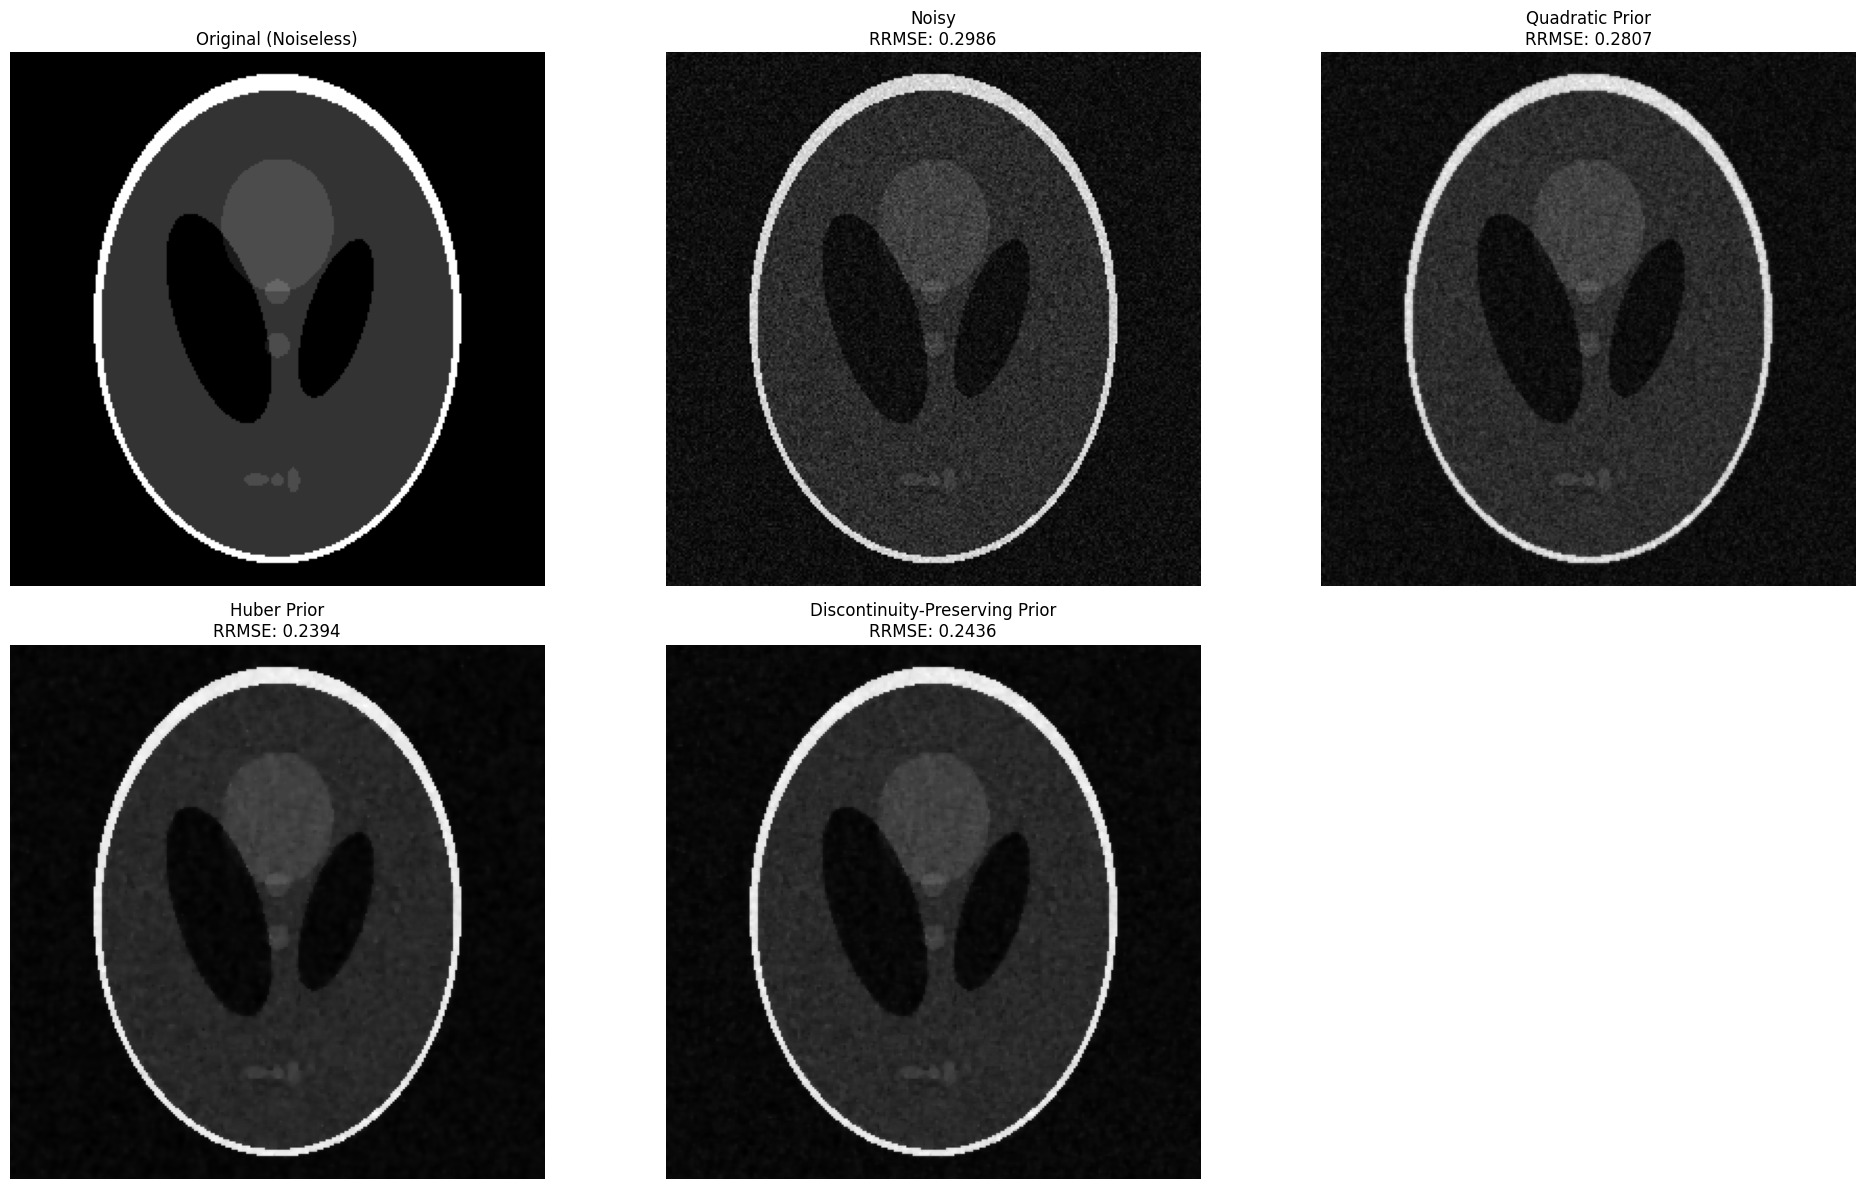

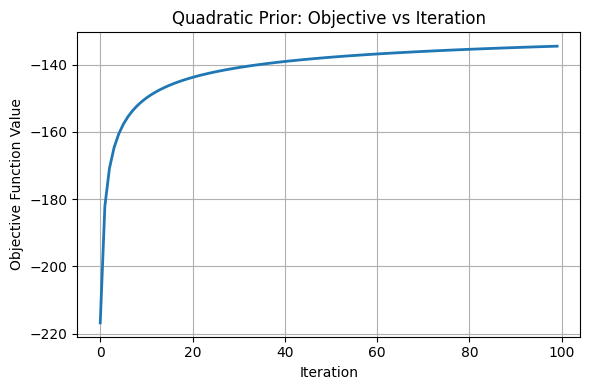

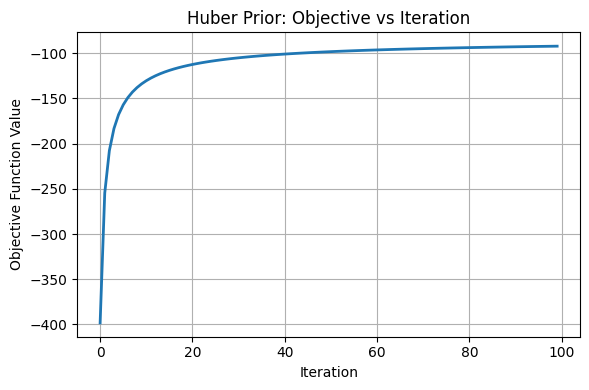

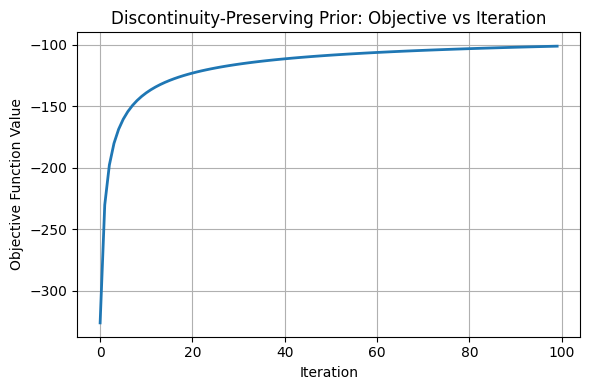


Detailed Parameter Summary:

QUADRATIC:
  α (alpha): 0.05975218611519265
  RRMSE: 0.280725
  MSE: 0.004779
  PSNR: 23.21 dB

HUBER:
  α (alpha): 0.9887618189880609
  γ (gamma): 0.031239792577646117
  RRMSE: 0.239420
  MSE: 0.003476
  PSNR: 24.59 dB

DISCONTINUITY_PRESERVING:
  α (alpha): 0.9997844519965374
  γ (gamma): 0.0387581821860533
  RRMSE: 0.243603
  MSE: 0.003598
  PSNR: 24.44 dB


In [16]:
final_results = {}

den_quad, obj_quad = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_quad,
    prior_type='quadratic',
    max_iterations=100,
    tolerance=1e-7
)
final_results['quadratic'] = {
    'denoised': den_quad,
    'rrmse': compute_rrmse(image_noiseless, den_quad),
    'alpha': best_alpha_quad,
    'gamma': None,
    'objective': obj_quad
}

den_huber, obj_huber = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_huber,
    prior_type='huber',
    gamma=best_gamma_huber,
    max_iterations=100,
    tolerance=1e-7
)
final_results['huber'] = {
    'denoised': den_huber,
    'rrmse': compute_rrmse(image_noiseless, den_huber),
    'alpha': best_alpha_huber,
    'gamma': best_gamma_huber,
    'objective': obj_huber
}

den_disc, obj_disc = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_disc,
    prior_type='discontinuity_preserving',
    gamma=best_gamma_disc,
    max_iterations=100,
    tolerance=1e-7
)
final_results['discontinuity_preserving'] = {
    'denoised': den_disc,
    'rrmse': compute_rrmse(image_noiseless, den_disc),
    'alpha': best_alpha_disc,
    'gamma': best_gamma_disc,
    'objective': obj_disc
}

plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.imshow(image_noiseless, cmap='gray')
plt.title('Original (Noiseless)')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(image_noisy, cmap='gray')
plt.title(f'Noisy\nRRMSE: {compute_rrmse(image_noiseless, image_noisy):.4f}')
plt.axis('off')

methods = ['quadratic', 'huber', 'discontinuity_preserving']
titles = ['Quadratic Prior', 'Huber Prior', 'Discontinuity-Preserving Prior']

for i, (method, title) in enumerate(zip(methods, titles)):
    result = final_results[method]

    ax = plt.subplot(2, 3, 3 + i)
    ax.imshow(result['denoised'], cmap='gray')
    ax.set_title(f'{title}\nRRMSE: {result["rrmse"]:.4f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['quadratic']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Quadratic Prior: Objective vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['huber']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Huber Prior: Objective vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['discontinuity_preserving']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Discontinuity-Preserving Prior: Objective vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()


print("\nDetailed Parameter Summary:")
print("=" * 60)

for method, result in final_results.items():
    print(f"\n{method.upper()}:")
    print(f"  α (alpha): {result['alpha']}")
    if result['gamma'] is not None:
        print(f"  γ (gamma): {result['gamma']}")
    print(f"  RRMSE: {result['rrmse']:.6f}")

    mse = np.mean((result['denoised'] - image_noiseless) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))

    print(f"  MSE: {mse:.6f}")
    print(f"  PSNR: {psnr:.2f} dB")
